In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


In [5]:
num_elements=len(scDataset)
dim=high_var_gene
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 2000


In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [11]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        if epoch<50:
            embedding_data=data.numpy().copy()
            data=data.to('cuda')
        else:
            data=data.to('cuda')
            embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [14]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    if epoch %50 == 0:
        embeddings=np.empty((0,mlp.rep_dim))
        model.eval()
        with torch.no_grad():
            for step, (x, y) in enumerate(scGenDataLoader):
                x=x.to('cuda')
                embedding=model.forward_embedding(x).cpu().detach().numpy()                 
                embeddings=np.row_stack((embeddings,embedding))
                memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.608520030975342	 loss_cluster: 3.2981789112091064
Step [2/8]	 loss_instance: 7.367413520812988	 loss_cluster: 3.2975661754608154
Step [4/8]	 loss_instance: 7.106478691101074	 loss_cluster: 3.2944889068603516
Step [6/8]	 loss_instance: 7.010378837585449	 loss_cluster: 3.2831215858459473

Epoch [1/500]	 Loss: 10.562538504600525 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4371 ARI = 0.2674 F = 0.4340 ACC = 0.0784



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.842102527618408	 loss_cluster: 3.2544820308685303
Step [2/8]	 loss_instance: 6.75514554977417	 loss_cluster: 3.2001023292541504
Step [4/8]	 loss_instance: 6.650702476501465	 loss_cluster: 3.125063419342041
Step [6/8]	 loss_instance: 6.615750312805176	 loss_cluster: 3.020184278488159

Epoch [2/500]	 Loss: 9.851112389564515 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5505 ARI = 0.3864 F = 0.5124 ACC = 0.1385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.578939437866211	 loss_cluster: 2.9216854572296143
Step [2/8]	 loss_instance: 6.549814224243164	 loss_cluster: 2.8383524417877197
Step [4/8]	 loss_instance: 6.519785404205322	 loss_cluster: 2.7560107707977295
Step [6/8]	 loss_instance: 6.532993793487549	 loss_cluster: 2.6492249965667725

Epoch [3/500]	 Loss: 9.318878960609435 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7011 ARI = 0.5967 F = 0.6795 ACC = 0.6838



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.4111504554748535	 loss_cluster: 2.5171732902526855
Step [2/8]	 loss_instance: 6.41926383972168	 loss_cluster: 2.414586067199707
Step [4/8]	 loss_instance: 6.361083030700684	 loss_cluster: 2.306027889251709
Step [6/8]	 loss_instance: 6.3688063621521	 loss_cluster: 2.297696113586426

Epoch [4/500]	 Loss: 8.77916944026947 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6577 ARI = 0.5348 F = 0.6207 ACC = 0.6183



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.3336663246154785	 loss_cluster: 2.21724796295166
Step [2/8]	 loss_instance: 6.323098659515381	 loss_cluster: 2.1915416717529297
Step [4/8]	 loss_instance: 6.305688381195068	 loss_cluster: 2.1428775787353516
Step [6/8]	 loss_instance: 6.296481609344482	 loss_cluster: 2.159695863723755

Epoch [5/500]	 Loss: 8.490063142776489 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7050 ARI = 0.5737 F = 0.6568 ACC = 0.6217



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.298829555511475	 loss_cluster: 2.1570818424224854
Step [2/8]	 loss_instance: 6.307823181152344	 loss_cluster: 2.1207680702209473
Step [4/8]	 loss_instance: 6.262803554534912	 loss_cluster: 2.089127779006958
Step [6/8]	 loss_instance: 6.27152681350708	 loss_cluster: 2.0652847290039062

Epoch [6/500]	 Loss: 8.361800980567931 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7156 ARI = 0.5272 F = 0.6212 ACC = 0.5732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.254402160644531	 loss_cluster: 2.056394338607788
Step [2/8]	 loss_instance: 6.252527713775635	 loss_cluster: 2.0484652519226074
Step [4/8]	 loss_instance: 6.260934829711914	 loss_cluster: 2.0609405040740967
Step [6/8]	 loss_instance: 6.259692192077637	 loss_cluster: 2.093261957168579

Epoch [7/500]	 Loss: 8.285839974880219 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6704 ARI = 0.4642 F = 0.5682 ACC = 0.5200



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.25532865524292	 loss_cluster: 2.010112762451172
Step [2/8]	 loss_instance: 6.225249290466309	 loss_cluster: 2.0149636268615723
Step [4/8]	 loss_instance: 6.237314224243164	 loss_cluster: 2.01753568649292
Step [6/8]	 loss_instance: 6.258532524108887	 loss_cluster: 1.9987982511520386

Epoch [8/500]	 Loss: 8.219804525375366 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6690 ARI = 0.4295 F = 0.5394 ACC = 0.5004



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.237334251403809	 loss_cluster: 1.985036015510559
Step [2/8]	 loss_instance: 6.2238969802856445	 loss_cluster: 1.9482719898223877
Step [4/8]	 loss_instance: 6.2149834632873535	 loss_cluster: 1.9716771841049194
Step [6/8]	 loss_instance: 6.205120086669922	 loss_cluster: 1.962852120399475

Epoch [9/500]	 Loss: 8.12743803858757 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6785 ARI = 0.4274 F = 0.5388 ACC = 0.4741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.19991397857666	 loss_cluster: 1.9213292598724365
Step [2/8]	 loss_instance: 6.217564105987549	 loss_cluster: 1.9276769161224365
Step [4/8]	 loss_instance: 6.195493698120117	 loss_cluster: 1.930302619934082
Step [6/8]	 loss_instance: 6.217820167541504	 loss_cluster: 1.9236220121383667

Epoch [10/500]	 Loss: 8.082710927724838 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6565 ARI = 0.3827 F = 0.5004 ACC = 0.4191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.209085941314697	 loss_cluster: 1.9545812606811523
Step [2/8]	 loss_instance: 6.200934410095215	 loss_cluster: 1.9015010595321655
Step [4/8]	 loss_instance: 6.203553199768066	 loss_cluster: 1.9198309183120728
Step [6/8]	 loss_instance: 6.198249816894531	 loss_cluster: 1.9073916673660278

Epoch [11/500]	 Loss: 8.0534696996212 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6942 ARI = 0.4406 F = 0.5549 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.204965591430664	 loss_cluster: 1.8994414806365967
Step [2/8]	 loss_instance: 6.199490547180176	 loss_cluster: 1.8652422428131104
Step [4/8]	 loss_instance: 6.194829940795898	 loss_cluster: 1.8416306972503662
Step [6/8]	 loss_instance: 6.182918548583984	 loss_cluster: 1.835769534111023

Epoch [12/500]	 Loss: 7.998265814781189 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4352 F = 0.5494 ACC = 0.5029



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.183060169219971	 loss_cluster: 1.826080083847046
Step [2/8]	 loss_instance: 6.18032693862915	 loss_cluster: 1.8516417741775513
Step [4/8]	 loss_instance: 6.173219203948975	 loss_cluster: 1.8304123878479004
Step [6/8]	 loss_instance: 6.173172473907471	 loss_cluster: 1.8053492307662964

Epoch [13/500]	 Loss: 7.940134364366531 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6846 ARI = 0.4034 F = 0.5233 ACC = 0.4419



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.156693935394287	 loss_cluster: 1.768857479095459
Step [2/8]	 loss_instance: 6.173826694488525	 loss_cluster: 1.8404711484909058
Step [4/8]	 loss_instance: 6.182421684265137	 loss_cluster: 1.8228609561920166
Step [6/8]	 loss_instance: 6.180205345153809	 loss_cluster: 1.8092689514160156

Epoch [14/500]	 Loss: 7.91719850897789 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6859 ARI = 0.4160 F = 0.5341 ACC = 0.4890



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.186696529388428	 loss_cluster: 1.8233435153961182
Step [2/8]	 loss_instance: 6.170498847961426	 loss_cluster: 1.7875336408615112
Step [4/8]	 loss_instance: 6.15317964553833	 loss_cluster: 1.766261339187622
Step [6/8]	 loss_instance: 6.1907124519348145	 loss_cluster: 1.8215607404708862

Epoch [15/500]	 Loss: 7.894152122735977 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6939 ARI = 0.4176 F = 0.5365 ACC = 0.4768



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1493611335754395	 loss_cluster: 1.7615848779678345
Step [2/8]	 loss_instance: 6.1719279289245605	 loss_cluster: 1.7982492446899414
Step [4/8]	 loss_instance: 6.164454936981201	 loss_cluster: 1.7748295068740845
Step [6/8]	 loss_instance: 6.169366359710693	 loss_cluster: 1.793126106262207

Epoch [16/500]	 Loss: 7.883951765298844 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6908 ARI = 0.4187 F = 0.5362 ACC = 0.5009



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.188051700592041	 loss_cluster: 1.8309483528137207
Step [2/8]	 loss_instance: 6.157661437988281	 loss_cluster: 1.7936142683029175
Step [4/8]	 loss_instance: 6.148843288421631	 loss_cluster: 1.7597296237945557
Step [6/8]	 loss_instance: 6.12216854095459	 loss_cluster: 1.7370916604995728

Epoch [17/500]	 Loss: 7.874528998136521 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7005 ARI = 0.4162 F = 0.5348 ACC = 0.4747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.143909454345703	 loss_cluster: 1.7509469985961914
Step [2/8]	 loss_instance: 6.151894569396973	 loss_cluster: 1.7842854261398315
Step [4/8]	 loss_instance: 6.14417839050293	 loss_cluster: 1.7564046382904053
Step [6/8]	 loss_instance: 6.142646789550781	 loss_cluster: 1.7714171409606934

Epoch [18/500]	 Loss: 7.844489234685898 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6898 ARI = 0.4092 F = 0.5284 ACC = 0.4885



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.146414756774902	 loss_cluster: 1.7597246170043945
Step [2/8]	 loss_instance: 6.14781379699707	 loss_cluster: 1.7798848152160645
Step [4/8]	 loss_instance: 6.136229515075684	 loss_cluster: 1.7558242082595825
Step [6/8]	 loss_instance: 6.135948657989502	 loss_cluster: 1.7618764638900757

Epoch [19/500]	 Loss: 7.836370414495468 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7144 ARI = 0.4377 F = 0.5555 ACC = 0.5101



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.129496097564697	 loss_cluster: 1.7434443235397339
Step [2/8]	 loss_instance: 6.129862308502197	 loss_cluster: 1.7569500207901
Step [4/8]	 loss_instance: 6.131443023681641	 loss_cluster: 1.7569420337677002
Step [6/8]	 loss_instance: 6.131621360778809	 loss_cluster: 1.7488195896148682

Epoch [20/500]	 Loss: 7.821183961629868 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7147 ARI = 0.4452 F = 0.5614 ACC = 0.5251



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.120071887969971	 loss_cluster: 1.7450143098831177
Step [2/8]	 loss_instance: 6.104350566864014	 loss_cluster: 1.726470708847046
Step [4/8]	 loss_instance: 6.131552696228027	 loss_cluster: 1.7672492265701294
Step [6/8]	 loss_instance: 6.126065731048584	 loss_cluster: 1.7601052522659302

Epoch [21/500]	 Loss: 7.805865913629532 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7072 ARI = 0.4285 F = 0.5466 ACC = 0.5083



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.124814987182617	 loss_cluster: 1.731489658355713
Step [2/8]	 loss_instance: 6.114999294281006	 loss_cluster: 1.7629845142364502
Step [4/8]	 loss_instance: 6.114383220672607	 loss_cluster: 1.7330636978149414
Step [6/8]	 loss_instance: 6.112063884735107	 loss_cluster: 1.7325786352157593

Epoch [22/500]	 Loss: 7.787181609869004 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7124 ARI = 0.4295 F = 0.5476 ACC = 0.4949



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.116456508636475	 loss_cluster: 1.7354331016540527
Step [2/8]	 loss_instance: 6.097268581390381	 loss_cluster: 1.7212506532669067
Step [4/8]	 loss_instance: 6.132580280303955	 loss_cluster: 1.7499263286590576
Step [6/8]	 loss_instance: 6.094859600067139	 loss_cluster: 1.7386724948883057

Epoch [23/500]	 Loss: 7.777938896417618 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7123 ARI = 0.4324 F = 0.5502 ACC = 0.4995



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.11956262588501	 loss_cluster: 1.760724425315857
Step [2/8]	 loss_instance: 6.120306015014648	 loss_cluster: 1.73916757106781
Step [4/8]	 loss_instance: 6.093142032623291	 loss_cluster: 1.7212910652160645
Step [6/8]	 loss_instance: 6.116317272186279	 loss_cluster: 1.7470886707305908

Epoch [24/500]	 Loss: 7.782117319107056 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7116 ARI = 0.4267 F = 0.5457 ACC = 0.4840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.117643356323242	 loss_cluster: 1.7529513835906982
Step [2/8]	 loss_instance: 6.1177167892456055	 loss_cluster: 1.7703068256378174
Step [4/8]	 loss_instance: 6.10532808303833	 loss_cluster: 1.7407177686691284
Step [6/8]	 loss_instance: 6.10336971282959	 loss_cluster: 1.7296448945999146

Epoch [25/500]	 Loss: 7.780284869670868 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7054 ARI = 0.4316 F = 0.5494 ACC = 0.5156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.095970630645752	 loss_cluster: 1.7244975566864014
Step [2/8]	 loss_instance: 6.094099998474121	 loss_cluster: 1.7189360857009888
Step [4/8]	 loss_instance: 6.090705871582031	 loss_cluster: 1.717321515083313
Step [6/8]	 loss_instance: 6.100151538848877	 loss_cluster: 1.7469046115875244

Epoch [26/500]	 Loss: 7.761987882852554 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7113 ARI = 0.4286 F = 0.5467 ACC = 0.4951



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.109522819519043	 loss_cluster: 1.7279486656188965
Step [2/8]	 loss_instance: 6.105508327484131	 loss_cluster: 1.7287522554397583
Step [4/8]	 loss_instance: 6.0829949378967285	 loss_cluster: 1.6955995559692383
Step [6/8]	 loss_instance: 6.103337287902832	 loss_cluster: 1.7263027429580688

Epoch [27/500]	 Loss: 7.746610486507416 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7149 ARI = 0.4280 F = 0.5471 ACC = 0.4913



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0983099937438965	 loss_cluster: 1.7276521921157837
Step [2/8]	 loss_instance: 6.114715576171875	 loss_cluster: 1.7722173929214478
Step [4/8]	 loss_instance: 6.088287353515625	 loss_cluster: 1.7255741357803345
Step [6/8]	 loss_instance: 6.094337463378906	 loss_cluster: 1.7169387340545654

Epoch [28/500]	 Loss: 7.763660949468613 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7083 ARI = 0.4260 F = 0.5442 ACC = 0.5016



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.095713138580322	 loss_cluster: 1.731273889541626
Step [2/8]	 loss_instance: 6.089139461517334	 loss_cluster: 1.713356375694275
Step [4/8]	 loss_instance: 6.092041969299316	 loss_cluster: 1.7446078062057495
Step [6/8]	 loss_instance: 6.096158504486084	 loss_cluster: 1.712619423866272

Epoch [29/500]	 Loss: 7.7544665932655334 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7157 ARI = 0.4400 F = 0.5569 ACC = 0.5192



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1119771003723145	 loss_cluster: 1.7366329431533813
Step [2/8]	 loss_instance: 6.104671478271484	 loss_cluster: 1.729091763496399
Step [4/8]	 loss_instance: 6.103272438049316	 loss_cluster: 1.7341948747634888
Step [6/8]	 loss_instance: 6.086796760559082	 loss_cluster: 1.7228480577468872

Epoch [30/500]	 Loss: 7.745490753650666 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7135 ARI = 0.4306 F = 0.5484 ACC = 0.5010



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0707244873046875	 loss_cluster: 1.7059003114700317
Step [2/8]	 loss_instance: 6.091424942016602	 loss_cluster: 1.7206861972808838
Step [4/8]	 loss_instance: 6.089894771575928	 loss_cluster: 1.7323611974716187
Step [6/8]	 loss_instance: 6.092934608459473	 loss_cluster: 1.7253698110580444

Epoch [31/500]	 Loss: 7.728976637125015 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7076 ARI = 0.4154 F = 0.5348 ACC = 0.4794



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.095738887786865	 loss_cluster: 1.732780933380127
Step [2/8]	 loss_instance: 6.0799994468688965	 loss_cluster: 1.7118974924087524
Step [4/8]	 loss_instance: 6.0878448486328125	 loss_cluster: 1.7252758741378784
Step [6/8]	 loss_instance: 6.076329708099365	 loss_cluster: 1.7199840545654297

Epoch [32/500]	 Loss: 7.723877489566803 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7252 ARI = 0.4430 F = 0.5609 ACC = 0.4974



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0672197341918945	 loss_cluster: 1.710229754447937
Step [2/8]	 loss_instance: 6.086562633514404	 loss_cluster: 1.7055951356887817
Step [4/8]	 loss_instance: 6.093053817749023	 loss_cluster: 1.7200665473937988
Step [6/8]	 loss_instance: 6.077961444854736	 loss_cluster: 1.7258814573287964

Epoch [33/500]	 Loss: 7.726709568500519 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7126 ARI = 0.4200 F = 0.5396 ACC = 0.4774



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.076092720031738	 loss_cluster: 1.711943507194519
Step [2/8]	 loss_instance: 6.069970607757568	 loss_cluster: 1.688274621963501
Step [4/8]	 loss_instance: 6.089412212371826	 loss_cluster: 1.7399680614471436
Step [6/8]	 loss_instance: 6.087230205535889	 loss_cluster: 1.732270359992981

Epoch [34/500]	 Loss: 7.720793813467026 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7238 ARI = 0.4483 F = 0.5651 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.061085224151611	 loss_cluster: 1.6986949443817139
Step [2/8]	 loss_instance: 6.103267669677734	 loss_cluster: 1.7243306636810303
Step [4/8]	 loss_instance: 6.054622650146484	 loss_cluster: 1.6857298612594604
Step [6/8]	 loss_instance: 6.074630260467529	 loss_cluster: 1.7075419425964355

Epoch [35/500]	 Loss: 7.711501401662827 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7188 ARI = 0.4440 F = 0.5608 ACC = 0.5214



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.062571048736572	 loss_cluster: 1.7002350091934204
Step [2/8]	 loss_instance: 6.072828769683838	 loss_cluster: 1.7197290658950806
Step [4/8]	 loss_instance: 6.063480854034424	 loss_cluster: 1.701819658279419
Step [6/8]	 loss_instance: 6.0931901931762695	 loss_cluster: 1.7422250509262085

Epoch [36/500]	 Loss: 7.715806037187576 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7141 ARI = 0.4267 F = 0.5454 ACC = 0.4943



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.068877696990967	 loss_cluster: 1.705164909362793
Step [2/8]	 loss_instance: 6.065723896026611	 loss_cluster: 1.6959067583084106
Step [4/8]	 loss_instance: 6.063554763793945	 loss_cluster: 1.7197511196136475
Step [6/8]	 loss_instance: 6.078554630279541	 loss_cluster: 1.7072017192840576

Epoch [37/500]	 Loss: 7.703378057479858 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7161 ARI = 0.4213 F = 0.5410 ACC = 0.4768



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.072317600250244	 loss_cluster: 1.7208443880081177
Step [2/8]	 loss_instance: 6.070936679840088	 loss_cluster: 1.7053523063659668
Step [4/8]	 loss_instance: 6.06088399887085	 loss_cluster: 1.689402461051941
Step [6/8]	 loss_instance: 6.067691326141357	 loss_cluster: 1.705596685409546

Epoch [38/500]	 Loss: 7.703263682126999 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7128 ARI = 0.4195 F = 0.5389 ACC = 0.4817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.068968296051025	 loss_cluster: 1.7049663066864014
Step [2/8]	 loss_instance: 6.082805633544922	 loss_cluster: 1.7125942707061768
Step [4/8]	 loss_instance: 6.070251941680908	 loss_cluster: 1.7190932035446167
Step [6/8]	 loss_instance: 6.067527770996094	 loss_cluster: 1.709699034690857

Epoch [39/500]	 Loss: 7.690971946716308 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7210 ARI = 0.4331 F = 0.5516 ACC = 0.4941



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.061253070831299	 loss_cluster: 1.7014302015304565
Step [2/8]	 loss_instance: 6.087996006011963	 loss_cluster: 1.7361855506896973
Step [4/8]	 loss_instance: 6.072962760925293	 loss_cluster: 1.7115615606307983
Step [6/8]	 loss_instance: 6.06935453414917	 loss_cluster: 1.6923458576202393

Epoch [40/500]	 Loss: 7.69314484000206 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7194 ARI = 0.4299 F = 0.5487 ACC = 0.4969



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.066563129425049	 loss_cluster: 1.7049273252487183
Step [2/8]	 loss_instance: 6.068856716156006	 loss_cluster: 1.700541377067566
Step [4/8]	 loss_instance: 6.0750274658203125	 loss_cluster: 1.721956491470337
Step [6/8]	 loss_instance: 6.072317123413086	 loss_cluster: 1.7065163850784302

Epoch [41/500]	 Loss: 7.692023366689682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7199 ARI = 0.4349 F = 0.5531 ACC = 0.5015



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.055993556976318	 loss_cluster: 1.6901137828826904
Step [2/8]	 loss_instance: 6.063028812408447	 loss_cluster: 1.7012948989868164
Step [4/8]	 loss_instance: 6.062990665435791	 loss_cluster: 1.7075034379959106
Step [6/8]	 loss_instance: 6.045004367828369	 loss_cluster: 1.7016299962997437

Epoch [42/500]	 Loss: 7.693825316429138 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7161 ARI = 0.4281 F = 0.5467 ACC = 0.4963



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052990913391113	 loss_cluster: 1.7026163339614868
Step [2/8]	 loss_instance: 6.070508003234863	 loss_cluster: 1.705060362815857
Step [4/8]	 loss_instance: 6.069373607635498	 loss_cluster: 1.7073605060577393
Step [6/8]	 loss_instance: 6.074312210083008	 loss_cluster: 1.7078551054000854

Epoch [43/500]	 Loss: 7.689386755228043 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7153 ARI = 0.4224 F = 0.5414 ACC = 0.4825



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.067349910736084	 loss_cluster: 1.702589750289917
Step [2/8]	 loss_instance: 6.075120449066162	 loss_cluster: 1.7053451538085938
Step [4/8]	 loss_instance: 6.05447244644165	 loss_cluster: 1.6964582204818726
Step [6/8]	 loss_instance: 6.077388286590576	 loss_cluster: 1.7102487087249756

Epoch [44/500]	 Loss: 7.6812355697155 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7180 ARI = 0.4268 F = 0.5461 ACC = 0.4911



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.068387031555176	 loss_cluster: 1.695251703262329
Step [2/8]	 loss_instance: 6.057093143463135	 loss_cluster: 1.7010244131088257
Step [4/8]	 loss_instance: 6.070125579833984	 loss_cluster: 1.7060142755508423
Step [6/8]	 loss_instance: 6.061302661895752	 loss_cluster: 1.6796571016311646

Epoch [45/500]	 Loss: 7.676679110527038 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7185 ARI = 0.4323 F = 0.5502 ACC = 0.5020



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.059150218963623	 loss_cluster: 1.6995753049850464
Step [2/8]	 loss_instance: 6.062286376953125	 loss_cluster: 1.684790849685669
Step [4/8]	 loss_instance: 6.056334495544434	 loss_cluster: 1.6884510517120361
Step [6/8]	 loss_instance: 6.062683582305908	 loss_cluster: 1.688529372215271

Epoch [46/500]	 Loss: 7.676520341634751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7195 ARI = 0.4313 F = 0.5501 ACC = 0.4924



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.07249116897583	 loss_cluster: 1.7237855195999146
Step [2/8]	 loss_instance: 6.0758771896362305	 loss_cluster: 1.7310659885406494
Step [4/8]	 loss_instance: 6.054693698883057	 loss_cluster: 1.6929556131362915
Step [6/8]	 loss_instance: 6.06814432144165	 loss_cluster: 1.7136598825454712

Epoch [47/500]	 Loss: 7.705415976047516 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7148 ARI = 0.4224 F = 0.5422 ACC = 0.4773



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.056233882904053	 loss_cluster: 1.7066538333892822
Step [2/8]	 loss_instance: 6.039597034454346	 loss_cluster: 1.6887279748916626
Step [4/8]	 loss_instance: 6.066093444824219	 loss_cluster: 1.7261592149734497
Step [6/8]	 loss_instance: 6.068892478942871	 loss_cluster: 1.7030189037322998

Epoch [48/500]	 Loss: 7.679397708177566 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7136 ARI = 0.4219 F = 0.5420 ACC = 0.4845



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.053740978240967	 loss_cluster: 1.6988695859909058
Step [2/8]	 loss_instance: 6.042059421539307	 loss_cluster: 1.6808475255966187
Step [4/8]	 loss_instance: 6.070009708404541	 loss_cluster: 1.7140014171600342
Step [6/8]	 loss_instance: 6.057390213012695	 loss_cluster: 1.6862386465072632

Epoch [49/500]	 Loss: 7.6721946716308596 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7168 ARI = 0.4248 F = 0.5443 ACC = 0.4937



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899815559387207	 loss_cluster: 1.5832637548446655
Step [2/8]	 loss_instance: 5.910210132598877	 loss_cluster: 1.595426082611084
Step [4/8]	 loss_instance: 5.8991169929504395	 loss_cluster: 1.5789870023727417
Step [6/8]	 loss_instance: 5.905505657196045	 loss_cluster: 1.5785592794418335

Epoch [50/500]	 Loss: 7.485551363229751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7027 ARI = 0.4113 F = 0.5313 ACC = 0.4834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918890953063965	 loss_cluster: 1.6025164127349854
Step [2/8]	 loss_instance: 5.915243625640869	 loss_cluster: 1.5927129983901978
Step [4/8]	 loss_instance: 5.97602653503418	 loss_cluster: 1.6291120052337646
Step [6/8]	 loss_instance: 5.9722819328308105	 loss_cluster: 1.6407989263534546

Epoch [51/500]	 Loss: 7.6246520459651945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7108 ARI = 0.4239 F = 0.5424 ACC = 0.5062



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9798431396484375	 loss_cluster: 1.773333191871643
Step [2/8]	 loss_instance: 6.053624629974365	 loss_cluster: 2.2069296836853027
Step [4/8]	 loss_instance: 6.104956150054932	 loss_cluster: 1.864113450050354
Step [6/8]	 loss_instance: 6.074229717254639	 loss_cluster: 1.7125413417816162

Epoch [52/500]	 Loss: 8.034597808122635 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4102 F = 0.5277 ACC = 0.4763



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.029123783111572	 loss_cluster: 1.667920708656311
Step [2/8]	 loss_instance: 5.9857048988342285	 loss_cluster: 1.6469286680221558
Step [4/8]	 loss_instance: 5.930315971374512	 loss_cluster: 1.6000512838363647
Step [6/8]	 loss_instance: 5.931552410125732	 loss_cluster: 1.5902091264724731

Epoch [53/500]	 Loss: 7.5924551606178285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7061 ARI = 0.4102 F = 0.5309 ACC = 0.4718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912195205688477	 loss_cluster: 1.5892159938812256
Step [2/8]	 loss_instance: 5.921422958374023	 loss_cluster: 1.5985116958618164
Step [4/8]	 loss_instance: 5.912282943725586	 loss_cluster: 1.5772392749786377
Step [6/8]	 loss_instance: 5.911488056182861	 loss_cluster: 1.5713320970535278

Epoch [54/500]	 Loss: 7.488630706071854 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7035 ARI = 0.4110 F = 0.5317 ACC = 0.4830



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910346508026123	 loss_cluster: 1.5814875364303589
Step [2/8]	 loss_instance: 5.9031524658203125	 loss_cluster: 1.5634640455245972
Step [4/8]	 loss_instance: 5.907020568847656	 loss_cluster: 1.580741047859192
Step [6/8]	 loss_instance: 5.9112372398376465	 loss_cluster: 1.576645851135254

Epoch [55/500]	 Loss: 7.482000136375428 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6993 ARI = 0.4057 F = 0.5267 ACC = 0.4775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920607566833496	 loss_cluster: 1.5811641216278076
Step [2/8]	 loss_instance: 5.902484893798828	 loss_cluster: 1.572957992553711
Step [4/8]	 loss_instance: 5.930384635925293	 loss_cluster: 1.5912410020828247
Step [6/8]	 loss_instance: 5.896798133850098	 loss_cluster: 1.5657682418823242

Epoch [56/500]	 Loss: 7.477190715074539 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7012 ARI = 0.4051 F = 0.5255 ACC = 0.4661



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900425434112549	 loss_cluster: 1.570086121559143
Step [2/8]	 loss_instance: 5.909939765930176	 loss_cluster: 1.5698579549789429
Step [4/8]	 loss_instance: 5.907224655151367	 loss_cluster: 1.5764014720916748
Step [6/8]	 loss_instance: 5.91151237487793	 loss_cluster: 1.5771771669387817

Epoch [57/500]	 Loss: 7.474894821643829 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4028 F = 0.5238 ACC = 0.4750



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904696464538574	 loss_cluster: 1.5800131559371948
Step [2/8]	 loss_instance: 5.896529674530029	 loss_cluster: 1.561110019683838
Step [4/8]	 loss_instance: 5.908321857452393	 loss_cluster: 1.570949673652649
Step [6/8]	 loss_instance: 5.903894424438477	 loss_cluster: 1.575238823890686

Epoch [58/500]	 Loss: 7.4657771468162535 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6969 ARI = 0.3983 F = 0.5191 ACC = 0.4672



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905996799468994	 loss_cluster: 1.578027367591858
Step [2/8]	 loss_instance: 5.906327247619629	 loss_cluster: 1.5775645971298218
Step [4/8]	 loss_instance: 5.9127092361450195	 loss_cluster: 1.578370451927185
Step [6/8]	 loss_instance: 5.89795446395874	 loss_cluster: 1.5721714496612549

Epoch [59/500]	 Loss: 7.472072243690491 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.3995 F = 0.5209 ACC = 0.4651



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.893264293670654	 loss_cluster: 1.5572186708450317
Step [2/8]	 loss_instance: 5.903049945831299	 loss_cluster: 1.5694022178649902
Step [4/8]	 loss_instance: 5.897759914398193	 loss_cluster: 1.5641279220581055
Step [6/8]	 loss_instance: 5.896116733551025	 loss_cluster: 1.5612590312957764

Epoch [60/500]	 Loss: 7.4622574031352995 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6969 ARI = 0.4020 F = 0.5235 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900625705718994	 loss_cluster: 1.5580424070358276
Step [2/8]	 loss_instance: 5.893123626708984	 loss_cluster: 1.5575945377349854
Step [4/8]	 loss_instance: 5.906745910644531	 loss_cluster: 1.581588625907898
Step [6/8]	 loss_instance: 5.8980512619018555	 loss_cluster: 1.584386944770813

Epoch [61/500]	 Loss: 7.459590637683869 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.4036 F = 0.5252 ACC = 0.4751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9190263748168945	 loss_cluster: 1.5706923007965088
Step [2/8]	 loss_instance: 5.884295463562012	 loss_cluster: 1.565130591392517
Step [4/8]	 loss_instance: 5.910833835601807	 loss_cluster: 1.573152780532837
Step [6/8]	 loss_instance: 5.901035308837891	 loss_cluster: 1.5697273015975952

Epoch [62/500]	 Loss: 7.462588316202163 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6917 ARI = 0.3912 F = 0.5126 ACC = 0.4618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9022135734558105	 loss_cluster: 1.5674073696136475
Step [2/8]	 loss_instance: 5.897684097290039	 loss_cluster: 1.5637235641479492
Step [4/8]	 loss_instance: 5.899129867553711	 loss_cluster: 1.5704706907272339
Step [6/8]	 loss_instance: 5.934629917144775	 loss_cluster: 1.5841236114501953

Epoch [63/500]	 Loss: 7.469020998477935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6938 ARI = 0.3950 F = 0.5160 ACC = 0.4587



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901565074920654	 loss_cluster: 1.5829709768295288
Step [2/8]	 loss_instance: 5.918915271759033	 loss_cluster: 1.5871888399124146
Step [4/8]	 loss_instance: 5.896337032318115	 loss_cluster: 1.5667619705200195
Step [6/8]	 loss_instance: 5.900794506072998	 loss_cluster: 1.5752041339874268

Epoch [64/500]	 Loss: 7.472571569681167 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6893 ARI = 0.3912 F = 0.5126 ACC = 0.4744



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8932366371154785	 loss_cluster: 1.5761101245880127
Step [2/8]	 loss_instance: 5.897422790527344	 loss_cluster: 1.5744974613189697
Step [4/8]	 loss_instance: 5.926103591918945	 loss_cluster: 1.609410285949707
Step [6/8]	 loss_instance: 5.904824256896973	 loss_cluster: 1.5773943662643433

Epoch [65/500]	 Loss: 7.4695501804351805 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6890 ARI = 0.3924 F = 0.5144 ACC = 0.4750



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897422790527344	 loss_cluster: 1.5757275819778442
Step [2/8]	 loss_instance: 5.9035258293151855	 loss_cluster: 1.5815398693084717
Step [4/8]	 loss_instance: 5.90078067779541	 loss_cluster: 1.5750887393951416
Step [6/8]	 loss_instance: 5.900278091430664	 loss_cluster: 1.5742899179458618

Epoch [66/500]	 Loss: 7.463700407743454 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.3955 F = 0.5166 ACC = 0.4773



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911043167114258	 loss_cluster: 1.580137848854065
Step [2/8]	 loss_instance: 5.8964080810546875	 loss_cluster: 1.5779465436935425
Step [4/8]	 loss_instance: 5.8954010009765625	 loss_cluster: 1.570219874382019
Step [6/8]	 loss_instance: 5.905702114105225	 loss_cluster: 1.5931198596954346

Epoch [67/500]	 Loss: 7.455429571866989 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6912 ARI = 0.4054 F = 0.5267 ACC = 0.4869



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9063544273376465	 loss_cluster: 1.5904934406280518
Step [2/8]	 loss_instance: 5.889087200164795	 loss_cluster: 1.5653544664382935
Step [4/8]	 loss_instance: 5.895328998565674	 loss_cluster: 1.5635014772415161
Step [6/8]	 loss_instance: 5.888174533843994	 loss_cluster: 1.5905685424804688

Epoch [68/500]	 Loss: 7.4561621189117435 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.3951 F = 0.5166 ACC = 0.4750



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895866870880127	 loss_cluster: 1.570999026298523
Step [2/8]	 loss_instance: 5.892435073852539	 loss_cluster: 1.5675245523452759
Step [4/8]	 loss_instance: 5.8989386558532715	 loss_cluster: 1.5629888772964478
Step [6/8]	 loss_instance: 5.884185314178467	 loss_cluster: 1.5704801082611084

Epoch [69/500]	 Loss: 7.454186797142029 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6897 ARI = 0.3978 F = 0.5192 ACC = 0.4851



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891264915466309	 loss_cluster: 1.5671507120132446
Step [2/8]	 loss_instance: 5.894358158111572	 loss_cluster: 1.5797473192214966
Step [4/8]	 loss_instance: 5.894323348999023	 loss_cluster: 1.5702406167984009
Step [6/8]	 loss_instance: 5.9064226150512695	 loss_cluster: 1.5749164819717407

Epoch [70/500]	 Loss: 7.450535470247269 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.3993 F = 0.5203 ACC = 0.4745



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892270088195801	 loss_cluster: 1.5694907903671265
Step [2/8]	 loss_instance: 5.892582893371582	 loss_cluster: 1.5723909139633179
Step [4/8]	 loss_instance: 5.902687072753906	 loss_cluster: 1.579774260520935
Step [6/8]	 loss_instance: 5.90983247756958	 loss_cluster: 1.5756393671035767

Epoch [71/500]	 Loss: 7.44933112859726 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6835 ARI = 0.3826 F = 0.5044 ACC = 0.4628



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8835344314575195	 loss_cluster: 1.5668158531188965
Step [2/8]	 loss_instance: 5.887914657592773	 loss_cluster: 1.576054334640503
Step [4/8]	 loss_instance: 5.8909783363342285	 loss_cluster: 1.5747836828231812
Step [6/8]	 loss_instance: 5.8922014236450195	 loss_cluster: 1.5865217447280884

Epoch [72/500]	 Loss: 7.445674109458923 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6963 ARI = 0.3960 F = 0.5175 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901357650756836	 loss_cluster: 1.578734040260315
Step [2/8]	 loss_instance: 5.895709991455078	 loss_cluster: 1.584314227104187
Step [4/8]	 loss_instance: 5.88291072845459	 loss_cluster: 1.5588167905807495
Step [6/8]	 loss_instance: 5.878506660461426	 loss_cluster: 1.552971363067627

Epoch [73/500]	 Loss: 7.44086891412735 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6702 ARI = 0.3664 F = 0.4890 ACC = 0.4521



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879181861877441	 loss_cluster: 1.5552417039871216
Step [2/8]	 loss_instance: 5.887373447418213	 loss_cluster: 1.5796698331832886
Step [4/8]	 loss_instance: 5.897068977355957	 loss_cluster: 1.5666329860687256
Step [6/8]	 loss_instance: 5.915521621704102	 loss_cluster: 1.591148018836975

Epoch [74/500]	 Loss: 7.446893906593322 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6860 ARI = 0.3806 F = 0.5025 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907922744750977	 loss_cluster: 1.5740337371826172
Step [2/8]	 loss_instance: 5.899184226989746	 loss_cluster: 1.5960569381713867
Step [4/8]	 loss_instance: 5.886612415313721	 loss_cluster: 1.5708919763565063
Step [6/8]	 loss_instance: 5.878419399261475	 loss_cluster: 1.5598312616348267

Epoch [75/500]	 Loss: 7.448128372430801 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.3988 F = 0.5203 ACC = 0.4709



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887136459350586	 loss_cluster: 1.566215991973877
Step [2/8]	 loss_instance: 5.888185501098633	 loss_cluster: 1.5718598365783691
Step [4/8]	 loss_instance: 5.889732837677002	 loss_cluster: 1.5686705112457275
Step [6/8]	 loss_instance: 5.884209156036377	 loss_cluster: 1.5830515623092651

Epoch [76/500]	 Loss: 7.439202302694321 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7027 ARI = 0.4137 F = 0.5342 ACC = 0.4915



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924725532531738	 loss_cluster: 1.6069105863571167
Step [2/8]	 loss_instance: 5.8834662437438965	 loss_cluster: 1.5628808736801147
Step [4/8]	 loss_instance: 5.897515296936035	 loss_cluster: 1.581360101699829
Step [6/8]	 loss_instance: 5.883021354675293	 loss_cluster: 1.5596266984939575

Epoch [77/500]	 Loss: 7.456205916404724 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6760 ARI = 0.3748 F = 0.4969 ACC = 0.4547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894456386566162	 loss_cluster: 1.5670347213745117
Step [2/8]	 loss_instance: 5.878143787384033	 loss_cluster: 1.5692124366760254
Step [4/8]	 loss_instance: 5.889253616333008	 loss_cluster: 1.5728996992111206
Step [6/8]	 loss_instance: 5.8770551681518555	 loss_cluster: 1.5677833557128906

Epoch [78/500]	 Loss: 7.434173846244812 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6764 ARI = 0.3818 F = 0.5038 ACC = 0.4674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8855390548706055	 loss_cluster: 1.5670676231384277
Step [2/8]	 loss_instance: 5.888615608215332	 loss_cluster: 1.57542884349823
Step [4/8]	 loss_instance: 5.89459753036499	 loss_cluster: 1.5747299194335938
Step [6/8]	 loss_instance: 5.897284030914307	 loss_cluster: 1.575873851776123

Epoch [79/500]	 Loss: 7.44539766907692 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6660 ARI = 0.3637 F = 0.4867 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884345531463623	 loss_cluster: 1.582409143447876
Step [2/8]	 loss_instance: 5.889352321624756	 loss_cluster: 1.586875557899475
Step [4/8]	 loss_instance: 5.887273788452148	 loss_cluster: 1.591490626335144
Step [6/8]	 loss_instance: 5.901806831359863	 loss_cluster: 1.5843534469604492

Epoch [80/500]	 Loss: 7.45770645737648 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6869 ARI = 0.3912 F = 0.5134 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924027919769287	 loss_cluster: 1.608991265296936
Step [2/8]	 loss_instance: 5.906817436218262	 loss_cluster: 1.5838686227798462
Step [4/8]	 loss_instance: 5.910717487335205	 loss_cluster: 1.5885030031204224
Step [6/8]	 loss_instance: 5.890264987945557	 loss_cluster: 1.5790799856185913

Epoch [81/500]	 Loss: 7.470259761810302 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6729 ARI = 0.3763 F = 0.4991 ACC = 0.4565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904174327850342	 loss_cluster: 1.5997157096862793
Step [2/8]	 loss_instance: 5.911440372467041	 loss_cluster: 1.5875064134597778
Step [4/8]	 loss_instance: 5.8984551429748535	 loss_cluster: 1.5867903232574463
Step [6/8]	 loss_instance: 5.903906345367432	 loss_cluster: 1.595447063446045

Epoch [82/500]	 Loss: 7.47700697183609 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6912 ARI = 0.3951 F = 0.5159 ACC = 0.4547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900849342346191	 loss_cluster: 1.582150936126709
Step [2/8]	 loss_instance: 5.897202968597412	 loss_cluster: 1.5865895748138428
Step [4/8]	 loss_instance: 5.909324645996094	 loss_cluster: 1.5847957134246826
Step [6/8]	 loss_instance: 5.891803741455078	 loss_cluster: 1.584206461906433

Epoch [83/500]	 Loss: 7.470800471305847 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6648 ARI = 0.3647 F = 0.4868 ACC = 0.4373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896946430206299	 loss_cluster: 1.5758585929870605
Step [2/8]	 loss_instance: 5.911278247833252	 loss_cluster: 1.5987340211868286
Step [4/8]	 loss_instance: 5.926890850067139	 loss_cluster: 1.5972203016281128
Step [6/8]	 loss_instance: 5.901177883148193	 loss_cluster: 1.5800429582595825

Epoch [84/500]	 Loss: 7.476180619001388 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6722 ARI = 0.3713 F = 0.4941 ACC = 0.4485



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904725551605225	 loss_cluster: 1.594812035560608
Step [2/8]	 loss_instance: 5.901607513427734	 loss_cluster: 1.584534764289856
Step [4/8]	 loss_instance: 5.925867557525635	 loss_cluster: 1.6007537841796875
Step [6/8]	 loss_instance: 5.91771125793457	 loss_cluster: 1.5915234088897705

Epoch [85/500]	 Loss: 7.490539002418518 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6806 ARI = 0.3795 F = 0.5019 ACC = 0.4587



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898344993591309	 loss_cluster: 1.5775386095046997
Step [2/8]	 loss_instance: 5.8909382820129395	 loss_cluster: 1.5731744766235352
Step [4/8]	 loss_instance: 5.891735076904297	 loss_cluster: 1.5730396509170532
Step [6/8]	 loss_instance: 5.895349979400635	 loss_cluster: 1.5692425966262817

Epoch [86/500]	 Loss: 7.455993980169296 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6758 ARI = 0.3707 F = 0.4925 ACC = 0.4425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.879420280456543	 loss_cluster: 1.561517596244812
Step [2/8]	 loss_instance: 5.8909687995910645	 loss_cluster: 1.571829080581665
Step [4/8]	 loss_instance: 5.879355430603027	 loss_cluster: 1.5670498609542847
Step [6/8]	 loss_instance: 5.8879289627075195	 loss_cluster: 1.5662963390350342

Epoch [87/500]	 Loss: 7.449864739179612 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6771 ARI = 0.3737 F = 0.4961 ACC = 0.4561



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888059616088867	 loss_cluster: 1.5678939819335938
Step [2/8]	 loss_instance: 5.876297473907471	 loss_cluster: 1.5735211372375488
Step [4/8]	 loss_instance: 5.906728744506836	 loss_cluster: 1.590057373046875
Step [6/8]	 loss_instance: 5.889772891998291	 loss_cluster: 1.5771795511245728

Epoch [88/500]	 Loss: 7.444205957651138 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6744 ARI = 0.3685 F = 0.4910 ACC = 0.4485



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886659622192383	 loss_cluster: 1.5812489986419678
Step [2/8]	 loss_instance: 5.883849143981934	 loss_cluster: 1.5695823431015015
Step [4/8]	 loss_instance: 5.888676643371582	 loss_cluster: 1.5739612579345703
Step [6/8]	 loss_instance: 5.89474630355835	 loss_cluster: 1.5843850374221802

Epoch [89/500]	 Loss: 7.452324259281158 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6608 ARI = 0.3567 F = 0.4783 ACC = 0.4565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9268412590026855	 loss_cluster: 1.638396978378296
Step [2/8]	 loss_instance: 5.9184088706970215	 loss_cluster: 1.6319338083267212
Step [4/8]	 loss_instance: 5.941829681396484	 loss_cluster: 1.6282888650894165
Step [6/8]	 loss_instance: 5.984560012817383	 loss_cluster: 1.6888009309768677

Epoch [90/500]	 Loss: 7.575899690389633 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6948 ARI = 0.4112 F = 0.5306 ACC = 0.4985



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.034100532531738	 loss_cluster: 1.7647526264190674
Step [2/8]	 loss_instance: 6.034824371337891	 loss_cluster: 1.7205365896224976
Step [4/8]	 loss_instance: 6.093476295471191	 loss_cluster: 1.8611419200897217
Step [6/8]	 loss_instance: 6.047791481018066	 loss_cluster: 1.7788277864456177

Epoch [91/500]	 Loss: 7.846341025829315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6864 ARI = 0.4105 F = 0.5282 ACC = 0.5231



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.093235492706299	 loss_cluster: 1.8190635442733765
Step [2/8]	 loss_instance: 6.069684028625488	 loss_cluster: 1.7960643768310547
Step [4/8]	 loss_instance: 6.074262619018555	 loss_cluster: 1.7422374486923218
Step [6/8]	 loss_instance: 6.037442684173584	 loss_cluster: 1.7413661479949951

Epoch [92/500]	 Loss: 7.840370357036591 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6621 ARI = 0.3620 F = 0.4816 ACC = 0.4528



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0640788078308105	 loss_cluster: 1.7454285621643066
Step [2/8]	 loss_instance: 6.023442268371582	 loss_cluster: 1.7016878128051758
Step [4/8]	 loss_instance: 6.025816917419434	 loss_cluster: 1.7075363397598267
Step [6/8]	 loss_instance: 6.025419235229492	 loss_cluster: 1.7085988521575928

Epoch [93/500]	 Loss: 7.709269058704376 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6581 ARI = 0.3634 F = 0.4832 ACC = 0.4668



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.025078773498535	 loss_cluster: 1.712684154510498
Step [2/8]	 loss_instance: 6.038622856140137	 loss_cluster: 1.8043898344039917
Step [4/8]	 loss_instance: 6.066980361938477	 loss_cluster: 1.7863799333572388
Step [6/8]	 loss_instance: 6.102508544921875	 loss_cluster: 1.9024415016174316

Epoch [94/500]	 Loss: 7.815084213018418 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6679 ARI = 0.3905 F = 0.5073 ACC = 0.5092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032032012939453	 loss_cluster: 1.7450175285339355
Step [2/8]	 loss_instance: 6.034299373626709	 loss_cluster: 1.7399919033050537
Step [4/8]	 loss_instance: 6.039400577545166	 loss_cluster: 1.796416163444519
Step [6/8]	 loss_instance: 6.0204901695251465	 loss_cluster: 1.7539159059524536

Epoch [95/500]	 Loss: 7.747389400005341 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6445 ARI = 0.3570 F = 0.4772 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024188995361328	 loss_cluster: 1.7434556484222412
Step [2/8]	 loss_instance: 6.023068904876709	 loss_cluster: 1.7653162479400635
Step [4/8]	 loss_instance: 6.007758617401123	 loss_cluster: 1.7003825902938843
Step [6/8]	 loss_instance: 5.999626159667969	 loss_cluster: 1.7110612392425537

Epoch [96/500]	 Loss: 7.685690557956695 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6337 ARI = 0.3333 F = 0.4546 ACC = 0.4331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.993434906005859	 loss_cluster: 1.716260313987732
Step [2/8]	 loss_instance: 5.990946292877197	 loss_cluster: 1.711634874343872
Step [4/8]	 loss_instance: 6.020402908325195	 loss_cluster: 1.7038105726242065
Step [6/8]	 loss_instance: 6.002725124359131	 loss_cluster: 1.713450312614441

Epoch [97/500]	 Loss: 7.672491800785065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6537 ARI = 0.3723 F = 0.4923 ACC = 0.4863



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.00443696975708	 loss_cluster: 1.7083302736282349
Step [2/8]	 loss_instance: 6.030388355255127	 loss_cluster: 1.7210371494293213
Step [4/8]	 loss_instance: 6.001408576965332	 loss_cluster: 1.689227819442749
Step [6/8]	 loss_instance: 6.057734966278076	 loss_cluster: 1.7785849571228027

Epoch [98/500]	 Loss: 7.6883289277553555 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6583 ARI = 0.3663 F = 0.4862 ACC = 0.4905



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.05991268157959	 loss_cluster: 1.7106419801712036
Step [2/8]	 loss_instance: 6.093486785888672	 loss_cluster: 1.7815873622894287
Step [4/8]	 loss_instance: 6.09019660949707	 loss_cluster: 1.7840936183929443
Step [6/8]	 loss_instance: 6.081942558288574	 loss_cluster: 1.7603785991668701

Epoch [99/500]	 Loss: 7.81308690905571 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6918 ARI = 0.4169 F = 0.5350 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895963191986084	 loss_cluster: 1.6231688261032104
Step [2/8]	 loss_instance: 5.9392547607421875	 loss_cluster: 1.6861435174942017
Step [4/8]	 loss_instance: 5.969788074493408	 loss_cluster: 1.7344470024108887
Step [6/8]	 loss_instance: 5.978899955749512	 loss_cluster: 1.6903347969055176

Epoch [100/500]	 Loss: 7.6543951570987705 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6791 ARI = 0.3958 F = 0.5110 ACC = 0.5365



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.080986499786377	 loss_cluster: 1.8153066635131836
Step [2/8]	 loss_instance: 6.002821445465088	 loss_cluster: 1.7064968347549438
Step [4/8]	 loss_instance: 5.974828243255615	 loss_cluster: 1.7085806131362915
Step [6/8]	 loss_instance: 5.940540313720703	 loss_cluster: 1.66700279712677

Epoch [101/500]	 Loss: 7.708304399251938 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6810 ARI = 0.3875 F = 0.5087 ACC = 0.5012



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.957257270812988	 loss_cluster: 1.6773768663406372
Step [2/8]	 loss_instance: 5.9538421630859375	 loss_cluster: 1.6699453592300415
Step [4/8]	 loss_instance: 5.954371929168701	 loss_cluster: 1.6513426303863525
Step [6/8]	 loss_instance: 5.9595513343811035	 loss_cluster: 1.6842563152313232

Epoch [102/500]	 Loss: 7.614937740564346 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6913 ARI = 0.4027 F = 0.5244 ACC = 0.5012



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.945973873138428	 loss_cluster: 1.649756669998169
Step [2/8]	 loss_instance: 5.930980682373047	 loss_cluster: 1.6434476375579834
Step [4/8]	 loss_instance: 5.933184623718262	 loss_cluster: 1.6333556175231934
Step [6/8]	 loss_instance: 5.937365531921387	 loss_cluster: 1.662204623222351

Epoch [103/500]	 Loss: 7.567861312627793 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6835 ARI = 0.3871 F = 0.5087 ACC = 0.4794



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.932386875152588	 loss_cluster: 1.6410216093063354
Step [2/8]	 loss_instance: 5.9292449951171875	 loss_cluster: 1.6438521146774292
Step [4/8]	 loss_instance: 5.953817844390869	 loss_cluster: 1.6905885934829712
Step [6/8]	 loss_instance: 5.921484470367432	 loss_cluster: 1.6307142972946167

Epoch [104/500]	 Loss: 7.571258759498596 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6735 ARI = 0.3759 F = 0.4975 ACC = 0.4884



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.941712856292725	 loss_cluster: 1.652371883392334
Step [2/8]	 loss_instance: 5.919812202453613	 loss_cluster: 1.6331486701965332
Step [4/8]	 loss_instance: 5.9473876953125	 loss_cluster: 1.6547678709030151
Step [6/8]	 loss_instance: 5.921517372131348	 loss_cluster: 1.633344292640686

Epoch [105/500]	 Loss: 7.55738639831543 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6734 ARI = 0.3743 F = 0.4950 ACC = 0.4927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.978008270263672	 loss_cluster: 1.67557954788208
Step [2/8]	 loss_instance: 5.92976713180542	 loss_cluster: 1.622363805770874
Step [4/8]	 loss_instance: 5.9216437339782715	 loss_cluster: 1.6228479146957397
Step [6/8]	 loss_instance: 5.910052299499512	 loss_cluster: 1.6145557165145874

Epoch [106/500]	 Loss: 7.572637617588043 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6756 ARI = 0.3709 F = 0.4925 ACC = 0.4785



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.935819625854492	 loss_cluster: 1.619803786277771
Step [2/8]	 loss_instance: 5.9010114669799805	 loss_cluster: 1.6000930070877075
Step [4/8]	 loss_instance: 5.926288604736328	 loss_cluster: 1.6332459449768066
Step [6/8]	 loss_instance: 5.924782752990723	 loss_cluster: 1.6325228214263916

Epoch [107/500]	 Loss: 7.53743816614151 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6789 ARI = 0.3784 F = 0.5002 ACC = 0.4935



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92698860168457	 loss_cluster: 1.6184258460998535
Step [2/8]	 loss_instance: 5.9215593338012695	 loss_cluster: 1.638739824295044
Step [4/8]	 loss_instance: 5.907447338104248	 loss_cluster: 1.6140328645706177
Step [6/8]	 loss_instance: 5.90770959854126	 loss_cluster: 1.6096704006195068

Epoch [108/500]	 Loss: 7.516680723428726 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6870 ARI = 0.3937 F = 0.5152 ACC = 0.4952



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9096784591674805	 loss_cluster: 1.5994842052459717
Step [2/8]	 loss_instance: 5.894364833831787	 loss_cluster: 1.6001031398773193
Step [4/8]	 loss_instance: 5.897428035736084	 loss_cluster: 1.6140638589859009
Step [6/8]	 loss_instance: 5.905576705932617	 loss_cluster: 1.6205493211746216

Epoch [109/500]	 Loss: 7.489220434427262 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6825 ARI = 0.3813 F = 0.5028 ACC = 0.4884



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919886589050293	 loss_cluster: 1.6194226741790771
Step [2/8]	 loss_instance: 5.9043426513671875	 loss_cluster: 1.6007343530654907
Step [4/8]	 loss_instance: 5.907154083251953	 loss_cluster: 1.5970593690872192
Step [6/8]	 loss_instance: 5.915095806121826	 loss_cluster: 1.6297634840011597

Epoch [110/500]	 Loss: 7.52657487988472 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6840 ARI = 0.3796 F = 0.5002 ACC = 0.4811



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919485569000244	 loss_cluster: 1.6107878684997559
Step [2/8]	 loss_instance: 5.9176201820373535	 loss_cluster: 1.6086007356643677
Step [4/8]	 loss_instance: 5.927488327026367	 loss_cluster: 1.6193333864212036
Step [6/8]	 loss_instance: 5.913177967071533	 loss_cluster: 1.603788137435913

Epoch [111/500]	 Loss: 7.529425585269928 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6830 ARI = 0.3851 F = 0.5062 ACC = 0.4857



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911163806915283	 loss_cluster: 1.6074490547180176
Step [2/8]	 loss_instance: 5.930478572845459	 loss_cluster: 1.6286183595657349
Step [4/8]	 loss_instance: 5.900347709655762	 loss_cluster: 1.5843993425369263
Step [6/8]	 loss_instance: 5.908384323120117	 loss_cluster: 1.5955426692962646

Epoch [112/500]	 Loss: 7.50559749007225 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6876 ARI = 0.3850 F = 0.5064 ACC = 0.4788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9164299964904785	 loss_cluster: 1.6029499769210815
Step [2/8]	 loss_instance: 5.904589653015137	 loss_cluster: 1.6037731170654297
Step [4/8]	 loss_instance: 5.909205436706543	 loss_cluster: 1.6069698333740234
Step [6/8]	 loss_instance: 5.928904056549072	 loss_cluster: 1.6287168264389038

Epoch [113/500]	 Loss: 7.501273494958878 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6783 ARI = 0.3723 F = 0.4946 ACC = 0.4659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9160356521606445	 loss_cluster: 1.611311435699463
Step [2/8]	 loss_instance: 5.919676303863525	 loss_cluster: 1.6135408878326416
Step [4/8]	 loss_instance: 5.932950973510742	 loss_cluster: 1.62905752658844
Step [6/8]	 loss_instance: 5.90396785736084	 loss_cluster: 1.5940645933151245

Epoch [114/500]	 Loss: 7.518240469694137 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6838 ARI = 0.3799 F = 0.5022 ACC = 0.4796



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91008996963501	 loss_cluster: 1.6157513856887817
Step [2/8]	 loss_instance: 5.911543846130371	 loss_cluster: 1.6193206310272217
Step [4/8]	 loss_instance: 5.938634395599365	 loss_cluster: 1.635701060295105
Step [6/8]	 loss_instance: 5.896310806274414	 loss_cluster: 1.5974143743515015

Epoch [115/500]	 Loss: 7.499226236343384 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6853 ARI = 0.3849 F = 0.5064 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9216837882995605	 loss_cluster: 1.6148760318756104
Step [2/8]	 loss_instance: 5.907858848571777	 loss_cluster: 1.588350772857666
Step [4/8]	 loss_instance: 5.9074273109436035	 loss_cluster: 1.6022661924362183
Step [6/8]	 loss_instance: 5.911578178405762	 loss_cluster: 1.6137020587921143

Epoch [116/500]	 Loss: 7.499433970451355 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6850 ARI = 0.3872 F = 0.5077 ACC = 0.4799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920634746551514	 loss_cluster: 1.6314791440963745
Step [2/8]	 loss_instance: 5.901855945587158	 loss_cluster: 1.6005204916000366
Step [4/8]	 loss_instance: 5.901472568511963	 loss_cluster: 1.5912014245986938
Step [6/8]	 loss_instance: 5.904387950897217	 loss_cluster: 1.6007564067840576

Epoch [117/500]	 Loss: 7.48961815237999 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6819 ARI = 0.3769 F = 0.4994 ACC = 0.4684



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908154487609863	 loss_cluster: 1.6048986911773682
Step [2/8]	 loss_instance: 5.921666622161865	 loss_cluster: 1.6259857416152954
Step [4/8]	 loss_instance: 5.895183086395264	 loss_cluster: 1.598418951034546
Step [6/8]	 loss_instance: 5.913078308105469	 loss_cluster: 1.6248208284378052

Epoch [118/500]	 Loss: 7.489667731523514 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6890 ARI = 0.3900 F = 0.5114 ACC = 0.4886



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907528400421143	 loss_cluster: 1.6195487976074219
Step [2/8]	 loss_instance: 5.914994239807129	 loss_cluster: 1.6044890880584717
Step [4/8]	 loss_instance: 5.900061130523682	 loss_cluster: 1.5940535068511963
Step [6/8]	 loss_instance: 5.8991899490356445	 loss_cluster: 1.6010640859603882

Epoch [119/500]	 Loss: 7.516227686405182 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6838 ARI = 0.3862 F = 0.5079 ACC = 0.4886



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934450149536133	 loss_cluster: 1.6395854949951172
Step [2/8]	 loss_instance: 5.970882415771484	 loss_cluster: 1.6487822532653809
Step [4/8]	 loss_instance: 5.964389324188232	 loss_cluster: 1.6660642623901367
Step [6/8]	 loss_instance: 5.969057559967041	 loss_cluster: 1.6635406017303467

Epoch [120/500]	 Loss: 7.5991224348545074 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6831 ARI = 0.3804 F = 0.5020 ACC = 0.4788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.971315383911133	 loss_cluster: 1.6512700319290161
Step [2/8]	 loss_instance: 5.929034233093262	 loss_cluster: 1.6110832691192627
Step [4/8]	 loss_instance: 5.922940731048584	 loss_cluster: 1.6077388525009155
Step [6/8]	 loss_instance: 5.9234795570373535	 loss_cluster: 1.636733055114746

Epoch [121/500]	 Loss: 7.549179035425186 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6821 ARI = 0.3781 F = 0.4991 ACC = 0.4655



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9264912605285645	 loss_cluster: 1.6249568462371826
Step [2/8]	 loss_instance: 5.915806293487549	 loss_cluster: 1.60537850856781
Step [4/8]	 loss_instance: 5.925899028778076	 loss_cluster: 1.612020492553711
Step [6/8]	 loss_instance: 5.904508113861084	 loss_cluster: 1.5943812131881714

Epoch [122/500]	 Loss: 7.509673565626144 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6848 ARI = 0.3860 F = 0.5076 ACC = 0.4730



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904097557067871	 loss_cluster: 1.5909416675567627
Step [2/8]	 loss_instance: 5.900862693786621	 loss_cluster: 1.5883134603500366
Step [4/8]	 loss_instance: 5.888238906860352	 loss_cluster: 1.5892188549041748
Step [6/8]	 loss_instance: 5.902898788452148	 loss_cluster: 1.6005393266677856

Epoch [123/500]	 Loss: 7.475263571739196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6826 ARI = 0.3843 F = 0.5055 ACC = 0.4734



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.909356594085693	 loss_cluster: 1.6080058813095093
Step [2/8]	 loss_instance: 5.930055141448975	 loss_cluster: 1.632736325263977
Step [4/8]	 loss_instance: 5.916165351867676	 loss_cluster: 1.6085284948349
Step [6/8]	 loss_instance: 5.919553756713867	 loss_cluster: 1.6261098384857178

Epoch [124/500]	 Loss: 7.52157045006752 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6886 ARI = 0.3946 F = 0.5160 ACC = 0.4777



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9519124031066895	 loss_cluster: 1.636191964149475
Step [2/8]	 loss_instance: 5.933578014373779	 loss_cluster: 1.6033995151519775
Step [4/8]	 loss_instance: 5.901195526123047	 loss_cluster: 1.6086565256118774
Step [6/8]	 loss_instance: 5.935764312744141	 loss_cluster: 1.6122125387191772

Epoch [125/500]	 Loss: 7.525323027372361 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.4008 F = 0.5215 ACC = 0.4814



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.937461853027344	 loss_cluster: 1.621153712272644
Step [2/8]	 loss_instance: 5.929131984710693	 loss_cluster: 1.620942234992981
Step [4/8]	 loss_instance: 5.946811676025391	 loss_cluster: 1.644505500793457
Step [6/8]	 loss_instance: 5.968554496765137	 loss_cluster: 1.6592261791229248

Epoch [126/500]	 Loss: 7.548719137907028 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6844 ARI = 0.3901 F = 0.5118 ACC = 0.4822



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9581122398376465	 loss_cluster: 1.6360310316085815
Step [2/8]	 loss_instance: 5.962595462799072	 loss_cluster: 1.6597336530685425
Step [4/8]	 loss_instance: 5.966860294342041	 loss_cluster: 1.6700342893600464
Step [6/8]	 loss_instance: 5.959431171417236	 loss_cluster: 1.6425294876098633

Epoch [127/500]	 Loss: 7.586745393276215 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6800 ARI = 0.3820 F = 0.5035 ACC = 0.4799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.937159538269043	 loss_cluster: 1.6293543577194214
Step [2/8]	 loss_instance: 5.925326824188232	 loss_cluster: 1.6245983839035034
Step [4/8]	 loss_instance: 5.930074214935303	 loss_cluster: 1.6237224340438843
Step [6/8]	 loss_instance: 5.922606468200684	 loss_cluster: 1.6311376094818115

Epoch [128/500]	 Loss: 7.517637801170349 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6855 ARI = 0.3923 F = 0.5131 ACC = 0.4951



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.922149658203125	 loss_cluster: 1.6047070026397705
Step [2/8]	 loss_instance: 5.910228252410889	 loss_cluster: 1.6093471050262451
Step [4/8]	 loss_instance: 5.919394016265869	 loss_cluster: 1.616005778312683
Step [6/8]	 loss_instance: 5.915042400360107	 loss_cluster: 1.6373528242111206

Epoch [129/500]	 Loss: 7.515945798158645 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6690 ARI = 0.3755 F = 0.4967 ACC = 0.4573



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.923930644989014	 loss_cluster: 1.6213059425354004
Step [2/8]	 loss_instance: 5.919958591461182	 loss_cluster: 1.634522795677185
Step [4/8]	 loss_instance: 5.911636829376221	 loss_cluster: 1.6167088747024536
Step [6/8]	 loss_instance: 5.913414001464844	 loss_cluster: 1.6242952346801758

Epoch [130/500]	 Loss: 7.51574147939682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6594 ARI = 0.3677 F = 0.4890 ACC = 0.4680



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.922571659088135	 loss_cluster: 1.6525391340255737
Step [2/8]	 loss_instance: 5.920376777648926	 loss_cluster: 1.6203442811965942
Step [4/8]	 loss_instance: 5.918391227722168	 loss_cluster: 1.6236681938171387
Step [6/8]	 loss_instance: 5.9571661949157715	 loss_cluster: 1.6731269359588623

Epoch [131/500]	 Loss: 7.562930035591125 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6612 ARI = 0.3769 F = 0.4981 ACC = 0.4779



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.933624744415283	 loss_cluster: 1.6565992832183838
Step [2/8]	 loss_instance: 5.961541652679443	 loss_cluster: 1.6636894941329956
Step [4/8]	 loss_instance: 5.931257724761963	 loss_cluster: 1.63639497756958
Step [6/8]	 loss_instance: 5.92634916305542	 loss_cluster: 1.62906014919281

Epoch [132/500]	 Loss: 7.566504538059235 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6590 ARI = 0.3723 F = 0.4941 ACC = 0.4657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928102016448975	 loss_cluster: 1.6252810955047607
Step [2/8]	 loss_instance: 5.917961120605469	 loss_cluster: 1.6216247081756592
Step [4/8]	 loss_instance: 5.940670013427734	 loss_cluster: 1.630658745765686
Step [6/8]	 loss_instance: 5.936263561248779	 loss_cluster: 1.6479511260986328

Epoch [133/500]	 Loss: 7.545890384912491 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6629 ARI = 0.3719 F = 0.4942 ACC = 0.4661



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931859970092773	 loss_cluster: 1.6454814672470093
Step [2/8]	 loss_instance: 5.996237754821777	 loss_cluster: 1.6956297159194946
Step [4/8]	 loss_instance: 5.947391510009766	 loss_cluster: 1.644683599472046
Step [6/8]	 loss_instance: 5.932610034942627	 loss_cluster: 1.6395528316497803

Epoch [134/500]	 Loss: 7.606418913602829 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6573 ARI = 0.3603 F = 0.4815 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.964982509613037	 loss_cluster: 1.685346245765686
Step [2/8]	 loss_instance: 5.972873210906982	 loss_cluster: 1.669542908668518
Step [4/8]	 loss_instance: 5.957622051239014	 loss_cluster: 1.6604154109954834
Step [6/8]	 loss_instance: 5.949545860290527	 loss_cluster: 1.647209882736206

Epoch [135/500]	 Loss: 7.593668848276138 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6602 ARI = 0.3647 F = 0.4864 ACC = 0.4576



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.948766708374023	 loss_cluster: 1.6664838790893555
Step [2/8]	 loss_instance: 5.951557636260986	 loss_cluster: 1.661903738975525
Step [4/8]	 loss_instance: 5.944935321807861	 loss_cluster: 1.630263090133667
Step [6/8]	 loss_instance: 5.927615165710449	 loss_cluster: 1.623529314994812

Epoch [136/500]	 Loss: 7.561420875787735 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6463 ARI = 0.3570 F = 0.4783 ACC = 0.4536



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.944165229797363	 loss_cluster: 1.637734293937683
Step [2/8]	 loss_instance: 5.935605525970459	 loss_cluster: 1.6342612504959106
Step [4/8]	 loss_instance: 5.960440158843994	 loss_cluster: 1.6787456274032593
Step [6/8]	 loss_instance: 5.94601583480835	 loss_cluster: 1.6325725317001343

Epoch [137/500]	 Loss: 7.55148554444313 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6586 ARI = 0.3680 F = 0.4889 ACC = 0.4613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.922585964202881	 loss_cluster: 1.618650197982788
Step [2/8]	 loss_instance: 5.927499294281006	 loss_cluster: 1.6339138746261597
Step [4/8]	 loss_instance: 5.9187188148498535	 loss_cluster: 1.6322470903396606
Step [6/8]	 loss_instance: 5.928744792938232	 loss_cluster: 1.650467872619629

Epoch [138/500]	 Loss: 7.528906762599945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6454 ARI = 0.3468 F = 0.4684 ACC = 0.4506



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9308600425720215	 loss_cluster: 1.6247003078460693
Step [2/8]	 loss_instance: 5.932729721069336	 loss_cluster: 1.6181060075759888
Step [4/8]	 loss_instance: 5.9344096183776855	 loss_cluster: 1.613691806793213
Step [6/8]	 loss_instance: 5.966125965118408	 loss_cluster: 1.670538067817688

Epoch [139/500]	 Loss: 7.547033303976059 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6416 ARI = 0.3482 F = 0.4692 ACC = 0.4489



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.981788635253906	 loss_cluster: 1.695493221282959
Step [2/8]	 loss_instance: 5.969407558441162	 loss_cluster: 1.673559308052063
Step [4/8]	 loss_instance: 5.965496063232422	 loss_cluster: 1.663141131401062
Step [6/8]	 loss_instance: 5.968678951263428	 loss_cluster: 1.6599879264831543

Epoch [140/500]	 Loss: 7.580100876092911 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6505 ARI = 0.3576 F = 0.4788 ACC = 0.4565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.957354545593262	 loss_cluster: 1.644152283668518
Step [2/8]	 loss_instance: 5.953164100646973	 loss_cluster: 1.672013759613037
Step [4/8]	 loss_instance: 5.951472282409668	 loss_cluster: 1.6490086317062378
Step [6/8]	 loss_instance: 5.969832897186279	 loss_cluster: 1.657719612121582

Epoch [141/500]	 Loss: 7.594462150335312 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6571 ARI = 0.3619 F = 0.4835 ACC = 0.4618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.967409133911133	 loss_cluster: 1.6537233591079712
Step [2/8]	 loss_instance: 5.913028717041016	 loss_cluster: 1.613160252571106
Step [4/8]	 loss_instance: 5.929574966430664	 loss_cluster: 1.6252142190933228
Step [6/8]	 loss_instance: 5.933873653411865	 loss_cluster: 1.6406246423721313

Epoch [142/500]	 Loss: 7.5401809275150296 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6363 ARI = 0.3448 F = 0.4669 ACC = 0.4392



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912712097167969	 loss_cluster: 1.6341984272003174
Step [2/8]	 loss_instance: 5.929627418518066	 loss_cluster: 1.6307600736618042
Step [4/8]	 loss_instance: 5.946813583374023	 loss_cluster: 1.6389607191085815
Step [6/8]	 loss_instance: 5.976438522338867	 loss_cluster: 1.6639118194580078

Epoch [143/500]	 Loss: 7.552732396125793 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6440 ARI = 0.3605 F = 0.4817 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.937850475311279	 loss_cluster: 1.6270713806152344
Step [2/8]	 loss_instance: 5.947003364562988	 loss_cluster: 1.6444629430770874
Step [4/8]	 loss_instance: 5.912940979003906	 loss_cluster: 1.6288647651672363
Step [6/8]	 loss_instance: 5.914562702178955	 loss_cluster: 1.6212929487228394

Epoch [144/500]	 Loss: 7.534013724327087 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6307 ARI = 0.3360 F = 0.4578 ACC = 0.4363



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.927228927612305	 loss_cluster: 1.6437039375305176
Step [2/8]	 loss_instance: 5.928493976593018	 loss_cluster: 1.6547983884811401
Step [4/8]	 loss_instance: 5.989924430847168	 loss_cluster: 1.6851364374160767
Step [6/8]	 loss_instance: 5.940045356750488	 loss_cluster: 1.6330885887145996

Epoch [145/500]	 Loss: 7.548611283302307 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6402 ARI = 0.3449 F = 0.4660 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.941517353057861	 loss_cluster: 1.6467560529708862
Step [2/8]	 loss_instance: 5.960925579071045	 loss_cluster: 1.6743967533111572
Step [4/8]	 loss_instance: 5.975674629211426	 loss_cluster: 1.7023913860321045
Step [6/8]	 loss_instance: 6.003437042236328	 loss_cluster: 1.7230390310287476

Epoch [146/500]	 Loss: 7.609891241788864 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6421 ARI = 0.3555 F = 0.4748 ACC = 0.4661



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.016979694366455	 loss_cluster: 1.7653732299804688
Step [2/8]	 loss_instance: 5.979339122772217	 loss_cluster: 1.7122427225112915
Step [4/8]	 loss_instance: 5.998664855957031	 loss_cluster: 1.709382176399231
Step [6/8]	 loss_instance: 5.985021591186523	 loss_cluster: 1.7088220119476318

Epoch [147/500]	 Loss: 7.640907442569732 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6310 ARI = 0.3479 F = 0.4672 ACC = 0.4684



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.979893207550049	 loss_cluster: 1.7063727378845215
Step [2/8]	 loss_instance: 5.989186763763428	 loss_cluster: 1.7145377397537231
Step [4/8]	 loss_instance: 5.969624042510986	 loss_cluster: 1.6723661422729492
Step [6/8]	 loss_instance: 5.966239929199219	 loss_cluster: 1.6591084003448486

Epoch [148/500]	 Loss: 7.602821969985962 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6319 ARI = 0.3502 F = 0.4695 ACC = 0.4657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.969864845275879	 loss_cluster: 1.6672767400741577
Step [2/8]	 loss_instance: 5.965854167938232	 loss_cluster: 1.6939637660980225
Step [4/8]	 loss_instance: 5.994009017944336	 loss_cluster: 1.7028812170028687
Step [6/8]	 loss_instance: 5.960667133331299	 loss_cluster: 1.6548306941986084

Epoch [149/500]	 Loss: 7.582922178506851 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6257 ARI = 0.3351 F = 0.4560 ACC = 0.4380



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.85385274887085	 loss_cluster: 1.5650354623794556
Step [2/8]	 loss_instance: 5.927093982696533	 loss_cluster: 1.6248865127563477
Step [4/8]	 loss_instance: 5.8924689292907715	 loss_cluster: 1.6364063024520874
Step [6/8]	 loss_instance: 5.9184064865112305	 loss_cluster: 1.656802773475647

Epoch [150/500]	 Loss: 7.533137476444244 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6415 ARI = 0.3430 F = 0.4644 ACC = 0.4491



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888859272003174	 loss_cluster: 1.6462829113006592
Step [2/8]	 loss_instance: 5.906352996826172	 loss_cluster: 1.6146986484527588
Step [4/8]	 loss_instance: 5.909882545471191	 loss_cluster: 1.6450855731964111
Step [6/8]	 loss_instance: 5.898353099822998	 loss_cluster: 1.6260093450546265

Epoch [151/500]	 Loss: 7.531952852010727 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6366 ARI = 0.3294 F = 0.4516 ACC = 0.4314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903377056121826	 loss_cluster: 1.6387206315994263
Step [2/8]	 loss_instance: 5.889582633972168	 loss_cluster: 1.6146862506866455
Step [4/8]	 loss_instance: 5.927067279815674	 loss_cluster: 1.6431509256362915
Step [6/8]	 loss_instance: 5.877986431121826	 loss_cluster: 1.6004873514175415

Epoch [152/500]	 Loss: 7.510466545820236 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6369 ARI = 0.3343 F = 0.4565 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.925706386566162	 loss_cluster: 1.6360725164413452
Step [2/8]	 loss_instance: 5.8856892585754395	 loss_cluster: 1.5902725458145142
Step [4/8]	 loss_instance: 5.959550380706787	 loss_cluster: 1.643032193183899
Step [6/8]	 loss_instance: 5.921766757965088	 loss_cluster: 1.6231894493103027

Epoch [153/500]	 Loss: 7.568952214717865 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6535 ARI = 0.3628 F = 0.4838 ACC = 0.4664



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914037704467773	 loss_cluster: 1.6379913091659546
Step [2/8]	 loss_instance: 5.8956074714660645	 loss_cluster: 1.65117609500885
Step [4/8]	 loss_instance: 5.890631675720215	 loss_cluster: 1.612744927406311
Step [6/8]	 loss_instance: 5.8807244300842285	 loss_cluster: 1.6123512983322144

Epoch [154/500]	 Loss: 7.508887487649917 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6510 ARI = 0.3585 F = 0.4806 ACC = 0.4633



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9020304679870605	 loss_cluster: 1.6192258596420288
Step [2/8]	 loss_instance: 5.881678104400635	 loss_cluster: 1.6157076358795166
Step [4/8]	 loss_instance: 5.908705234527588	 loss_cluster: 1.623161792755127
Step [6/8]	 loss_instance: 5.887763500213623	 loss_cluster: 1.61375892162323

Epoch [155/500]	 Loss: 7.503544080257416 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6419 ARI = 0.3502 F = 0.4708 ACC = 0.4540



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885721683502197	 loss_cluster: 1.6210993528366089
Step [2/8]	 loss_instance: 5.915513038635254	 loss_cluster: 1.6428359746932983
Step [4/8]	 loss_instance: 5.920611381530762	 loss_cluster: 1.6198137998580933
Step [6/8]	 loss_instance: 5.892171382904053	 loss_cluster: 1.610804557800293

Epoch [156/500]	 Loss: 7.508879750967026 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6524 ARI = 0.3527 F = 0.4748 ACC = 0.4532



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912519931793213	 loss_cluster: 1.6060616970062256
Step [2/8]	 loss_instance: 5.891263008117676	 loss_cluster: 1.5911732912063599
Step [4/8]	 loss_instance: 5.868062496185303	 loss_cluster: 1.5667349100112915
Step [6/8]	 loss_instance: 5.8626580238342285	 loss_cluster: 1.5785565376281738

Epoch [157/500]	 Loss: 7.4553788840770725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6549 ARI = 0.3541 F = 0.4766 ACC = 0.4512



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919064044952393	 loss_cluster: 1.6305007934570312
Step [2/8]	 loss_instance: 5.892047882080078	 loss_cluster: 1.6016582250595093
Step [4/8]	 loss_instance: 5.907573699951172	 loss_cluster: 1.5983136892318726
Step [6/8]	 loss_instance: 5.909302234649658	 loss_cluster: 1.609676480293274

Epoch [158/500]	 Loss: 7.490913391113281 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6625 ARI = 0.3661 F = 0.4885 ACC = 0.4564



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907919406890869	 loss_cluster: 1.6048699617385864
Step [2/8]	 loss_instance: 5.892057418823242	 loss_cluster: 1.5798810720443726
Step [4/8]	 loss_instance: 5.8869309425354	 loss_cluster: 1.5858832597732544
Step [6/8]	 loss_instance: 5.897444725036621	 loss_cluster: 1.6054447889328003

Epoch [159/500]	 Loss: 7.469496095180512 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6551 ARI = 0.3566 F = 0.4796 ACC = 0.4421



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89905309677124	 loss_cluster: 1.5890074968338013
Step [2/8]	 loss_instance: 5.885827541351318	 loss_cluster: 1.5893824100494385
Step [4/8]	 loss_instance: 5.894882678985596	 loss_cluster: 1.5898936986923218
Step [6/8]	 loss_instance: 5.9089741706848145	 loss_cluster: 1.6069223880767822

Epoch [160/500]	 Loss: 7.469530868530273 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6533 ARI = 0.3599 F = 0.4826 ACC = 0.4453



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883568286895752	 loss_cluster: 1.5814892053604126
Step [2/8]	 loss_instance: 5.891628265380859	 loss_cluster: 1.582844614982605
Step [4/8]	 loss_instance: 5.892361164093018	 loss_cluster: 1.5958338975906372
Step [6/8]	 loss_instance: 5.876132488250732	 loss_cluster: 1.5788238048553467

Epoch [161/500]	 Loss: 7.456248325109482 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6506 ARI = 0.3519 F = 0.4739 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901688575744629	 loss_cluster: 1.59762442111969
Step [2/8]	 loss_instance: 5.890392780303955	 loss_cluster: 1.6018435955047607
Step [4/8]	 loss_instance: 5.890167236328125	 loss_cluster: 1.5906347036361694
Step [6/8]	 loss_instance: 5.885909080505371	 loss_cluster: 1.584485411643982

Epoch [162/500]	 Loss: 7.462994182109833 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6531 ARI = 0.3580 F = 0.4802 ACC = 0.4573



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.893533229827881	 loss_cluster: 1.5828348398208618
Step [2/8]	 loss_instance: 5.884146213531494	 loss_cluster: 1.5859121084213257
Step [4/8]	 loss_instance: 5.884463787078857	 loss_cluster: 1.5951701402664185
Step [6/8]	 loss_instance: 5.881706714630127	 loss_cluster: 1.5749740600585938

Epoch [163/500]	 Loss: 7.449883896112442 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6509 ARI = 0.3542 F = 0.4766 ACC = 0.4418



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878576755523682	 loss_cluster: 1.5959630012512207
Step [2/8]	 loss_instance: 5.878861904144287	 loss_cluster: 1.5896464586257935
Step [4/8]	 loss_instance: 5.867023944854736	 loss_cluster: 1.5759767293930054
Step [6/8]	 loss_instance: 5.8931803703308105	 loss_cluster: 1.5990631580352783

Epoch [164/500]	 Loss: 7.442169296741485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6486 ARI = 0.3517 F = 0.4737 ACC = 0.4441



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90194034576416	 loss_cluster: 1.6103523969650269
Step [2/8]	 loss_instance: 5.872503280639648	 loss_cluster: 1.580426573753357
Step [4/8]	 loss_instance: 5.903510570526123	 loss_cluster: 1.600854754447937
Step [6/8]	 loss_instance: 5.874349117279053	 loss_cluster: 1.5803097486495972

Epoch [165/500]	 Loss: 7.4473815083503725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6490 ARI = 0.3536 F = 0.4762 ACC = 0.4409



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878056526184082	 loss_cluster: 1.5890449285507202
Step [2/8]	 loss_instance: 5.874343395233154	 loss_cluster: 1.5837112665176392
Step [4/8]	 loss_instance: 5.878881454467773	 loss_cluster: 1.5845181941986084
Step [6/8]	 loss_instance: 5.8849568367004395	 loss_cluster: 1.5852986574172974

Epoch [166/500]	 Loss: 7.44636110663414 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6509 ARI = 0.3663 F = 0.4879 ACC = 0.4618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918181419372559	 loss_cluster: 1.6220251321792603
Step [2/8]	 loss_instance: 5.905566215515137	 loss_cluster: 1.6201941967010498
Step [4/8]	 loss_instance: 5.888332366943359	 loss_cluster: 1.5851041078567505
Step [6/8]	 loss_instance: 5.879049301147461	 loss_cluster: 1.5909439325332642

Epoch [167/500]	 Loss: 7.475425362586975 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6461 ARI = 0.3523 F = 0.4745 ACC = 0.4358



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.876448154449463	 loss_cluster: 1.5723482370376587
Step [2/8]	 loss_instance: 5.8888068199157715	 loss_cluster: 1.5772730112075806
Step [4/8]	 loss_instance: 5.883919715881348	 loss_cluster: 1.58123779296875
Step [6/8]	 loss_instance: 5.872808933258057	 loss_cluster: 1.5841344594955444

Epoch [168/500]	 Loss: 7.434657287597656 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6371 ARI = 0.3424 F = 0.4648 ACC = 0.4331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903844356536865	 loss_cluster: 1.6093087196350098
Step [2/8]	 loss_instance: 5.898470401763916	 loss_cluster: 1.6090084314346313
Step [4/8]	 loss_instance: 5.907196998596191	 loss_cluster: 1.6329296827316284
Step [6/8]	 loss_instance: 5.90927791595459	 loss_cluster: 1.6078975200653076

Epoch [169/500]	 Loss: 7.489085119962692 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6369 ARI = 0.3398 F = 0.4615 ACC = 0.4447



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914781093597412	 loss_cluster: 1.6197792291641235
Step [2/8]	 loss_instance: 5.91168212890625	 loss_cluster: 1.6331169605255127
Step [4/8]	 loss_instance: 5.936665058135986	 loss_cluster: 1.659386396408081
Step [6/8]	 loss_instance: 5.967641353607178	 loss_cluster: 1.7420744895935059

Epoch [170/500]	 Loss: 7.589565646648407 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6475 ARI = 0.3654 F = 0.4838 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03185510635376	 loss_cluster: 1.7560572624206543
Step [2/8]	 loss_instance: 6.004505634307861	 loss_cluster: 1.7686183452606201
Step [4/8]	 loss_instance: 6.029741287231445	 loss_cluster: 1.7875131368637085
Step [6/8]	 loss_instance: 6.0048956871032715	 loss_cluster: 1.7351468801498413

Epoch [171/500]	 Loss: 7.747913527488708 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6718 ARI = 0.4063 F = 0.5231 ACC = 0.5271



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0077691078186035	 loss_cluster: 1.7444168329238892
Step [2/8]	 loss_instance: 5.984857559204102	 loss_cluster: 1.6916598081588745
Step [4/8]	 loss_instance: 5.9608635902404785	 loss_cluster: 1.692095398902893
Step [6/8]	 loss_instance: 5.9937543869018555	 loss_cluster: 1.704854965209961

Epoch [172/500]	 Loss: 7.6946708381176 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6714 ARI = 0.3947 F = 0.5139 ACC = 0.5044



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.971800327301025	 loss_cluster: 1.6807600259780884
Step [2/8]	 loss_instance: 5.996565341949463	 loss_cluster: 1.6991045475006104
Step [4/8]	 loss_instance: 5.992069244384766	 loss_cluster: 1.6795353889465332
Step [6/8]	 loss_instance: 6.005584716796875	 loss_cluster: 1.699474573135376

Epoch [173/500]	 Loss: 7.661836504936218 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6485 ARI = 0.3513 F = 0.4726 ACC = 0.4608



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.016158580780029	 loss_cluster: 1.6896916627883911
Step [2/8]	 loss_instance: 6.041412353515625	 loss_cluster: 1.6790491342544556
Step [4/8]	 loss_instance: 6.120365619659424	 loss_cluster: 1.7804343700408936
Step [6/8]	 loss_instance: 6.093384742736816	 loss_cluster: 1.8063832521438599

Epoch [174/500]	 Loss: 7.8097452044487 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6717 ARI = 0.3911 F = 0.5096 ACC = 0.4612



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085758686065674	 loss_cluster: 1.8175147771835327
Step [2/8]	 loss_instance: 6.093286991119385	 loss_cluster: 1.76137113571167
Step [4/8]	 loss_instance: 6.052767753601074	 loss_cluster: 1.713037133216858
Step [6/8]	 loss_instance: 6.025437355041504	 loss_cluster: 1.7325230836868286

Epoch [175/500]	 Loss: 7.762030029296875 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6503 ARI = 0.3888 F = 0.5067 ACC = 0.4751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.04331636428833	 loss_cluster: 1.694700002670288
Step [2/8]	 loss_instance: 6.033004283905029	 loss_cluster: 1.7347835302352905
Step [4/8]	 loss_instance: 6.0098795890808105	 loss_cluster: 1.6818506717681885
Step [6/8]	 loss_instance: 6.043991565704346	 loss_cluster: 1.726606011390686

Epoch [176/500]	 Loss: 7.684523105621338 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6208 ARI = 0.3505 F = 0.4701 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036285877227783	 loss_cluster: 1.7470229864120483
Step [2/8]	 loss_instance: 6.032806873321533	 loss_cluster: 1.7386888265609741
Step [4/8]	 loss_instance: 6.030486583709717	 loss_cluster: 1.7305524349212646
Step [6/8]	 loss_instance: 6.062209129333496	 loss_cluster: 1.7944599390029907

Epoch [177/500]	 Loss: 7.777292680740357 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5970 ARI = 0.3209 F = 0.4413 ACC = 0.3967



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044900894165039	 loss_cluster: 1.7526768445968628
Step [2/8]	 loss_instance: 6.020952224731445	 loss_cluster: 1.7943789958953857
Step [4/8]	 loss_instance: 6.057415962219238	 loss_cluster: 1.8029569387435913
Step [6/8]	 loss_instance: 6.015914440155029	 loss_cluster: 1.7534245252609253

Epoch [178/500]	 Loss: 7.768680161237716 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5920 ARI = 0.3252 F = 0.4451 ACC = 0.3945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.013914108276367	 loss_cluster: 1.7574855089187622
Step [2/8]	 loss_instance: 6.016453266143799	 loss_cluster: 1.723897933959961
Step [4/8]	 loss_instance: 6.008619785308838	 loss_cluster: 1.810800313949585
Step [6/8]	 loss_instance: 6.051551818847656	 loss_cluster: 1.7715108394622803

Epoch [179/500]	 Loss: 7.74237955212593 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5926 ARI = 0.3138 F = 0.4340 ACC = 0.3776



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044833183288574	 loss_cluster: 1.8304288387298584
Step [2/8]	 loss_instance: 6.018886089324951	 loss_cluster: 1.7767658233642578
Step [4/8]	 loss_instance: 6.044243812561035	 loss_cluster: 1.7266082763671875
Step [6/8]	 loss_instance: 6.052464008331299	 loss_cluster: 1.8083434104919434

Epoch [180/500]	 Loss: 7.747957295179367 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5799 ARI = 0.3074 F = 0.4273 ACC = 0.3823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.029026985168457	 loss_cluster: 1.75907301902771
Step [2/8]	 loss_instance: 6.000317096710205	 loss_cluster: 1.7536453008651733
Step [4/8]	 loss_instance: 6.044609069824219	 loss_cluster: 1.7921111583709717
Step [6/8]	 loss_instance: 6.002987861633301	 loss_cluster: 1.7076401710510254

Epoch [181/500]	 Loss: 7.710026735067368 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5848 ARI = 0.3185 F = 0.4391 ACC = 0.3885



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.99680233001709	 loss_cluster: 1.7257614135742188
Step [2/8]	 loss_instance: 6.045058250427246	 loss_cluster: 1.7455368041992188
Step [4/8]	 loss_instance: 6.043459415435791	 loss_cluster: 1.7929779291152954
Step [6/8]	 loss_instance: 6.050573348999023	 loss_cluster: 1.802600383758545

Epoch [182/500]	 Loss: 7.746018987894058 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5838 ARI = 0.3196 F = 0.4385 ACC = 0.4010



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.999040126800537	 loss_cluster: 1.7381340265274048
Step [2/8]	 loss_instance: 6.006083011627197	 loss_cluster: 1.7665590047836304
Step [4/8]	 loss_instance: 5.996215343475342	 loss_cluster: 1.7166814804077148
Step [6/8]	 loss_instance: 6.011587619781494	 loss_cluster: 1.7104419469833374

Epoch [183/500]	 Loss: 7.676064729690552 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5576 ARI = 0.2976 F = 0.4183 ACC = 0.3956



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.018887519836426	 loss_cluster: 1.7284220457077026
Step [2/8]	 loss_instance: 5.988875389099121	 loss_cluster: 1.690156102180481
Step [4/8]	 loss_instance: 6.0003767013549805	 loss_cluster: 1.7018661499023438
Step [6/8]	 loss_instance: 5.997314929962158	 loss_cluster: 1.7209694385528564

Epoch [184/500]	 Loss: 7.6625335097312925 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5537 ARI = 0.2828 F = 0.4041 ACC = 0.3873



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.997032165527344	 loss_cluster: 1.6983129978179932
Step [2/8]	 loss_instance: 5.994753837585449	 loss_cluster: 1.6735670566558838
Step [4/8]	 loss_instance: 5.9781670570373535	 loss_cluster: 1.6677569150924683
Step [6/8]	 loss_instance: 5.98366117477417	 loss_cluster: 1.6725735664367676

Epoch [185/500]	 Loss: 7.613070207834244 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5640 ARI = 0.2956 F = 0.4169 ACC = 0.4309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0003557205200195	 loss_cluster: 1.714455008506775
Step [2/8]	 loss_instance: 6.006566047668457	 loss_cluster: 1.7025467157363892
Step [4/8]	 loss_instance: 5.9983134269714355	 loss_cluster: 1.6972606182098389
Step [6/8]	 loss_instance: 6.0090556144714355	 loss_cluster: 1.7263470888137817

Epoch [186/500]	 Loss: 7.663555777072906 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5620 ARI = 0.2889 F = 0.4100 ACC = 0.4396



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0032172203063965	 loss_cluster: 1.7439769506454468
Step [2/8]	 loss_instance: 6.016521453857422	 loss_cluster: 1.7740399837493896
Step [4/8]	 loss_instance: 6.0499491691589355	 loss_cluster: 1.7705461978912354
Step [6/8]	 loss_instance: 6.048872470855713	 loss_cluster: 1.7617279291152954

Epoch [187/500]	 Loss: 7.7715010166168215 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5562 ARI = 0.2876 F = 0.4088 ACC = 0.4330



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.064659118652344	 loss_cluster: 1.8417205810546875
Step [2/8]	 loss_instance: 6.035384178161621	 loss_cluster: 1.7322728633880615
Step [4/8]	 loss_instance: 6.031946182250977	 loss_cluster: 1.7823940515518188
Step [6/8]	 loss_instance: 6.031332015991211	 loss_cluster: 1.7521647214889526

Epoch [188/500]	 Loss: 7.776343828439712 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5748 ARI = 0.2971 F = 0.4181 ACC = 0.4216



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.077709197998047	 loss_cluster: 1.773482084274292
Step [2/8]	 loss_instance: 5.992509365081787	 loss_cluster: 1.6769061088562012
Step [4/8]	 loss_instance: 5.99605655670166	 loss_cluster: 1.6880255937576294
Step [6/8]	 loss_instance: 6.00687313079834	 loss_cluster: 1.6851688623428345

Epoch [189/500]	 Loss: 7.651957231760025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5785 ARI = 0.3021 F = 0.4227 ACC = 0.4365



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.062036514282227	 loss_cluster: 1.7661610841751099
Step [2/8]	 loss_instance: 6.03610897064209	 loss_cluster: 1.7095569372177124
Step [4/8]	 loss_instance: 6.042707443237305	 loss_cluster: 1.729394793510437
Step [6/8]	 loss_instance: 6.031361103057861	 loss_cluster: 1.7203744649887085

Epoch [190/500]	 Loss: 7.726258558034897 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5785 ARI = 0.3100 F = 0.4314 ACC = 0.4291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.980539798736572	 loss_cluster: 1.6536822319030762
Step [2/8]	 loss_instance: 5.9779253005981445	 loss_cluster: 1.664710521697998
Step [4/8]	 loss_instance: 6.018344402313232	 loss_cluster: 1.6921260356903076
Step [6/8]	 loss_instance: 6.005795955657959	 loss_cluster: 1.7039941549301147

Epoch [191/500]	 Loss: 7.619848817586899 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5730 ARI = 0.2969 F = 0.4185 ACC = 0.4186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.018945217132568	 loss_cluster: 1.7028812170028687
Step [2/8]	 loss_instance: 6.017239093780518	 loss_cluster: 1.72344970703125
Step [4/8]	 loss_instance: 6.012453556060791	 loss_cluster: 1.7050421237945557
Step [6/8]	 loss_instance: 6.031553745269775	 loss_cluster: 1.7192919254302979

Epoch [192/500]	 Loss: 7.6569039762020115 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5766 ARI = 0.3009 F = 0.4220 ACC = 0.4191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.033014297485352	 loss_cluster: 1.7238749265670776
Step [2/8]	 loss_instance: 6.069301128387451	 loss_cluster: 1.7628173828125
Step [4/8]	 loss_instance: 6.007327556610107	 loss_cluster: 1.6944732666015625
Step [6/8]	 loss_instance: 5.9985127449035645	 loss_cluster: 1.6769688129425049

Epoch [193/500]	 Loss: 7.661773711442947 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5707 ARI = 0.2980 F = 0.4196 ACC = 0.4144



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.014899253845215	 loss_cluster: 1.7028218507766724
Step [2/8]	 loss_instance: 6.034605979919434	 loss_cluster: 1.7438971996307373
Step [4/8]	 loss_instance: 6.023597240447998	 loss_cluster: 1.708715558052063
Step [6/8]	 loss_instance: 6.048232078552246	 loss_cluster: 1.7363046407699585

Epoch [194/500]	 Loss: 7.673237782716751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5695 ARI = 0.3028 F = 0.4239 ACC = 0.4215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.008519649505615	 loss_cluster: 1.7105727195739746
Step [2/8]	 loss_instance: 5.9991230964660645	 loss_cluster: 1.7016820907592773
Step [4/8]	 loss_instance: 5.97310733795166	 loss_cluster: 1.6617553234100342
Step [6/8]	 loss_instance: 5.993374347686768	 loss_cluster: 1.6958612203598022

Epoch [195/500]	 Loss: 7.629979503154755 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5715 ARI = 0.3035 F = 0.4243 ACC = 0.4240



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0197882652282715	 loss_cluster: 1.7345927953720093
Step [2/8]	 loss_instance: 6.010827541351318	 loss_cluster: 1.7032722234725952
Step [4/8]	 loss_instance: 6.0518999099731445	 loss_cluster: 1.7640975713729858
Step [6/8]	 loss_instance: 5.992274284362793	 loss_cluster: 1.694898247718811

Epoch [196/500]	 Loss: 7.656335037946701 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5585 ARI = 0.2843 F = 0.4052 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.008171558380127	 loss_cluster: 1.7341023683547974
Step [2/8]	 loss_instance: 6.0537543296813965	 loss_cluster: 1.7633284330368042
Step [4/8]	 loss_instance: 6.039156436920166	 loss_cluster: 1.7468866109848022
Step [6/8]	 loss_instance: 6.013820171356201	 loss_cluster: 1.7324261665344238

Epoch [197/500]	 Loss: 7.70583501458168 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5520 ARI = 0.2803 F = 0.4015 ACC = 0.4011



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.049380779266357	 loss_cluster: 1.758971095085144
Step [2/8]	 loss_instance: 6.025857448577881	 loss_cluster: 1.709279179573059
Step [4/8]	 loss_instance: 6.054827690124512	 loss_cluster: 1.745675802230835
Step [6/8]	 loss_instance: 6.056389808654785	 loss_cluster: 1.755176067352295

Epoch [198/500]	 Loss: 7.726011693477631 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5508 ARI = 0.2797 F = 0.4007 ACC = 0.4081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.064983367919922	 loss_cluster: 1.7450101375579834
Step [2/8]	 loss_instance: 6.0732421875	 loss_cluster: 1.7647948265075684
Step [4/8]	 loss_instance: 6.0400495529174805	 loss_cluster: 1.7609943151474
Step [6/8]	 loss_instance: 6.083069324493408	 loss_cluster: 1.7895638942718506

Epoch [199/500]	 Loss: 7.738089191913605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5096 ARI = 0.2332 F = 0.3542 ACC = 0.3604



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.876229286193848	 loss_cluster: 1.595077633857727
Step [2/8]	 loss_instance: 5.924088954925537	 loss_cluster: 1.6439377069473267
Step [4/8]	 loss_instance: 5.916573524475098	 loss_cluster: 1.646132469177246
Step [6/8]	 loss_instance: 5.910252094268799	 loss_cluster: 1.6146103143692017

Epoch [200/500]	 Loss: 7.529236346483231 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5242 ARI = 0.2475 F = 0.3686 ACC = 0.3851



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897741317749023	 loss_cluster: 1.6129872798919678
Step [2/8]	 loss_instance: 5.924491882324219	 loss_cluster: 1.6542706489562988
Step [4/8]	 loss_instance: 5.931408405303955	 loss_cluster: 1.651862382888794
Step [6/8]	 loss_instance: 5.919024467468262	 loss_cluster: 1.6300426721572876

Epoch [201/500]	 Loss: 7.562451726198196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5270 ARI = 0.2566 F = 0.3775 ACC = 0.3859



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930849552154541	 loss_cluster: 1.6414226293563843
Step [2/8]	 loss_instance: 5.915207386016846	 loss_cluster: 1.6416977643966675
Step [4/8]	 loss_instance: 5.904202461242676	 loss_cluster: 1.6198266744613647
Step [6/8]	 loss_instance: 5.918893337249756	 loss_cluster: 1.6278157234191895

Epoch [202/500]	 Loss: 7.547094660997391 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5362 ARI = 0.2680 F = 0.3891 ACC = 0.4006



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910980224609375	 loss_cluster: 1.6120160818099976
Step [2/8]	 loss_instance: 5.926090240478516	 loss_cluster: 1.6240211725234985
Step [4/8]	 loss_instance: 5.892513275146484	 loss_cluster: 1.6102263927459717
Step [6/8]	 loss_instance: 5.904343128204346	 loss_cluster: 1.6101888418197632

Epoch [203/500]	 Loss: 7.518587893247604 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5482 ARI = 0.2811 F = 0.4021 ACC = 0.4053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912360191345215	 loss_cluster: 1.6266231536865234
Step [2/8]	 loss_instance: 5.961273193359375	 loss_cluster: 1.6792876720428467
Step [4/8]	 loss_instance: 5.959683418273926	 loss_cluster: 1.6822258234024048
Step [6/8]	 loss_instance: 5.930060863494873	 loss_cluster: 1.674451470375061

Epoch [204/500]	 Loss: 7.572884279489517 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5622 ARI = 0.2962 F = 0.4157 ACC = 0.4066



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934930801391602	 loss_cluster: 1.644044041633606
Step [2/8]	 loss_instance: 5.9243035316467285	 loss_cluster: 1.6241203546524048
Step [4/8]	 loss_instance: 5.901181221008301	 loss_cluster: 1.6110767126083374
Step [6/8]	 loss_instance: 5.916021823883057	 loss_cluster: 1.6311010122299194

Epoch [205/500]	 Loss: 7.52428770661354 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5640 ARI = 0.2975 F = 0.4180 ACC = 0.4209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901953220367432	 loss_cluster: 1.6110365390777588
Step [2/8]	 loss_instance: 5.901836395263672	 loss_cluster: 1.6056550741195679
Step [4/8]	 loss_instance: 5.898518085479736	 loss_cluster: 1.6032872200012207
Step [6/8]	 loss_instance: 5.90671443939209	 loss_cluster: 1.6078234910964966

Epoch [206/500]	 Loss: 7.500789016485214 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5660 ARI = 0.2942 F = 0.4153 ACC = 0.4310



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915122985839844	 loss_cluster: 1.6171760559082031
Step [2/8]	 loss_instance: 5.901301860809326	 loss_cluster: 1.6060800552368164
Step [4/8]	 loss_instance: 5.915128231048584	 loss_cluster: 1.6260937452316284
Step [6/8]	 loss_instance: 5.915013790130615	 loss_cluster: 1.6001774072647095

Epoch [207/500]	 Loss: 7.512591004371643 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5687 ARI = 0.2973 F = 0.4184 ACC = 0.4200



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914996147155762	 loss_cluster: 1.619849443435669
Step [2/8]	 loss_instance: 5.923496723175049	 loss_cluster: 1.6242156028747559
Step [4/8]	 loss_instance: 5.919294834136963	 loss_cluster: 1.615577220916748
Step [6/8]	 loss_instance: 5.9554243087768555	 loss_cluster: 1.6668299436569214

Epoch [208/500]	 Loss: 7.534876519441605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5637 ARI = 0.2864 F = 0.4074 ACC = 0.4078



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.900054931640625	 loss_cluster: 1.6126621961593628
Step [2/8]	 loss_instance: 5.888925552368164	 loss_cluster: 1.5914475917816162
Step [4/8]	 loss_instance: 5.897752285003662	 loss_cluster: 1.6170612573623657
Step [6/8]	 loss_instance: 5.908414840698242	 loss_cluster: 1.618937373161316

Epoch [209/500]	 Loss: 7.493136709928512 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5579 ARI = 0.2793 F = 0.3999 ACC = 0.3969



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89408016204834	 loss_cluster: 1.6211133003234863
Step [2/8]	 loss_instance: 5.9085798263549805	 loss_cluster: 1.617981195449829
Step [4/8]	 loss_instance: 5.911159992218018	 loss_cluster: 1.648995041847229
Step [6/8]	 loss_instance: 5.941524028778076	 loss_cluster: 1.6288352012634277

Epoch [210/500]	 Loss: 7.5097254633903505 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5675 ARI = 0.2898 F = 0.4103 ACC = 0.4204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905566215515137	 loss_cluster: 1.6139957904815674
Step [2/8]	 loss_instance: 5.899666786193848	 loss_cluster: 1.606862187385559
Step [4/8]	 loss_instance: 5.920845031738281	 loss_cluster: 1.6384882926940918
Step [6/8]	 loss_instance: 5.903687000274658	 loss_cluster: 1.6337658166885376

Epoch [211/500]	 Loss: 7.493631517887115 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5594 ARI = 0.2878 F = 0.4091 ACC = 0.4126



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896604061126709	 loss_cluster: 1.6198021173477173
Step [2/8]	 loss_instance: 5.916024684906006	 loss_cluster: 1.6303226947784424
Step [4/8]	 loss_instance: 5.902283668518066	 loss_cluster: 1.6257723569869995
Step [6/8]	 loss_instance: 5.909517288208008	 loss_cluster: 1.6255463361740112

Epoch [212/500]	 Loss: 7.486732065677643 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5590 ARI = 0.2825 F = 0.4037 ACC = 0.4071



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.926423072814941	 loss_cluster: 1.6405128240585327
Step [2/8]	 loss_instance: 5.919414043426514	 loss_cluster: 1.6319655179977417
Step [4/8]	 loss_instance: 5.900503635406494	 loss_cluster: 1.6169394254684448
Step [6/8]	 loss_instance: 5.923363208770752	 loss_cluster: 1.6723636388778687

Epoch [213/500]	 Loss: 7.523722070455551 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5522 ARI = 0.2720 F = 0.3931 ACC = 0.3988



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908071994781494	 loss_cluster: 1.6181658506393433
Step [2/8]	 loss_instance: 5.907880783081055	 loss_cluster: 1.6266487836837769
Step [4/8]	 loss_instance: 5.899806499481201	 loss_cluster: 1.617617130279541
Step [6/8]	 loss_instance: 5.902489185333252	 loss_cluster: 1.6514164209365845

Epoch [214/500]	 Loss: 7.507940739393234 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5576 ARI = 0.2882 F = 0.4089 ACC = 0.4142



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890919208526611	 loss_cluster: 1.6038458347320557
Step [2/8]	 loss_instance: 5.897040367126465	 loss_cluster: 1.6217241287231445
Step [4/8]	 loss_instance: 5.91633415222168	 loss_cluster: 1.618590235710144
Step [6/8]	 loss_instance: 5.913515567779541	 loss_cluster: 1.6281511783599854

Epoch [215/500]	 Loss: 7.491381132602692 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5721 ARI = 0.3035 F = 0.4244 ACC = 0.4248



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894588470458984	 loss_cluster: 1.624230980873108
Step [2/8]	 loss_instance: 5.891579627990723	 loss_cluster: 1.6107358932495117
Step [4/8]	 loss_instance: 5.88869047164917	 loss_cluster: 1.6199939250946045
Step [6/8]	 loss_instance: 5.8958635330200195	 loss_cluster: 1.6073311567306519

Epoch [216/500]	 Loss: 7.471792930364609 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5677 ARI = 0.2959 F = 0.4165 ACC = 0.4172



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8995161056518555	 loss_cluster: 1.6194080114364624
Step [2/8]	 loss_instance: 5.891291618347168	 loss_cluster: 1.6027623414993286
Step [4/8]	 loss_instance: 5.898708343505859	 loss_cluster: 1.620788812637329
Step [6/8]	 loss_instance: 5.897421836853027	 loss_cluster: 1.6033166646957397

Epoch [217/500]	 Loss: 7.47746309041977 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5583 ARI = 0.2850 F = 0.4062 ACC = 0.4171



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.916865825653076	 loss_cluster: 1.659225583076477
Step [2/8]	 loss_instance: 5.8959784507751465	 loss_cluster: 1.6102759838104248
Step [4/8]	 loss_instance: 5.908897876739502	 loss_cluster: 1.603719711303711
Step [6/8]	 loss_instance: 5.8887619972229	 loss_cluster: 1.6006078720092773

Epoch [218/500]	 Loss: 7.501949429512024 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5601 ARI = 0.2791 F = 0.3994 ACC = 0.4016



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889410018920898	 loss_cluster: 1.6021398305892944
Step [2/8]	 loss_instance: 5.891381740570068	 loss_cluster: 1.5989785194396973
Step [4/8]	 loss_instance: 5.892324447631836	 loss_cluster: 1.6215214729309082
Step [6/8]	 loss_instance: 5.886780738830566	 loss_cluster: 1.5830405950546265

Epoch [219/500]	 Loss: 7.458939498662948 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5480 ARI = 0.2649 F = 0.3863 ACC = 0.3984



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.871243953704834	 loss_cluster: 1.5909185409545898
Step [2/8]	 loss_instance: 5.882537364959717	 loss_cluster: 1.5927143096923828
Step [4/8]	 loss_instance: 5.882180690765381	 loss_cluster: 1.6111963987350464
Step [6/8]	 loss_instance: 5.885561943054199	 loss_cluster: 1.604642391204834

Epoch [220/500]	 Loss: 7.4607298374176025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5562 ARI = 0.2775 F = 0.3984 ACC = 0.4121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890316486358643	 loss_cluster: 1.5967748165130615
Step [2/8]	 loss_instance: 5.907651424407959	 loss_cluster: 1.6116440296173096
Step [4/8]	 loss_instance: 5.904789924621582	 loss_cluster: 1.5979610681533813
Step [6/8]	 loss_instance: 5.888546943664551	 loss_cluster: 1.6002298593521118

Epoch [221/500]	 Loss: 7.481664150953293 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5526 ARI = 0.2723 F = 0.3937 ACC = 0.4075



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886220932006836	 loss_cluster: 1.5884896516799927
Step [2/8]	 loss_instance: 5.901638984680176	 loss_cluster: 1.6187504529953003
Step [4/8]	 loss_instance: 5.8826494216918945	 loss_cluster: 1.5909783840179443
Step [6/8]	 loss_instance: 5.878592491149902	 loss_cluster: 1.6013405323028564

Epoch [222/500]	 Loss: 7.457824802398681 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5541 ARI = 0.2752 F = 0.3965 ACC = 0.4032



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.905853748321533	 loss_cluster: 1.623653531074524
Step [2/8]	 loss_instance: 5.899038314819336	 loss_cluster: 1.6151362657546997
Step [4/8]	 loss_instance: 5.893645286560059	 loss_cluster: 1.6090940237045288
Step [6/8]	 loss_instance: 5.926698207855225	 loss_cluster: 1.6227760314941406

Epoch [223/500]	 Loss: 7.50129953622818 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5528 ARI = 0.2730 F = 0.3940 ACC = 0.3977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901356220245361	 loss_cluster: 1.6125465631484985
Step [2/8]	 loss_instance: 5.912735939025879	 loss_cluster: 1.6315889358520508
Step [4/8]	 loss_instance: 5.876195430755615	 loss_cluster: 1.5897578001022339
Step [6/8]	 loss_instance: 5.898845195770264	 loss_cluster: 1.605862021446228

Epoch [224/500]	 Loss: 7.484501039981842 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5566 ARI = 0.2785 F = 0.3994 ACC = 0.4105



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887265205383301	 loss_cluster: 1.5998204946517944
Step [2/8]	 loss_instance: 5.91805362701416	 loss_cluster: 1.6455843448638916
Step [4/8]	 loss_instance: 5.891636371612549	 loss_cluster: 1.6050653457641602
Step [6/8]	 loss_instance: 5.869581699371338	 loss_cluster: 1.595345377922058

Epoch [225/500]	 Loss: 7.479840594530105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5499 ARI = 0.2677 F = 0.3883 ACC = 0.3914



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888527870178223	 loss_cluster: 1.6032230854034424
Step [2/8]	 loss_instance: 5.89795446395874	 loss_cluster: 1.6253708600997925
Step [4/8]	 loss_instance: 5.880879878997803	 loss_cluster: 1.6088361740112305
Step [6/8]	 loss_instance: 5.897586345672607	 loss_cluster: 1.600101351737976

Epoch [226/500]	 Loss: 7.477385658025741 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5529 ARI = 0.2723 F = 0.3927 ACC = 0.4016



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877457141876221	 loss_cluster: 1.6019861698150635
Step [2/8]	 loss_instance: 5.890657901763916	 loss_cluster: 1.6182693243026733
Step [4/8]	 loss_instance: 5.906985759735107	 loss_cluster: 1.6239038705825806
Step [6/8]	 loss_instance: 5.896430015563965	 loss_cluster: 1.6238051652908325

Epoch [227/500]	 Loss: 7.480062866210938 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5438 ARI = 0.2622 F = 0.3828 ACC = 0.3998



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931187152862549	 loss_cluster: 1.6448440551757812
Step [2/8]	 loss_instance: 5.921185493469238	 loss_cluster: 1.6397552490234375
Step [4/8]	 loss_instance: 5.910347938537598	 loss_cluster: 1.6311070919036865
Step [6/8]	 loss_instance: 5.9174909591674805	 loss_cluster: 1.6416174173355103

Epoch [228/500]	 Loss: 7.550462186336517 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5435 ARI = 0.2622 F = 0.3836 ACC = 0.3998



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914071559906006	 loss_cluster: 1.6230295896530151
Step [2/8]	 loss_instance: 5.896678447723389	 loss_cluster: 1.6246271133422852
Step [4/8]	 loss_instance: 5.893688201904297	 loss_cluster: 1.6075316667556763
Step [6/8]	 loss_instance: 5.880037784576416	 loss_cluster: 1.5970792770385742

Epoch [229/500]	 Loss: 7.481456845998764 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5481 ARI = 0.2632 F = 0.3844 ACC = 0.3898



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888528823852539	 loss_cluster: 1.5936414003372192
Step [2/8]	 loss_instance: 5.897519588470459	 loss_cluster: 1.6072882413864136
Step [4/8]	 loss_instance: 5.904878616333008	 loss_cluster: 1.6310540437698364
Step [6/8]	 loss_instance: 5.908203125	 loss_cluster: 1.5956898927688599

Epoch [230/500]	 Loss: 7.493138176202774 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5543 ARI = 0.2733 F = 0.3943 ACC = 0.4062



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.893309116363525	 loss_cluster: 1.5982391834259033
Step [2/8]	 loss_instance: 5.87595272064209	 loss_cluster: 1.5880389213562012
Step [4/8]	 loss_instance: 5.8941650390625	 loss_cluster: 1.6088749170303345
Step [6/8]	 loss_instance: 5.880921840667725	 loss_cluster: 1.5780318975448608

Epoch [231/500]	 Loss: 7.451070004701615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5442 ARI = 0.2605 F = 0.3808 ACC = 0.3936



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891605377197266	 loss_cluster: 1.593631625175476
Step [2/8]	 loss_instance: 5.88729190826416	 loss_cluster: 1.5859555006027222
Step [4/8]	 loss_instance: 5.893553256988525	 loss_cluster: 1.6083099842071533
Step [6/8]	 loss_instance: 5.898036956787109	 loss_cluster: 1.6274535655975342

Epoch [232/500]	 Loss: 7.476531910896301 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5338 ARI = 0.2516 F = 0.3729 ACC = 0.3820



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890545845031738	 loss_cluster: 1.586768627166748
Step [2/8]	 loss_instance: 5.89968729019165	 loss_cluster: 1.605172872543335
Step [4/8]	 loss_instance: 5.904080867767334	 loss_cluster: 1.5968725681304932
Step [6/8]	 loss_instance: 5.892335414886475	 loss_cluster: 1.5892231464385986

Epoch [233/500]	 Loss: 7.481435948610306 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5388 ARI = 0.2619 F = 0.3838 ACC = 0.3989



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.895575523376465	 loss_cluster: 1.5839241743087769
Step [2/8]	 loss_instance: 5.899629592895508	 loss_cluster: 1.6044268608093262
Step [4/8]	 loss_instance: 5.903537750244141	 loss_cluster: 1.5896960496902466
Step [6/8]	 loss_instance: 5.90601921081543	 loss_cluster: 1.6025868654251099

Epoch [234/500]	 Loss: 7.479090452194214 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5215 ARI = 0.2419 F = 0.3635 ACC = 0.3867



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90520715713501	 loss_cluster: 1.601826548576355
Step [2/8]	 loss_instance: 5.910785675048828	 loss_cluster: 1.6018847227096558
Step [4/8]	 loss_instance: 5.902379035949707	 loss_cluster: 1.5992318391799927
Step [6/8]	 loss_instance: 5.881194114685059	 loss_cluster: 1.5786961317062378

Epoch [235/500]	 Loss: 7.468436527252197 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5200 ARI = 0.2441 F = 0.3655 ACC = 0.3862



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903261661529541	 loss_cluster: 1.605826735496521
Step [2/8]	 loss_instance: 5.897616386413574	 loss_cluster: 1.598384141921997
Step [4/8]	 loss_instance: 5.91984748840332	 loss_cluster: 1.6114100217819214
Step [6/8]	 loss_instance: 5.907228946685791	 loss_cluster: 1.6059006452560425

Epoch [236/500]	 Loss: 7.479237180948258 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5256 ARI = 0.2549 F = 0.3763 ACC = 0.4081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.893377780914307	 loss_cluster: 1.587464451789856
Step [2/8]	 loss_instance: 5.930876731872559	 loss_cluster: 1.6245884895324707
Step [4/8]	 loss_instance: 5.917440414428711	 loss_cluster: 1.6300106048583984
Step [6/8]	 loss_instance: 5.917838096618652	 loss_cluster: 1.6151021718978882

Epoch [237/500]	 Loss: 7.503808164596558 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5290 ARI = 0.2553 F = 0.3769 ACC = 0.4092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.901375770568848	 loss_cluster: 1.6000205278396606
Step [2/8]	 loss_instance: 5.902766704559326	 loss_cluster: 1.5975335836410522
Step [4/8]	 loss_instance: 5.897673606872559	 loss_cluster: 1.5881129503250122
Step [6/8]	 loss_instance: 5.919726848602295	 loss_cluster: 1.5998139381408691

Epoch [238/500]	 Loss: 7.480210381746292 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5077 ARI = 0.2334 F = 0.3551 ACC = 0.3854



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924614429473877	 loss_cluster: 1.6146252155303955
Step [2/8]	 loss_instance: 5.914231777191162	 loss_cluster: 1.6069315671920776
Step [4/8]	 loss_instance: 5.911438465118408	 loss_cluster: 1.6031140089035034
Step [6/8]	 loss_instance: 5.916543006896973	 loss_cluster: 1.6110267639160156

Epoch [239/500]	 Loss: 7.507061862945557 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5309 ARI = 0.2556 F = 0.3768 ACC = 0.4089



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931631565093994	 loss_cluster: 1.6212131977081299
Step [2/8]	 loss_instance: 5.949090003967285	 loss_cluster: 1.6388928890228271
Step [4/8]	 loss_instance: 5.954629898071289	 loss_cluster: 1.6358236074447632
Step [6/8]	 loss_instance: 5.9763360023498535	 loss_cluster: 1.6927748918533325

Epoch [240/500]	 Loss: 7.570119446516037 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5161 ARI = 0.2412 F = 0.3620 ACC = 0.4071



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9467620849609375	 loss_cluster: 1.63967764377594
Step [2/8]	 loss_instance: 5.95174503326416	 loss_cluster: 1.6229506731033325
Step [4/8]	 loss_instance: 5.941685199737549	 loss_cluster: 1.635709285736084
Step [6/8]	 loss_instance: 5.943061828613281	 loss_cluster: 1.6282907724380493

Epoch [241/500]	 Loss: 7.557540684938431 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5535 ARI = 0.2801 F = 0.4010 ACC = 0.4094



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.935329914093018	 loss_cluster: 1.606769323348999
Step [2/8]	 loss_instance: 5.961146354675293	 loss_cluster: 1.6360597610473633
Step [4/8]	 loss_instance: 5.932651996612549	 loss_cluster: 1.6257933378219604
Step [6/8]	 loss_instance: 5.95029354095459	 loss_cluster: 1.6471216678619385

Epoch [242/500]	 Loss: 7.549467253684997 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5745 ARI = 0.3041 F = 0.4242 ACC = 0.4315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.964651584625244	 loss_cluster: 1.6647331714630127
Step [2/8]	 loss_instance: 5.942233085632324	 loss_cluster: 1.638553261756897
Step [4/8]	 loss_instance: 5.934288024902344	 loss_cluster: 1.6609331369400024
Step [6/8]	 loss_instance: 5.9352803230285645	 loss_cluster: 1.6304574012756348

Epoch [243/500]	 Loss: 7.562743890285492 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5823 ARI = 0.2971 F = 0.4173 ACC = 0.4108



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9493727684021	 loss_cluster: 1.6565752029418945
Step [2/8]	 loss_instance: 5.938169479370117	 loss_cluster: 1.6765178442001343
Step [4/8]	 loss_instance: 5.963997840881348	 loss_cluster: 1.6721458435058594
Step [6/8]	 loss_instance: 5.946462631225586	 loss_cluster: 1.6565563678741455

Epoch [244/500]	 Loss: 7.563989317417144 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5847 ARI = 0.3042 F = 0.4244 ACC = 0.4191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.942632675170898	 loss_cluster: 1.6429945230484009
Step [2/8]	 loss_instance: 5.948671817779541	 loss_cluster: 1.656868815422058
Step [4/8]	 loss_instance: 5.929294109344482	 loss_cluster: 1.6389588117599487
Step [6/8]	 loss_instance: 5.932149410247803	 loss_cluster: 1.6511248350143433

Epoch [245/500]	 Loss: 7.5455467224121096 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5843 ARI = 0.3004 F = 0.4209 ACC = 0.3978



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924351692199707	 loss_cluster: 1.641501784324646
Step [2/8]	 loss_instance: 5.913753509521484	 loss_cluster: 1.6264289617538452
Step [4/8]	 loss_instance: 5.926233291625977	 loss_cluster: 1.6226818561553955
Step [6/8]	 loss_instance: 5.920277118682861	 loss_cluster: 1.6352177858352661

Epoch [246/500]	 Loss: 7.5312037646770476 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5767 ARI = 0.2984 F = 0.4189 ACC = 0.4160



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931063175201416	 loss_cluster: 1.6300896406173706
Step [2/8]	 loss_instance: 5.960893154144287	 loss_cluster: 1.6292589902877808
Step [4/8]	 loss_instance: 5.9367852210998535	 loss_cluster: 1.642604112625122
Step [6/8]	 loss_instance: 5.935295581817627	 loss_cluster: 1.6336275339126587

Epoch [247/500]	 Loss: 7.553818237781525 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5618 ARI = 0.2814 F = 0.4024 ACC = 0.4116



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.976313591003418	 loss_cluster: 1.656224250793457
Step [2/8]	 loss_instance: 5.944708824157715	 loss_cluster: 1.6336615085601807
Step [4/8]	 loss_instance: 5.938252925872803	 loss_cluster: 1.6117522716522217
Step [6/8]	 loss_instance: 5.947284698486328	 loss_cluster: 1.6340705156326294

Epoch [248/500]	 Loss: 7.570592826604843 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5477 ARI = 0.2750 F = 0.3952 ACC = 0.4237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.970014572143555	 loss_cluster: 1.6490484476089478
Step [2/8]	 loss_instance: 5.959118366241455	 loss_cluster: 1.6374932527542114
Step [4/8]	 loss_instance: 5.977643966674805	 loss_cluster: 1.6692484617233276
Step [6/8]	 loss_instance: 5.954500675201416	 loss_cluster: 1.6383124589920044

Epoch [249/500]	 Loss: 7.601665294170379 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5407 ARI = 0.2565 F = 0.3773 ACC = 0.3887



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.855381011962891	 loss_cluster: 1.5786755084991455
Step [2/8]	 loss_instance: 5.948050498962402	 loss_cluster: 1.6685909032821655
Step [4/8]	 loss_instance: 5.903531551361084	 loss_cluster: 1.6246403455734253
Step [6/8]	 loss_instance: 5.905066967010498	 loss_cluster: 1.6521962881088257

Epoch [250/500]	 Loss: 7.564325225353241 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5500 ARI = 0.2742 F = 0.3951 ACC = 0.4183



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915493488311768	 loss_cluster: 1.6436790227890015
Step [2/8]	 loss_instance: 5.938291549682617	 loss_cluster: 1.640823245048523
Step [4/8]	 loss_instance: 5.965514659881592	 loss_cluster: 1.6615556478500366
Step [6/8]	 loss_instance: 5.922649383544922	 loss_cluster: 1.6154978275299072

Epoch [251/500]	 Loss: 7.588770484924316 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5659 ARI = 0.2755 F = 0.3967 ACC = 0.3970



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914178848266602	 loss_cluster: 1.6051691770553589
Step [2/8]	 loss_instance: 5.8904595375061035	 loss_cluster: 1.5948582887649536
Step [4/8]	 loss_instance: 5.913576126098633	 loss_cluster: 1.6218669414520264
Step [6/8]	 loss_instance: 5.909001350402832	 loss_cluster: 1.620783805847168

Epoch [252/500]	 Loss: 7.5162303984165195 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5671 ARI = 0.2813 F = 0.4030 ACC = 0.4105



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.925168037414551	 loss_cluster: 1.6183347702026367
Step [2/8]	 loss_instance: 5.906836032867432	 loss_cluster: 1.6271874904632568
Step [4/8]	 loss_instance: 5.910764217376709	 loss_cluster: 1.618198275566101
Step [6/8]	 loss_instance: 5.9110870361328125	 loss_cluster: 1.626416563987732

Epoch [253/500]	 Loss: 7.5439888596534725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5654 ARI = 0.2808 F = 0.4019 ACC = 0.4198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890146732330322	 loss_cluster: 1.6036840677261353
Step [2/8]	 loss_instance: 5.904098987579346	 loss_cluster: 1.6196773052215576
Step [4/8]	 loss_instance: 5.8914408683776855	 loss_cluster: 1.6057220697402954
Step [6/8]	 loss_instance: 5.9070916175842285	 loss_cluster: 1.5978572368621826

Epoch [254/500]	 Loss: 7.500864726305008 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5640 ARI = 0.2740 F = 0.3953 ACC = 0.3992



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888134002685547	 loss_cluster: 1.5901436805725098
Step [2/8]	 loss_instance: 5.891848087310791	 loss_cluster: 1.6033517122268677
Step [4/8]	 loss_instance: 5.885630130767822	 loss_cluster: 1.5954921245574951
Step [6/8]	 loss_instance: 5.890817165374756	 loss_cluster: 1.5930324792861938

Epoch [255/500]	 Loss: 7.478561449050903 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5618 ARI = 0.2775 F = 0.3981 ACC = 0.4204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904480457305908	 loss_cluster: 1.602418303489685
Step [2/8]	 loss_instance: 5.905216217041016	 loss_cluster: 1.6123217344284058
Step [4/8]	 loss_instance: 5.896440029144287	 loss_cluster: 1.6186226606369019
Step [6/8]	 loss_instance: 5.898375511169434	 loss_cluster: 1.6039575338363647

Epoch [256/500]	 Loss: 7.493225544691086 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5621 ARI = 0.2711 F = 0.3914 ACC = 0.3967



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89773416519165	 loss_cluster: 1.6127010583877563
Step [2/8]	 loss_instance: 5.92044734954834	 loss_cluster: 1.6196544170379639
Step [4/8]	 loss_instance: 5.923938274383545	 loss_cluster: 1.631908655166626
Step [6/8]	 loss_instance: 5.919663429260254	 loss_cluster: 1.6498949527740479

Epoch [257/500]	 Loss: 7.528482073545456 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5668 ARI = 0.2812 F = 0.4026 ACC = 0.4031



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.904397487640381	 loss_cluster: 1.6090725660324097
Step [2/8]	 loss_instance: 5.90643310546875	 loss_cluster: 1.628646969795227
Step [4/8]	 loss_instance: 5.893886089324951	 loss_cluster: 1.6138770580291748
Step [6/8]	 loss_instance: 5.924515724182129	 loss_cluster: 1.6443170309066772

Epoch [258/500]	 Loss: 7.525693273544311 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5706 ARI = 0.2830 F = 0.4037 ACC = 0.4133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877626419067383	 loss_cluster: 1.5873918533325195
Step [2/8]	 loss_instance: 5.908839225769043	 loss_cluster: 1.6152626276016235
Step [4/8]	 loss_instance: 5.903631687164307	 loss_cluster: 1.6123614311218262
Step [6/8]	 loss_instance: 5.904383659362793	 loss_cluster: 1.6325777769088745

Epoch [259/500]	 Loss: 7.502188843488693 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5720 ARI = 0.2873 F = 0.4082 ACC = 0.4200



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891970157623291	 loss_cluster: 1.6045292615890503
Step [2/8]	 loss_instance: 5.8764753341674805	 loss_cluster: 1.6058907508850098
Step [4/8]	 loss_instance: 5.889492034912109	 loss_cluster: 1.5963375568389893
Step [6/8]	 loss_instance: 5.900370121002197	 loss_cluster: 1.603368878364563

Epoch [260/500]	 Loss: 7.475734555721283 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5659 ARI = 0.2801 F = 0.4011 ACC = 0.4185



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884405136108398	 loss_cluster: 1.5880080461502075
Step [2/8]	 loss_instance: 5.8838725090026855	 loss_cluster: 1.5943001508712769
Step [4/8]	 loss_instance: 5.892748832702637	 loss_cluster: 1.5970654487609863
Step [6/8]	 loss_instance: 5.916749477386475	 loss_cluster: 1.6242365837097168

Epoch [261/500]	 Loss: 7.48055037856102 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5461 ARI = 0.2648 F = 0.3855 ACC = 0.3993



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919658184051514	 loss_cluster: 1.6200947761535645
Step [2/8]	 loss_instance: 5.932984352111816	 loss_cluster: 1.6265060901641846
Step [4/8]	 loss_instance: 5.905817985534668	 loss_cluster: 1.6317706108093262
Step [6/8]	 loss_instance: 5.92500638961792	 loss_cluster: 1.6424517631530762

Epoch [262/500]	 Loss: 7.537162232398987 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5537 ARI = 0.2690 F = 0.3906 ACC = 0.4023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.909693717956543	 loss_cluster: 1.6299538612365723
Step [2/8]	 loss_instance: 5.914393424987793	 loss_cluster: 1.6306061744689941
Step [4/8]	 loss_instance: 5.924051284790039	 loss_cluster: 1.6504968404769897
Step [6/8]	 loss_instance: 5.932429790496826	 loss_cluster: 1.6788126230239868

Epoch [263/500]	 Loss: 7.568865078687668 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5727 ARI = 0.2885 F = 0.4088 ACC = 0.4153



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929259777069092	 loss_cluster: 1.654018759727478
Step [2/8]	 loss_instance: 5.93623685836792	 loss_cluster: 1.6310383081436157
Step [4/8]	 loss_instance: 5.941228866577148	 loss_cluster: 1.6487958431243896
Step [6/8]	 loss_instance: 5.941018581390381	 loss_cluster: 1.6343867778778076

Epoch [264/500]	 Loss: 7.5619356572628025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5988 ARI = 0.3324 F = 0.4526 ACC = 0.4681



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.945208549499512	 loss_cluster: 1.6665462255477905
Step [2/8]	 loss_instance: 5.955124855041504	 loss_cluster: 1.6198233366012573
Step [4/8]	 loss_instance: 5.955042362213135	 loss_cluster: 1.62644362449646
Step [6/8]	 loss_instance: 5.952378273010254	 loss_cluster: 1.641868233680725

Epoch [265/500]	 Loss: 7.564869517087937 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5848 ARI = 0.3040 F = 0.4247 ACC = 0.4312



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.980998992919922	 loss_cluster: 1.6454819440841675
Step [2/8]	 loss_instance: 5.993411540985107	 loss_cluster: 1.668611764907837
Step [4/8]	 loss_instance: 5.965703964233398	 loss_cluster: 1.670742392539978
Step [6/8]	 loss_instance: 5.964725494384766	 loss_cluster: 1.6407650709152222

Epoch [266/500]	 Loss: 7.584813022613526 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5660 ARI = 0.2985 F = 0.4203 ACC = 0.4305



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947365760803223	 loss_cluster: 1.616506814956665
Step [2/8]	 loss_instance: 5.945255279541016	 loss_cluster: 1.6343110799789429
Step [4/8]	 loss_instance: 5.9581618309021	 loss_cluster: 1.6360658407211304
Step [6/8]	 loss_instance: 5.945765495300293	 loss_cluster: 1.6256606578826904

Epoch [267/500]	 Loss: 7.5424394607543945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5792 ARI = 0.3077 F = 0.4300 ACC = 0.4425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.965145111083984	 loss_cluster: 1.6321452856063843
Step [2/8]	 loss_instance: 5.93866491317749	 loss_cluster: 1.624553918838501
Step [4/8]	 loss_instance: 5.932954788208008	 loss_cluster: 1.6247347593307495
Step [6/8]	 loss_instance: 5.919882774353027	 loss_cluster: 1.6258835792541504

Epoch [268/500]	 Loss: 7.525830858945847 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5636 ARI = 0.2867 F = 0.4088 ACC = 0.4138



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920912265777588	 loss_cluster: 1.598149061203003
Step [2/8]	 loss_instance: 5.926489353179932	 loss_cluster: 1.6178255081176758
Step [4/8]	 loss_instance: 5.932727336883545	 loss_cluster: 1.6494382619857788
Step [6/8]	 loss_instance: 5.951990604400635	 loss_cluster: 1.701000452041626

Epoch [269/500]	 Loss: 7.543117952346802 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5414 ARI = 0.2624 F = 0.3833 ACC = 0.3787



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9979939460754395	 loss_cluster: 1.679864525794983
Step [2/8]	 loss_instance: 5.9649810791015625	 loss_cluster: 1.6615937948226929
Step [4/8]	 loss_instance: 5.960901260375977	 loss_cluster: 1.6465108394622803
Step [6/8]	 loss_instance: 5.981879234313965	 loss_cluster: 1.682174801826477

Epoch [270/500]	 Loss: 7.611664545536041 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5203 ARI = 0.2491 F = 0.3703 ACC = 0.3845



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.95647668838501	 loss_cluster: 1.6724803447723389
Step [2/8]	 loss_instance: 6.018728256225586	 loss_cluster: 1.6896401643753052
Step [4/8]	 loss_instance: 5.966784477233887	 loss_cluster: 1.6741397380828857
Step [6/8]	 loss_instance: 5.955485820770264	 loss_cluster: 1.626017451286316

Epoch [271/500]	 Loss: 7.585839056968689 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5290 ARI = 0.2549 F = 0.3765 ACC = 0.3884



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.923248291015625	 loss_cluster: 1.6120216846466064
Step [2/8]	 loss_instance: 5.934561252593994	 loss_cluster: 1.6418777704238892
Step [4/8]	 loss_instance: 5.96493673324585	 loss_cluster: 1.6531867980957031
Step [6/8]	 loss_instance: 5.923351764678955	 loss_cluster: 1.6049751043319702

Epoch [272/500]	 Loss: 7.529745811223984 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5288 ARI = 0.2595 F = 0.3814 ACC = 0.3954



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9356608390808105	 loss_cluster: 1.620755672454834
Step [2/8]	 loss_instance: 5.9264397621154785	 loss_cluster: 1.6383678913116455
Step [4/8]	 loss_instance: 5.935365676879883	 loss_cluster: 1.6189522743225098
Step [6/8]	 loss_instance: 5.92476224899292	 loss_cluster: 1.6209194660186768

Epoch [273/500]	 Loss: 7.5103079855442045 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5308 ARI = 0.2568 F = 0.3787 ACC = 0.3848



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929800987243652	 loss_cluster: 1.6093088388442993
Step [2/8]	 loss_instance: 5.947790622711182	 loss_cluster: 1.6130229234695435
Step [4/8]	 loss_instance: 5.9480671882629395	 loss_cluster: 1.621930718421936
Step [6/8]	 loss_instance: 5.9133172035217285	 loss_cluster: 1.600929617881775

Epoch [274/500]	 Loss: 7.514078289270401 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5229 ARI = 0.2552 F = 0.3768 ACC = 0.3943



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9390411376953125	 loss_cluster: 1.6266099214553833
Step [2/8]	 loss_instance: 5.908571720123291	 loss_cluster: 1.6134456396102905
Step [4/8]	 loss_instance: 5.900976657867432	 loss_cluster: 1.5950562953948975
Step [6/8]	 loss_instance: 5.90743350982666	 loss_cluster: 1.598679780960083

Epoch [275/500]	 Loss: 7.492136198282242 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5324 ARI = 0.2586 F = 0.3803 ACC = 0.3875



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928402423858643	 loss_cluster: 1.6111596822738647
Step [2/8]	 loss_instance: 5.93469762802124	 loss_cluster: 1.626546859741211
Step [4/8]	 loss_instance: 5.910660743713379	 loss_cluster: 1.5894291400909424
Step [6/8]	 loss_instance: 5.915706634521484	 loss_cluster: 1.6174752712249756

Epoch [276/500]	 Loss: 7.498359709978104 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5297 ARI = 0.2570 F = 0.3787 ACC = 0.3877



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9323625564575195	 loss_cluster: 1.5965087413787842
Step [2/8]	 loss_instance: 5.9210591316223145	 loss_cluster: 1.606345534324646
Step [4/8]	 loss_instance: 5.907956600189209	 loss_cluster: 1.6046379804611206
Step [6/8]	 loss_instance: 5.914344787597656	 loss_cluster: 1.6019116640090942

Epoch [277/500]	 Loss: 7.482998782396317 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5286 ARI = 0.2561 F = 0.3776 ACC = 0.3918



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.931746482849121	 loss_cluster: 1.607309341430664
Step [2/8]	 loss_instance: 5.9209208488464355	 loss_cluster: 1.5937567949295044
Step [4/8]	 loss_instance: 5.9085917472839355	 loss_cluster: 1.6102279424667358
Step [6/8]	 loss_instance: 5.935086727142334	 loss_cluster: 1.6329045295715332

Epoch [278/500]	 Loss: 7.488957023620605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5295 ARI = 0.2571 F = 0.3788 ACC = 0.3909



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899012565612793	 loss_cluster: 1.5763819217681885
Step [2/8]	 loss_instance: 5.933740139007568	 loss_cluster: 1.611281156539917
Step [4/8]	 loss_instance: 5.913784980773926	 loss_cluster: 1.6058425903320312
Step [6/8]	 loss_instance: 5.930669784545898	 loss_cluster: 1.6236952543258667

Epoch [279/500]	 Loss: 7.492148542404175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5266 ARI = 0.2531 F = 0.3747 ACC = 0.3818



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9199137687683105	 loss_cluster: 1.599457025527954
Step [2/8]	 loss_instance: 5.906301021575928	 loss_cluster: 1.5939291715621948
Step [4/8]	 loss_instance: 5.913134574890137	 loss_cluster: 1.6134235858917236
Step [6/8]	 loss_instance: 5.927757740020752	 loss_cluster: 1.6035149097442627

Epoch [280/500]	 Loss: 7.473274099826813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5236 ARI = 0.2574 F = 0.3790 ACC = 0.3971



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913097381591797	 loss_cluster: 1.6121803522109985
Step [2/8]	 loss_instance: 5.935549736022949	 loss_cluster: 1.6075366735458374
Step [4/8]	 loss_instance: 5.899892807006836	 loss_cluster: 1.6025617122650146
Step [6/8]	 loss_instance: 5.915724754333496	 loss_cluster: 1.6100683212280273

Epoch [281/500]	 Loss: 7.480387669801712 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5196 ARI = 0.2527 F = 0.3741 ACC = 0.3805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903619289398193	 loss_cluster: 1.6010483503341675
Step [2/8]	 loss_instance: 5.90504789352417	 loss_cluster: 1.6023756265640259
Step [4/8]	 loss_instance: 5.918501377105713	 loss_cluster: 1.6163469552993774
Step [6/8]	 loss_instance: 5.939448833465576	 loss_cluster: 1.6309701204299927

Epoch [282/500]	 Loss: 7.482284128665924 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5218 ARI = 0.2515 F = 0.3728 ACC = 0.3865



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917484760284424	 loss_cluster: 1.5997114181518555
Step [2/8]	 loss_instance: 5.910386562347412	 loss_cluster: 1.594797968864441
Step [4/8]	 loss_instance: 5.91759729385376	 loss_cluster: 1.5836786031723022
Step [6/8]	 loss_instance: 5.918070316314697	 loss_cluster: 1.6277707815170288

Epoch [283/500]	 Loss: 7.474582099914551 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5152 ARI = 0.2509 F = 0.3725 ACC = 0.3899



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.930245876312256	 loss_cluster: 1.624464750289917
Step [2/8]	 loss_instance: 5.928911209106445	 loss_cluster: 1.6278226375579834
Step [4/8]	 loss_instance: 5.912392616271973	 loss_cluster: 1.6091128587722778
Step [6/8]	 loss_instance: 5.914270401000977	 loss_cluster: 1.6102473735809326

Epoch [284/500]	 Loss: 7.491840422153473 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5233 ARI = 0.2550 F = 0.3759 ACC = 0.3933



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92860746383667	 loss_cluster: 1.6111655235290527
Step [2/8]	 loss_instance: 5.903865814208984	 loss_cluster: 1.6117098331451416
Step [4/8]	 loss_instance: 5.895968914031982	 loss_cluster: 1.5979857444763184
Step [6/8]	 loss_instance: 5.91742467880249	 loss_cluster: 1.6042728424072266

Epoch [285/500]	 Loss: 7.47956075668335 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5191 ARI = 0.2547 F = 0.3762 ACC = 0.3857



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.912962436676025	 loss_cluster: 1.6229462623596191
Step [2/8]	 loss_instance: 5.930835723876953	 loss_cluster: 1.6347988843917847
Step [4/8]	 loss_instance: 5.906538486480713	 loss_cluster: 1.6086957454681396
Step [6/8]	 loss_instance: 5.9158616065979	 loss_cluster: 1.6167731285095215

Epoch [286/500]	 Loss: 7.488110393285751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5207 ARI = 0.2562 F = 0.3779 ACC = 0.3943



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.913946628570557	 loss_cluster: 1.6067862510681152
Step [2/8]	 loss_instance: 5.908014297485352	 loss_cluster: 1.614814281463623
Step [4/8]	 loss_instance: 5.906425476074219	 loss_cluster: 1.5953010320663452
Step [6/8]	 loss_instance: 5.915602207183838	 loss_cluster: 1.61143958568573

Epoch [287/500]	 Loss: 7.473508960008621 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5253 ARI = 0.2574 F = 0.3788 ACC = 0.3961



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911886692047119	 loss_cluster: 1.6215016841888428
Step [2/8]	 loss_instance: 5.9262495040893555	 loss_cluster: 1.6058945655822754
Step [4/8]	 loss_instance: 5.927272319793701	 loss_cluster: 1.6312514543533325
Step [6/8]	 loss_instance: 5.93629264831543	 loss_cluster: 1.6256980895996094

Epoch [288/500]	 Loss: 7.492598140239716 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5203 ARI = 0.2533 F = 0.3748 ACC = 0.3909



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9522809982299805	 loss_cluster: 1.6453733444213867
Step [2/8]	 loss_instance: 5.9325337409973145	 loss_cluster: 1.6429893970489502
Step [4/8]	 loss_instance: 5.943876266479492	 loss_cluster: 1.6378159523010254
Step [6/8]	 loss_instance: 5.947617053985596	 loss_cluster: 1.6176568269729614

Epoch [289/500]	 Loss: 7.54211151599884 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5240 ARI = 0.2536 F = 0.3750 ACC = 0.3856



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.952497959136963	 loss_cluster: 1.6432976722717285
Step [2/8]	 loss_instance: 5.90284538269043	 loss_cluster: 1.6105860471725464
Step [4/8]	 loss_instance: 5.91725492477417	 loss_cluster: 1.6274914741516113
Step [6/8]	 loss_instance: 5.892406940460205	 loss_cluster: 1.5924203395843506

Epoch [290/500]	 Loss: 7.483763086795807 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5232 ARI = 0.2627 F = 0.3843 ACC = 0.4111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910278797149658	 loss_cluster: 1.6194651126861572
Step [2/8]	 loss_instance: 5.9093804359436035	 loss_cluster: 1.6198574304580688
Step [4/8]	 loss_instance: 5.913248538970947	 loss_cluster: 1.615214467048645
Step [6/8]	 loss_instance: 5.916136741638184	 loss_cluster: 1.6206423044204712

Epoch [291/500]	 Loss: 7.473965835571289 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5286 ARI = 0.2673 F = 0.3891 ACC = 0.4128



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902448654174805	 loss_cluster: 1.5987526178359985
Step [2/8]	 loss_instance: 5.919216632843018	 loss_cluster: 1.6123403310775757
Step [4/8]	 loss_instance: 5.909722328186035	 loss_cluster: 1.6167118549346924
Step [6/8]	 loss_instance: 5.9058518409729	 loss_cluster: 1.6062061786651611

Epoch [292/500]	 Loss: 7.477308118343354 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5246 ARI = 0.2574 F = 0.3787 ACC = 0.3928



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918941020965576	 loss_cluster: 1.6242170333862305
Step [2/8]	 loss_instance: 5.9141411781311035	 loss_cluster: 1.611424207687378
Step [4/8]	 loss_instance: 5.909610748291016	 loss_cluster: 1.6089173555374146
Step [6/8]	 loss_instance: 5.9117255210876465	 loss_cluster: 1.6171650886535645

Epoch [293/500]	 Loss: 7.467169767618179 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5201 ARI = 0.2515 F = 0.3729 ACC = 0.3842



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911052703857422	 loss_cluster: 1.6183973550796509
Step [2/8]	 loss_instance: 5.909473896026611	 loss_cluster: 1.6080571413040161
Step [4/8]	 loss_instance: 5.909425258636475	 loss_cluster: 1.6132266521453857
Step [6/8]	 loss_instance: 5.9191131591796875	 loss_cluster: 1.6170086860656738

Epoch [294/500]	 Loss: 7.471464365720749 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5223 ARI = 0.2580 F = 0.3793 ACC = 0.4059



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91713285446167	 loss_cluster: 1.6147061586380005
Step [2/8]	 loss_instance: 5.907264709472656	 loss_cluster: 1.6073349714279175
Step [4/8]	 loss_instance: 5.919973850250244	 loss_cluster: 1.6464710235595703
Step [6/8]	 loss_instance: 5.919798374176025	 loss_cluster: 1.6381806135177612

Epoch [295/500]	 Loss: 7.488368219137191 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5193 ARI = 0.2514 F = 0.3732 ACC = 0.3829



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891968250274658	 loss_cluster: 1.5992342233657837
Step [2/8]	 loss_instance: 5.9006452560424805	 loss_cluster: 1.6206589937210083
Step [4/8]	 loss_instance: 5.917798042297363	 loss_cluster: 1.6258987188339233
Step [6/8]	 loss_instance: 5.911818027496338	 loss_cluster: 1.6209050416946411

Epoch [296/500]	 Loss: 7.466887557506562 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5028 ARI = 0.2409 F = 0.3620 ACC = 0.3826



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934655666351318	 loss_cluster: 1.6390995979309082
Step [2/8]	 loss_instance: 5.908889293670654	 loss_cluster: 1.6234668493270874
Step [4/8]	 loss_instance: 5.922242164611816	 loss_cluster: 1.6179066896438599
Step [6/8]	 loss_instance: 5.9449543952941895	 loss_cluster: 1.6368457078933716

Epoch [297/500]	 Loss: 7.508759993314743 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5176 ARI = 0.2571 F = 0.3789 ACC = 0.4028



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902232646942139	 loss_cluster: 1.6142452955245972
Step [2/8]	 loss_instance: 5.906979560852051	 loss_cluster: 1.630126953125
Step [4/8]	 loss_instance: 5.921443462371826	 loss_cluster: 1.6348066329956055
Step [6/8]	 loss_instance: 5.923421382904053	 loss_cluster: 1.6478004455566406

Epoch [298/500]	 Loss: 7.484510707855224 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5065 ARI = 0.2499 F = 0.3717 ACC = 0.3998



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.910797595977783	 loss_cluster: 1.6240001916885376
Step [2/8]	 loss_instance: 5.911685466766357	 loss_cluster: 1.615437388420105
Step [4/8]	 loss_instance: 5.910033226013184	 loss_cluster: 1.621293067932129
Step [6/8]	 loss_instance: 5.92034387588501	 loss_cluster: 1.6397151947021484

Epoch [299/500]	 Loss: 7.482770550251007 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5040 ARI = 0.2405 F = 0.3618 ACC = 0.3761



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8185529708862305	 loss_cluster: 1.557439923286438
Step [2/8]	 loss_instance: 5.825765132904053	 loss_cluster: 1.5613154172897339
Step [4/8]	 loss_instance: 5.852334976196289	 loss_cluster: 1.5766348838806152
Step [6/8]	 loss_instance: 5.857274055480957	 loss_cluster: 1.586961030960083

Epoch [300/500]	 Loss: 7.410516911745072 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5206 ARI = 0.2596 F = 0.3813 ACC = 0.4130



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874617576599121	 loss_cluster: 1.568157434463501
Step [2/8]	 loss_instance: 5.886997222900391	 loss_cluster: 1.6087532043457031
Step [4/8]	 loss_instance: 5.910506725311279	 loss_cluster: 1.6288810968399048
Step [6/8]	 loss_instance: 5.881347179412842	 loss_cluster: 1.5832316875457764

Epoch [301/500]	 Loss: 7.492858791351319 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5433 ARI = 0.2685 F = 0.3907 ACC = 0.4072



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858720779418945	 loss_cluster: 1.566546082496643
Step [2/8]	 loss_instance: 5.866344451904297	 loss_cluster: 1.5689321756362915
Step [4/8]	 loss_instance: 5.8599066734313965	 loss_cluster: 1.5935508012771606
Step [6/8]	 loss_instance: 5.864109039306641	 loss_cluster: 1.5691044330596924

Epoch [302/500]	 Loss: 7.435029548406601 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5599 ARI = 0.2869 F = 0.4093 ACC = 0.4199



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8418169021606445	 loss_cluster: 1.5801335573196411
Step [2/8]	 loss_instance: 5.890720367431641	 loss_cluster: 1.5992289781570435
Step [4/8]	 loss_instance: 5.848250865936279	 loss_cluster: 1.5755788087844849
Step [6/8]	 loss_instance: 5.879349231719971	 loss_cluster: 1.5806628465652466

Epoch [303/500]	 Loss: 7.4336291432380674 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5597 ARI = 0.2825 F = 0.4045 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851544380187988	 loss_cluster: 1.574512243270874
Step [2/8]	 loss_instance: 5.864229679107666	 loss_cluster: 1.5694239139556885
Step [4/8]	 loss_instance: 5.853206157684326	 loss_cluster: 1.5806043148040771
Step [6/8]	 loss_instance: 5.891806125640869	 loss_cluster: 1.602752685546875

Epoch [304/500]	 Loss: 7.438042694330216 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5586 ARI = 0.2861 F = 0.4078 ACC = 0.4259



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872725486755371	 loss_cluster: 1.5873968601226807
Step [2/8]	 loss_instance: 5.870199203491211	 loss_cluster: 1.596537709236145
Step [4/8]	 loss_instance: 5.905381202697754	 loss_cluster: 1.615385890007019
Step [6/8]	 loss_instance: 5.877453327178955	 loss_cluster: 1.5907609462738037

Epoch [305/500]	 Loss: 7.458521568775177 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5528 ARI = 0.2772 F = 0.3989 ACC = 0.4073



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873633861541748	 loss_cluster: 1.6014009714126587
Step [2/8]	 loss_instance: 5.869174957275391	 loss_cluster: 1.5877342224121094
Step [4/8]	 loss_instance: 5.861166477203369	 loss_cluster: 1.6106644868850708
Step [6/8]	 loss_instance: 5.875094413757324	 loss_cluster: 1.618135690689087

Epoch [306/500]	 Loss: 7.45944230556488 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5315 ARI = 0.2559 F = 0.3767 ACC = 0.3975



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898147106170654	 loss_cluster: 1.6301697492599487
Step [2/8]	 loss_instance: 5.882184982299805	 loss_cluster: 1.6514464616775513
Step [4/8]	 loss_instance: 5.8757452964782715	 loss_cluster: 1.604241132736206
Step [6/8]	 loss_instance: 5.848364353179932	 loss_cluster: 1.5715996026992798

Epoch [307/500]	 Loss: 7.4626015543937685 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5446 ARI = 0.2739 F = 0.3960 ACC = 0.4088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.834149360656738	 loss_cluster: 1.5740302801132202
Step [2/8]	 loss_instance: 5.834539890289307	 loss_cluster: 1.563714861869812
Step [4/8]	 loss_instance: 5.838645935058594	 loss_cluster: 1.5692530870437622
Step [6/8]	 loss_instance: 5.861514091491699	 loss_cluster: 1.589341163635254

Epoch [308/500]	 Loss: 7.4060567855834964 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5599 ARI = 0.2943 F = 0.4157 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867085933685303	 loss_cluster: 1.5883746147155762
Step [2/8]	 loss_instance: 5.873997688293457	 loss_cluster: 1.6006146669387817
Step [4/8]	 loss_instance: 5.8738250732421875	 loss_cluster: 1.5915409326553345
Step [6/8]	 loss_instance: 5.89327335357666	 loss_cluster: 1.605686068534851

Epoch [309/500]	 Loss: 7.450240409374237 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5675 ARI = 0.2921 F = 0.4142 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8876872062683105	 loss_cluster: 1.635602593421936
Step [2/8]	 loss_instance: 5.887709617614746	 loss_cluster: 1.5977447032928467
Step [4/8]	 loss_instance: 5.878358364105225	 loss_cluster: 1.606346607208252
Step [6/8]	 loss_instance: 5.876428604125977	 loss_cluster: 1.5791069269180298

Epoch [310/500]	 Loss: 7.457832992076874 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5684 ARI = 0.2963 F = 0.4185 ACC = 0.4393



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873371124267578	 loss_cluster: 1.585593342781067
Step [2/8]	 loss_instance: 5.88591194152832	 loss_cluster: 1.58757483959198
Step [4/8]	 loss_instance: 5.867527008056641	 loss_cluster: 1.5736939907073975
Step [6/8]	 loss_instance: 5.887676239013672	 loss_cluster: 1.6032813787460327

Epoch [311/500]	 Loss: 7.444481760263443 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5640 ARI = 0.2866 F = 0.4084 ACC = 0.4258



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.921656608581543	 loss_cluster: 1.6494635343551636
Step [2/8]	 loss_instance: 5.890192031860352	 loss_cluster: 1.6137124300003052
Step [4/8]	 loss_instance: 5.894363880157471	 loss_cluster: 1.6040440797805786
Step [6/8]	 loss_instance: 5.902867317199707	 loss_cluster: 1.622684121131897

Epoch [312/500]	 Loss: 7.50021595954895 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5602 ARI = 0.2816 F = 0.4034 ACC = 0.4155



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874585151672363	 loss_cluster: 1.577589988708496
Step [2/8]	 loss_instance: 5.896812915802002	 loss_cluster: 1.6242343187332153
Step [4/8]	 loss_instance: 5.901214599609375	 loss_cluster: 1.6309720277786255
Step [6/8]	 loss_instance: 5.860857009887695	 loss_cluster: 1.577103853225708

Epoch [313/500]	 Loss: 7.4659934639930725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5501 ARI = 0.2788 F = 0.4009 ACC = 0.4170



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8723249435424805	 loss_cluster: 1.580565333366394
Step [2/8]	 loss_instance: 5.862602710723877	 loss_cluster: 1.5849155187606812
Step [4/8]	 loss_instance: 5.8893842697143555	 loss_cluster: 1.6147440671920776
Step [6/8]	 loss_instance: 5.88136625289917	 loss_cluster: 1.5945557355880737

Epoch [314/500]	 Loss: 7.441147452592849 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5749 ARI = 0.2989 F = 0.4210 ACC = 0.4331



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.88255500793457	 loss_cluster: 1.5849639177322388
Step [2/8]	 loss_instance: 5.874852657318115	 loss_cluster: 1.578964352607727
Step [4/8]	 loss_instance: 5.890994548797607	 loss_cluster: 1.5925586223602295
Step [6/8]	 loss_instance: 5.877027988433838	 loss_cluster: 1.580806016921997

Epoch [315/500]	 Loss: 7.435399532318115 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5763 ARI = 0.2961 F = 0.4178 ACC = 0.4269



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.872066974639893	 loss_cluster: 1.5748260021209717
Step [2/8]	 loss_instance: 5.880161285400391	 loss_cluster: 1.598734736442566
Step [4/8]	 loss_instance: 5.884868144989014	 loss_cluster: 1.5988198518753052
Step [6/8]	 loss_instance: 5.889504909515381	 loss_cluster: 1.5923421382904053

Epoch [316/500]	 Loss: 7.4484170317649845 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5782 ARI = 0.3090 F = 0.4308 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.898195743560791	 loss_cluster: 1.603052020072937
Step [2/8]	 loss_instance: 5.901080131530762	 loss_cluster: 1.6111069917678833
Step [4/8]	 loss_instance: 5.907884120941162	 loss_cluster: 1.6025491952896118
Step [6/8]	 loss_instance: 5.944603443145752	 loss_cluster: 1.6291836500167847

Epoch [317/500]	 Loss: 7.4994702398777005 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5879 ARI = 0.3084 F = 0.4302 ACC = 0.4329



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.916854381561279	 loss_cluster: 1.6150368452072144
Step [2/8]	 loss_instance: 5.9065399169921875	 loss_cluster: 1.6121582984924316
Step [4/8]	 loss_instance: 5.936941623687744	 loss_cluster: 1.6378675699234009
Step [6/8]	 loss_instance: 5.921092510223389	 loss_cluster: 1.6229212284088135

Epoch [318/500]	 Loss: 7.508150237798691 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5951 ARI = 0.3250 F = 0.4457 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.961230278015137	 loss_cluster: 1.6573536396026611
Step [2/8]	 loss_instance: 5.99265718460083	 loss_cluster: 1.6608067750930786
Step [4/8]	 loss_instance: 6.0016584396362305	 loss_cluster: 1.6796163320541382
Step [6/8]	 loss_instance: 6.076442241668701	 loss_cluster: 1.8127140998840332

Epoch [319/500]	 Loss: 7.660602581501007 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5898 ARI = 0.3192 F = 0.4402 ACC = 0.4478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.990010738372803	 loss_cluster: 1.6948060989379883
Step [2/8]	 loss_instance: 5.984510898590088	 loss_cluster: 1.6727861166000366
Step [4/8]	 loss_instance: 5.9335408210754395	 loss_cluster: 1.65815007686615
Step [6/8]	 loss_instance: 5.954174518585205	 loss_cluster: 1.6840606927871704

Epoch [320/500]	 Loss: 7.60987954735756 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5758 ARI = 0.2976 F = 0.4190 ACC = 0.4250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946637153625488	 loss_cluster: 1.6606388092041016
Step [2/8]	 loss_instance: 5.945973873138428	 loss_cluster: 1.6695010662078857
Step [4/8]	 loss_instance: 5.948732376098633	 loss_cluster: 1.6830464601516724
Step [6/8]	 loss_instance: 5.937953948974609	 loss_cluster: 1.678221344947815

Epoch [321/500]	 Loss: 7.576402097940445 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5777 ARI = 0.3000 F = 0.4208 ACC = 0.4154



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.962523937225342	 loss_cluster: 1.6861445903778076
Step [2/8]	 loss_instance: 5.952098846435547	 loss_cluster: 1.665174126625061
Step [4/8]	 loss_instance: 5.965390205383301	 loss_cluster: 1.6712085008621216
Step [6/8]	 loss_instance: 5.950253963470459	 loss_cluster: 1.6487106084823608

Epoch [322/500]	 Loss: 7.5683070659637455 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5714 ARI = 0.3004 F = 0.4220 ACC = 0.4312



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.957327365875244	 loss_cluster: 1.6605886220932007
Step [2/8]	 loss_instance: 5.95037841796875	 loss_cluster: 1.6370235681533813
Step [4/8]	 loss_instance: 5.9489569664001465	 loss_cluster: 1.6851938962936401
Step [6/8]	 loss_instance: 5.956714630126953	 loss_cluster: 1.670093059539795

Epoch [323/500]	 Loss: 7.574595624208451 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5751 ARI = 0.3064 F = 0.4269 ACC = 0.4431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.938209056854248	 loss_cluster: 1.6401642560958862
Step [2/8]	 loss_instance: 5.953375339508057	 loss_cluster: 1.671034336090088
Step [4/8]	 loss_instance: 5.956473350524902	 loss_cluster: 1.6730539798736572
Step [6/8]	 loss_instance: 5.953739166259766	 loss_cluster: 1.6629730463027954

Epoch [324/500]	 Loss: 7.57949914932251 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5613 ARI = 0.2840 F = 0.4051 ACC = 0.4149



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.940234184265137	 loss_cluster: 1.671501874923706
Step [2/8]	 loss_instance: 5.942126274108887	 loss_cluster: 1.6648856401443481
Step [4/8]	 loss_instance: 5.9399733543396	 loss_cluster: 1.6477389335632324
Step [6/8]	 loss_instance: 5.93025541305542	 loss_cluster: 1.6508634090423584

Epoch [325/500]	 Loss: 7.553522455692291 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5716 ARI = 0.3014 F = 0.4221 ACC = 0.4318



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920264720916748	 loss_cluster: 1.6536692380905151
Step [2/8]	 loss_instance: 5.943573474884033	 loss_cluster: 1.648105263710022
Step [4/8]	 loss_instance: 5.921530246734619	 loss_cluster: 1.619489073753357
Step [6/8]	 loss_instance: 5.944426536560059	 loss_cluster: 1.6441158056259155

Epoch [326/500]	 Loss: 7.519781911373139 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5590 ARI = 0.2912 F = 0.4117 ACC = 0.4205



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918604373931885	 loss_cluster: 1.6345081329345703
Step [2/8]	 loss_instance: 5.920843124389648	 loss_cluster: 1.6451417207717896
Step [4/8]	 loss_instance: 5.930278301239014	 loss_cluster: 1.6350713968276978
Step [6/8]	 loss_instance: 5.941501617431641	 loss_cluster: 1.643768310546875

Epoch [327/500]	 Loss: 7.534568667411804 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5624 ARI = 0.2850 F = 0.4057 ACC = 0.4141



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.945801734924316	 loss_cluster: 1.6528359651565552
Step [2/8]	 loss_instance: 5.92240571975708	 loss_cluster: 1.632282018661499
Step [4/8]	 loss_instance: 5.92600154876709	 loss_cluster: 1.6422146558761597
Step [6/8]	 loss_instance: 5.9307661056518555	 loss_cluster: 1.6468435525894165

Epoch [328/500]	 Loss: 7.530133217573166 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5535 ARI = 0.2744 F = 0.3951 ACC = 0.4049



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.951247692108154	 loss_cluster: 1.6528291702270508
Step [2/8]	 loss_instance: 5.922337055206299	 loss_cluster: 1.646302580833435
Step [4/8]	 loss_instance: 5.93222713470459	 loss_cluster: 1.6592661142349243
Step [6/8]	 loss_instance: 5.943917274475098	 loss_cluster: 1.6536110639572144

Epoch [329/500]	 Loss: 7.522202473878861 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5609 ARI = 0.2862 F = 0.4071 ACC = 0.4154



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.925624847412109	 loss_cluster: 1.6437809467315674
Step [2/8]	 loss_instance: 5.922945976257324	 loss_cluster: 1.6446298360824585
Step [4/8]	 loss_instance: 5.947201728820801	 loss_cluster: 1.6360479593276978
Step [6/8]	 loss_instance: 5.943753242492676	 loss_cluster: 1.6364109516143799

Epoch [330/500]	 Loss: 7.5033273935318 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5515 ARI = 0.2712 F = 0.3928 ACC = 0.4050



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.925664901733398	 loss_cluster: 1.6370519399642944
Step [2/8]	 loss_instance: 5.930234432220459	 loss_cluster: 1.6312859058380127
Step [4/8]	 loss_instance: 5.913222312927246	 loss_cluster: 1.6170897483825684
Step [6/8]	 loss_instance: 5.921035289764404	 loss_cluster: 1.626915693283081

Epoch [331/500]	 Loss: 7.495123255252838 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5527 ARI = 0.2822 F = 0.4038 ACC = 0.4185



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.921442985534668	 loss_cluster: 1.6245421171188354
Step [2/8]	 loss_instance: 5.931427478790283	 loss_cluster: 1.6254860162734985
Step [4/8]	 loss_instance: 5.9152936935424805	 loss_cluster: 1.6132138967514038
Step [6/8]	 loss_instance: 5.918402194976807	 loss_cluster: 1.6243606805801392

Epoch [332/500]	 Loss: 7.47741191983223 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5504 ARI = 0.2793 F = 0.4005 ACC = 0.4189



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897699356079102	 loss_cluster: 1.6121708154678345
Step [2/8]	 loss_instance: 5.916697025299072	 loss_cluster: 1.6110576391220093
Step [4/8]	 loss_instance: 5.9026923179626465	 loss_cluster: 1.63124680519104
Step [6/8]	 loss_instance: 5.922928333282471	 loss_cluster: 1.619584083557129

Epoch [333/500]	 Loss: 7.479536020755768 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5429 ARI = 0.2695 F = 0.3908 ACC = 0.4049



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.911930561065674	 loss_cluster: 1.6174424886703491
Step [2/8]	 loss_instance: 5.921594619750977	 loss_cluster: 1.6236907243728638
Step [4/8]	 loss_instance: 5.907587051391602	 loss_cluster: 1.6030676364898682
Step [6/8]	 loss_instance: 5.935397148132324	 loss_cluster: 1.6465234756469727

Epoch [334/500]	 Loss: 7.487988311052322 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5523 ARI = 0.2783 F = 0.3997 ACC = 0.4182



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928194046020508	 loss_cluster: 1.6378073692321777
Step [2/8]	 loss_instance: 5.9260478019714355	 loss_cluster: 1.6237192153930664
Step [4/8]	 loss_instance: 5.941405296325684	 loss_cluster: 1.6230125427246094
Step [6/8]	 loss_instance: 5.935586452484131	 loss_cluster: 1.6380784511566162

Epoch [335/500]	 Loss: 7.5049531877040865 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5518 ARI = 0.2761 F = 0.3978 ACC = 0.4143



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.951192855834961	 loss_cluster: 1.6310845613479614
Step [2/8]	 loss_instance: 5.934643268585205	 loss_cluster: 1.6383421421051025
Step [4/8]	 loss_instance: 5.946608543395996	 loss_cluster: 1.6356120109558105
Step [6/8]	 loss_instance: 5.9188361167907715	 loss_cluster: 1.6361068487167358

Epoch [336/500]	 Loss: 7.500203609466553 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5395 ARI = 0.2605 F = 0.3818 ACC = 0.3850



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9398956298828125	 loss_cluster: 1.642252802848816
Step [2/8]	 loss_instance: 5.9349751472473145	 loss_cluster: 1.6544692516326904
Step [4/8]	 loss_instance: 5.939919471740723	 loss_cluster: 1.644489049911499
Step [6/8]	 loss_instance: 5.930019855499268	 loss_cluster: 1.6235986948013306

Epoch [337/500]	 Loss: 7.504306942224503 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5435 ARI = 0.2720 F = 0.3928 ACC = 0.4081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.949117660522461	 loss_cluster: 1.6452929973602295
Step [2/8]	 loss_instance: 5.93385124206543	 loss_cluster: 1.6607415676116943
Step [4/8]	 loss_instance: 5.9216227531433105	 loss_cluster: 1.6292861700057983
Step [6/8]	 loss_instance: 5.939650535583496	 loss_cluster: 1.624375343322754

Epoch [338/500]	 Loss: 7.515927171707153 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5520 ARI = 0.2798 F = 0.4006 ACC = 0.4233



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.927968978881836	 loss_cluster: 1.6475051641464233
Step [2/8]	 loss_instance: 5.926936149597168	 loss_cluster: 1.6243513822555542
Step [4/8]	 loss_instance: 5.9126200675964355	 loss_cluster: 1.6128764152526855
Step [6/8]	 loss_instance: 5.932530879974365	 loss_cluster: 1.6317650079727173

Epoch [339/500]	 Loss: 7.491688776016235 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5480 ARI = 0.2761 F = 0.3974 ACC = 0.4080



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9284987449646	 loss_cluster: 1.6206562519073486
Step [2/8]	 loss_instance: 5.942962169647217	 loss_cluster: 1.6488336324691772
Step [4/8]	 loss_instance: 5.9131646156311035	 loss_cluster: 1.605286717414856
Step [6/8]	 loss_instance: 5.921699047088623	 loss_cluster: 1.6213330030441284

Epoch [340/500]	 Loss: 7.486728864908218 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5362 ARI = 0.2609 F = 0.3819 ACC = 0.4041



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.921350002288818	 loss_cluster: 1.6340556144714355
Step [2/8]	 loss_instance: 5.924018383026123	 loss_cluster: 1.6147129535675049
Step [4/8]	 loss_instance: 5.925134181976318	 loss_cluster: 1.6289961338043213
Step [6/8]	 loss_instance: 5.923952579498291	 loss_cluster: 1.615982174873352

Epoch [341/500]	 Loss: 7.483592462539673 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5183 ARI = 0.2414 F = 0.3627 ACC = 0.3708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920342922210693	 loss_cluster: 1.6215558052062988
Step [2/8]	 loss_instance: 5.941825866699219	 loss_cluster: 1.6244033575057983
Step [4/8]	 loss_instance: 5.936583518981934	 loss_cluster: 1.610408067703247
Step [6/8]	 loss_instance: 5.940971374511719	 loss_cluster: 1.6432868242263794

Epoch [342/500]	 Loss: 7.501001363992691 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5292 ARI = 0.2635 F = 0.3851 ACC = 0.4077



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9406633377075195	 loss_cluster: 1.6324304342269897
Step [2/8]	 loss_instance: 5.92632532119751	 loss_cluster: 1.61964750289917
Step [4/8]	 loss_instance: 5.932461738586426	 loss_cluster: 1.6200830936431885
Step [6/8]	 loss_instance: 5.930410385131836	 loss_cluster: 1.6240829229354858

Epoch [343/500]	 Loss: 7.480503702163697 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5162 ARI = 0.2408 F = 0.3614 ACC = 0.3730



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907628059387207	 loss_cluster: 1.6141705513000488
Step [2/8]	 loss_instance: 5.934504508972168	 loss_cluster: 1.639588713645935
Step [4/8]	 loss_instance: 5.91919469833374	 loss_cluster: 1.6423571109771729
Step [6/8]	 loss_instance: 5.92242431640625	 loss_cluster: 1.6267763376235962

Epoch [344/500]	 Loss: 7.510930818319321 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5149 ARI = 0.2406 F = 0.3617 ACC = 0.3665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919686317443848	 loss_cluster: 1.6149702072143555
Step [2/8]	 loss_instance: 5.9312028884887695	 loss_cluster: 1.6162664890289307
Step [4/8]	 loss_instance: 5.961935043334961	 loss_cluster: 1.685716986656189
Step [6/8]	 loss_instance: 5.959068775177002	 loss_cluster: 1.665993571281433

Epoch [345/500]	 Loss: 7.521779304742813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5276 ARI = 0.2600 F = 0.3813 ACC = 0.4100



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.966329097747803	 loss_cluster: 1.658212423324585
Step [2/8]	 loss_instance: 5.972679615020752	 loss_cluster: 1.644282579421997
Step [4/8]	 loss_instance: 5.933525085449219	 loss_cluster: 1.6186681985855103
Step [6/8]	 loss_instance: 5.9287190437316895	 loss_cluster: 1.6011956930160522

Epoch [346/500]	 Loss: 7.513151198625565 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5269 ARI = 0.2533 F = 0.3751 ACC = 0.3937



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.92665958404541	 loss_cluster: 1.5980316400527954
Step [2/8]	 loss_instance: 5.95608377456665	 loss_cluster: 1.6320091485977173
Step [4/8]	 loss_instance: 5.956132411956787	 loss_cluster: 1.6368976831436157
Step [6/8]	 loss_instance: 5.942488670349121	 loss_cluster: 1.6176471710205078

Epoch [347/500]	 Loss: 7.497788292169571 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5153 ARI = 0.2430 F = 0.3648 ACC = 0.3865



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9284892082214355	 loss_cluster: 1.6255378723144531
Step [2/8]	 loss_instance: 5.918086051940918	 loss_cluster: 1.618281364440918
Step [4/8]	 loss_instance: 5.9376044273376465	 loss_cluster: 1.6302613019943237
Step [6/8]	 loss_instance: 5.934167861938477	 loss_cluster: 1.6353914737701416

Epoch [348/500]	 Loss: 7.497507476806641 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4831 ARI = 0.2173 F = 0.3388 ACC = 0.3774



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928283214569092	 loss_cluster: 1.6409446001052856
Step [2/8]	 loss_instance: 5.926476955413818	 loss_cluster: 1.6694639921188354
Step [4/8]	 loss_instance: 5.931033134460449	 loss_cluster: 1.6441034078598022
Step [6/8]	 loss_instance: 5.923814296722412	 loss_cluster: 1.6562823057174683

Epoch [349/500]	 Loss: 7.532848459482193 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4721 ARI = 0.2081 F = 0.3291 ACC = 0.3663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838615417480469	 loss_cluster: 1.5756840705871582
Step [2/8]	 loss_instance: 5.863354206085205	 loss_cluster: 1.5905065536499023
Step [4/8]	 loss_instance: 5.914714813232422	 loss_cluster: 1.6369966268539429
Step [6/8]	 loss_instance: 5.936891078948975	 loss_cluster: 1.6666556596755981

Epoch [350/500]	 Loss: 7.539351481199264 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5064 ARI = 0.2445 F = 0.3649 ACC = 0.4021



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.993839740753174	 loss_cluster: 1.7605764865875244
Step [2/8]	 loss_instance: 6.009655475616455	 loss_cluster: 1.7197061777114868
Step [4/8]	 loss_instance: 6.071345329284668	 loss_cluster: 1.7543805837631226
Step [6/8]	 loss_instance: 6.007079124450684	 loss_cluster: 1.7139309644699097

Epoch [351/500]	 Loss: 7.732576602697373 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5248 ARI = 0.2615 F = 0.3819 ACC = 0.4084



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.987417697906494	 loss_cluster: 1.7184993028640747
Step [2/8]	 loss_instance: 6.019240856170654	 loss_cluster: 1.7741141319274902
Step [4/8]	 loss_instance: 6.020544528961182	 loss_cluster: 1.7567989826202393
Step [6/8]	 loss_instance: 6.089992523193359	 loss_cluster: 1.8269991874694824

Epoch [352/500]	 Loss: 7.745730298757553 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5362 ARI = 0.2871 F = 0.4068 ACC = 0.4403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.043197154998779	 loss_cluster: 1.7257245779037476
Step [2/8]	 loss_instance: 5.989692211151123	 loss_cluster: 1.6967216730117798
Step [4/8]	 loss_instance: 5.985279083251953	 loss_cluster: 1.678465485572815
Step [6/8]	 loss_instance: 5.976099967956543	 loss_cluster: 1.678274154663086

Epoch [353/500]	 Loss: 7.6619831144809725 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5294 ARI = 0.2531 F = 0.3735 ACC = 0.3981



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.952002048492432	 loss_cluster: 1.637056589126587
Step [2/8]	 loss_instance: 5.9382853507995605	 loss_cluster: 1.637276530265808
Step [4/8]	 loss_instance: 5.94661808013916	 loss_cluster: 1.6435807943344116
Step [6/8]	 loss_instance: 5.98013973236084	 loss_cluster: 1.6817294359207153

Epoch [354/500]	 Loss: 7.586623013019562 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5233 ARI = 0.2548 F = 0.3755 ACC = 0.4204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.006833553314209	 loss_cluster: 1.6732219457626343
Step [2/8]	 loss_instance: 5.965303897857666	 loss_cluster: 1.6390705108642578
Step [4/8]	 loss_instance: 5.970709323883057	 loss_cluster: 1.6607253551483154
Step [6/8]	 loss_instance: 5.958408832550049	 loss_cluster: 1.6678985357284546

Epoch [355/500]	 Loss: 7.592467659711838 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4968 ARI = 0.2247 F = 0.3464 ACC = 0.3921



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.974610328674316	 loss_cluster: 1.6608474254608154
Step [2/8]	 loss_instance: 5.9396653175354	 loss_cluster: 1.639039158821106
Step [4/8]	 loss_instance: 5.97830867767334	 loss_cluster: 1.664435863494873
Step [6/8]	 loss_instance: 5.974803447723389	 loss_cluster: 1.6671792268753052

Epoch [356/500]	 Loss: 7.588566529750824 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5034 ARI = 0.2290 F = 0.3505 ACC = 0.3917



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.964067459106445	 loss_cluster: 1.6598507165908813
Step [2/8]	 loss_instance: 5.935726642608643	 loss_cluster: 1.6342211961746216
Step [4/8]	 loss_instance: 5.9631500244140625	 loss_cluster: 1.6416643857955933
Step [6/8]	 loss_instance: 5.958265781402588	 loss_cluster: 1.6404352188110352

Epoch [357/500]	 Loss: 7.562786656618118 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5023 ARI = 0.2273 F = 0.3482 ACC = 0.3986



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.005937576293945	 loss_cluster: 1.7289990186691284
Step [2/8]	 loss_instance: 5.981970310211182	 loss_cluster: 1.6751481294631958
Step [4/8]	 loss_instance: 5.958855628967285	 loss_cluster: 1.6801881790161133
Step [6/8]	 loss_instance: 5.9441447257995605	 loss_cluster: 1.6369714736938477

Epoch [358/500]	 Loss: 7.595747935771942 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5023 ARI = 0.2259 F = 0.3466 ACC = 0.3947



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.951197624206543	 loss_cluster: 1.6403323411941528
Step [2/8]	 loss_instance: 5.943823337554932	 loss_cluster: 1.634520173072815
Step [4/8]	 loss_instance: 5.957152366638184	 loss_cluster: 1.6414397954940796
Step [6/8]	 loss_instance: 5.946156978607178	 loss_cluster: 1.6290695667266846

Epoch [359/500]	 Loss: 7.5510597944259645 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4953 ARI = 0.2209 F = 0.3422 ACC = 0.3911



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9382781982421875	 loss_cluster: 1.637790560722351
Step [2/8]	 loss_instance: 5.946542739868164	 loss_cluster: 1.6426607370376587
Step [4/8]	 loss_instance: 5.942314624786377	 loss_cluster: 1.636304259300232
Step [6/8]	 loss_instance: 5.945837497711182	 loss_cluster: 1.6314619779586792

Epoch [360/500]	 Loss: 7.537893581390381 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4897 ARI = 0.2144 F = 0.3358 ACC = 0.3832



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.953549385070801	 loss_cluster: 1.6480973958969116
Step [2/8]	 loss_instance: 5.950339317321777	 loss_cluster: 1.660608172416687
Step [4/8]	 loss_instance: 5.9264068603515625	 loss_cluster: 1.625046730041504
Step [6/8]	 loss_instance: 5.913387775421143	 loss_cluster: 1.6087292432785034

Epoch [361/500]	 Loss: 7.529252660274506 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4920 ARI = 0.2181 F = 0.3387 ACC = 0.3893



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.928082466125488	 loss_cluster: 1.6284573078155518
Step [2/8]	 loss_instance: 5.941463947296143	 loss_cluster: 1.6394857168197632
Step [4/8]	 loss_instance: 5.931738376617432	 loss_cluster: 1.636427402496338
Step [6/8]	 loss_instance: 5.938806056976318	 loss_cluster: 1.6325901746749878

Epoch [362/500]	 Loss: 7.535075753927231 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4752 ARI = 0.2105 F = 0.3314 ACC = 0.3785



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.94154167175293	 loss_cluster: 1.6482583284378052
Step [2/8]	 loss_instance: 5.941741466522217	 loss_cluster: 1.6448026895523071
Step [4/8]	 loss_instance: 5.940525531768799	 loss_cluster: 1.6949244737625122
Step [6/8]	 loss_instance: 5.926536560058594	 loss_cluster: 1.6205041408538818

Epoch [363/500]	 Loss: 7.559036010503769 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4720 ARI = 0.2075 F = 0.3286 ACC = 0.3624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929710388183594	 loss_cluster: 1.6208850145339966
Step [2/8]	 loss_instance: 5.931412696838379	 loss_cluster: 1.6280823945999146
Step [4/8]	 loss_instance: 5.945489883422852	 loss_cluster: 1.6502182483673096
Step [6/8]	 loss_instance: 5.942456245422363	 loss_cluster: 1.6154342889785767

Epoch [364/500]	 Loss: 7.532198661565781 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4669 ARI = 0.2061 F = 0.3272 ACC = 0.3795



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.984549045562744	 loss_cluster: 1.6776641607284546
Step [2/8]	 loss_instance: 6.111017227172852	 loss_cluster: 1.8370695114135742
Step [4/8]	 loss_instance: 6.082749366760254	 loss_cluster: 1.8802363872528076
Step [6/8]	 loss_instance: 6.141016006469727	 loss_cluster: 2.0083768367767334

Epoch [365/500]	 Loss: 7.9334164500236515 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4854 ARI = 0.2258 F = 0.3466 ACC = 0.3806



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.13714075088501	 loss_cluster: 1.927230715751648
Step [2/8]	 loss_instance: 6.088596820831299	 loss_cluster: 1.8057235479354858
Step [4/8]	 loss_instance: 6.078341960906982	 loss_cluster: 1.802107810974121
Step [6/8]	 loss_instance: 6.033238887786865	 loss_cluster: 1.7083021402359009

Epoch [366/500]	 Loss: 7.812334036827087 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4589 ARI = 0.1905 F = 0.3108 ACC = 0.3568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.011127948760986	 loss_cluster: 1.6976656913757324
Step [2/8]	 loss_instance: 6.020584583282471	 loss_cluster: 1.6988481283187866
Step [4/8]	 loss_instance: 5.992103099822998	 loss_cluster: 1.6865522861480713
Step [6/8]	 loss_instance: 5.98272705078125	 loss_cluster: 1.6825796365737915

Epoch [367/500]	 Loss: 7.629745638370514 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4610 ARI = 0.1918 F = 0.3126 ACC = 0.3585



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.973221302032471	 loss_cluster: 1.644663691520691
Step [2/8]	 loss_instance: 5.971808910369873	 loss_cluster: 1.6533757448196411
Step [4/8]	 loss_instance: 5.963000297546387	 loss_cluster: 1.6573094129562378
Step [6/8]	 loss_instance: 5.977450847625732	 loss_cluster: 1.6581567525863647

Epoch [368/500]	 Loss: 7.582782900333404 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4555 ARI = 0.1887 F = 0.3099 ACC = 0.3473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.98604154586792	 loss_cluster: 1.671333909034729
Step [2/8]	 loss_instance: 5.989552021026611	 loss_cluster: 1.6751056909561157
Step [4/8]	 loss_instance: 5.980602264404297	 loss_cluster: 1.6741873025894165
Step [6/8]	 loss_instance: 6.014707088470459	 loss_cluster: 1.675967812538147

Epoch [369/500]	 Loss: 7.5984151601791385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4578 ARI = 0.1899 F = 0.3113 ACC = 0.3431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.98470401763916	 loss_cluster: 1.6596262454986572
Step [2/8]	 loss_instance: 6.013867378234863	 loss_cluster: 1.6786872148513794
Step [4/8]	 loss_instance: 6.0402655601501465	 loss_cluster: 1.7416298389434814
Step [6/8]	 loss_instance: 6.01343297958374	 loss_cluster: 1.71480131149292

Epoch [370/500]	 Loss: 7.637753033638001 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4656 ARI = 0.1992 F = 0.3204 ACC = 0.3647



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.017149925231934	 loss_cluster: 1.7147589921951294
Step [2/8]	 loss_instance: 6.031872272491455	 loss_cluster: 1.722753882408142
Step [4/8]	 loss_instance: 6.004164695739746	 loss_cluster: 1.6822397708892822
Step [6/8]	 loss_instance: 6.002301216125488	 loss_cluster: 1.6671861410140991

Epoch [371/500]	 Loss: 7.6382396697998045 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4647 ARI = 0.1989 F = 0.3195 ACC = 0.3696



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.98712158203125	 loss_cluster: 1.6814924478530884
Step [2/8]	 loss_instance: 6.018306732177734	 loss_cluster: 1.6832985877990723
Step [4/8]	 loss_instance: 6.027679920196533	 loss_cluster: 1.7093859910964966
Step [6/8]	 loss_instance: 6.016284942626953	 loss_cluster: 1.701136589050293

Epoch [372/500]	 Loss: 7.618685555458069 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4629 ARI = 0.1984 F = 0.3197 ACC = 0.3596



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.997778415679932	 loss_cluster: 1.6835782527923584
Step [2/8]	 loss_instance: 5.991118907928467	 loss_cluster: 1.673965334892273
Step [4/8]	 loss_instance: 5.987380504608154	 loss_cluster: 1.693488597869873
Step [6/8]	 loss_instance: 5.997219562530518	 loss_cluster: 1.6814812421798706

Epoch [373/500]	 Loss: 7.591721123456955 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4620 ARI = 0.2003 F = 0.3214 ACC = 0.3590



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.00803804397583	 loss_cluster: 1.6806997060775757
Step [2/8]	 loss_instance: 6.010744094848633	 loss_cluster: 1.6800066232681274
Step [4/8]	 loss_instance: 6.011608123779297	 loss_cluster: 1.696595549583435
Step [6/8]	 loss_instance: 6.035650730133057	 loss_cluster: 1.7098205089569092

Epoch [374/500]	 Loss: 7.602243947982788 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4592 ARI = 0.1974 F = 0.3184 ACC = 0.3558



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.034353733062744	 loss_cluster: 1.6980468034744263
Step [2/8]	 loss_instance: 6.02200984954834	 loss_cluster: 1.7039542198181152
Step [4/8]	 loss_instance: 6.0597710609436035	 loss_cluster: 1.7282756567001343
Step [6/8]	 loss_instance: 6.054511070251465	 loss_cluster: 1.7470937967300415

Epoch [375/500]	 Loss: 7.656698727607727 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4662 ARI = 0.2045 F = 0.3256 ACC = 0.3632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052431583404541	 loss_cluster: 1.7074016332626343
Step [2/8]	 loss_instance: 6.05896520614624	 loss_cluster: 1.737194538116455
Step [4/8]	 loss_instance: 6.015707492828369	 loss_cluster: 1.68386709690094
Step [6/8]	 loss_instance: 6.040826797485352	 loss_cluster: 1.7308084964752197

Epoch [376/500]	 Loss: 7.646241807937622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4706 ARI = 0.2076 F = 0.3283 ACC = 0.3667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.020158767700195	 loss_cluster: 1.6757073402404785
Step [2/8]	 loss_instance: 6.039280414581299	 loss_cluster: 1.7166447639465332
Step [4/8]	 loss_instance: 6.003805637359619	 loss_cluster: 1.6830521821975708
Step [6/8]	 loss_instance: 6.007918834686279	 loss_cluster: 1.684906005859375

Epoch [377/500]	 Loss: 7.616065275669098 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4678 ARI = 0.2067 F = 0.3283 ACC = 0.3652



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028381824493408	 loss_cluster: 1.7098891735076904
Step [2/8]	 loss_instance: 6.043796062469482	 loss_cluster: 1.7202932834625244
Step [4/8]	 loss_instance: 6.000636577606201	 loss_cluster: 1.6729485988616943
Step [6/8]	 loss_instance: 6.027948379516602	 loss_cluster: 1.7109572887420654

Epoch [378/500]	 Loss: 7.626658344268799 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4744 ARI = 0.2134 F = 0.3347 ACC = 0.3674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.016737461090088	 loss_cluster: 1.7019133567810059
Step [2/8]	 loss_instance: 6.022250652313232	 loss_cluster: 1.6716334819793701
Step [4/8]	 loss_instance: 6.000922203063965	 loss_cluster: 1.70035719871521
Step [6/8]	 loss_instance: 6.033017635345459	 loss_cluster: 1.7068778276443481

Epoch [379/500]	 Loss: 7.6236809372901915 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4700 ARI = 0.2093 F = 0.3307 ACC = 0.3644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.017702579498291	 loss_cluster: 1.7009092569351196
Step [2/8]	 loss_instance: 6.002720355987549	 loss_cluster: 1.6894176006317139
Step [4/8]	 loss_instance: 6.016568660736084	 loss_cluster: 1.713361144065857
Step [6/8]	 loss_instance: 6.031352996826172	 loss_cluster: 1.7235304117202759

Epoch [380/500]	 Loss: 7.621767538785934 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4695 ARI = 0.2084 F = 0.3298 ACC = 0.3589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.014206409454346	 loss_cluster: 1.7003618478775024
Step [2/8]	 loss_instance: 6.0306172370910645	 loss_cluster: 1.7074257135391235
Step [4/8]	 loss_instance: 6.03262186050415	 loss_cluster: 1.710910439491272
Step [6/8]	 loss_instance: 6.052590847015381	 loss_cluster: 1.7184159755706787

Epoch [381/500]	 Loss: 7.635880708694458 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4751 ARI = 0.2126 F = 0.3340 ACC = 0.3606



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.025512218475342	 loss_cluster: 1.6862695217132568
Step [2/8]	 loss_instance: 6.04124641418457	 loss_cluster: 1.7370887994766235
Step [4/8]	 loss_instance: 6.030642986297607	 loss_cluster: 1.6945008039474487
Step [6/8]	 loss_instance: 6.0320329666137695	 loss_cluster: 1.6992831230163574

Epoch [382/500]	 Loss: 7.626949536800384 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4772 ARI = 0.2207 F = 0.3419 ACC = 0.3822



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.999762535095215	 loss_cluster: 1.676492691040039
Step [2/8]	 loss_instance: 6.0361762046813965	 loss_cluster: 1.7054107189178467
Step [4/8]	 loss_instance: 6.0142059326171875	 loss_cluster: 1.6916218996047974
Step [6/8]	 loss_instance: 5.999481678009033	 loss_cluster: 1.675243854522705

Epoch [383/500]	 Loss: 7.593194127082825 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4780 ARI = 0.2200 F = 0.3413 ACC = 0.3757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.00169038772583	 loss_cluster: 1.668049693107605
Step [2/8]	 loss_instance: 6.0003437995910645	 loss_cluster: 1.662779450416565
Step [4/8]	 loss_instance: 6.010830879211426	 loss_cluster: 1.6759052276611328
Step [6/8]	 loss_instance: 6.023789405822754	 loss_cluster: 1.666045904159546

Epoch [384/500]	 Loss: 7.58023938536644 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4804 ARI = 0.2211 F = 0.3425 ACC = 0.3744



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.005852222442627	 loss_cluster: 1.6612040996551514
Step [2/8]	 loss_instance: 6.007242202758789	 loss_cluster: 1.6741907596588135
Step [4/8]	 loss_instance: 6.034720420837402	 loss_cluster: 1.7073091268539429
Step [6/8]	 loss_instance: 6.004448890686035	 loss_cluster: 1.669695496559143

Epoch [385/500]	 Loss: 7.577974939346314 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4750 ARI = 0.2218 F = 0.3431 ACC = 0.3838



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.016871929168701	 loss_cluster: 1.7078365087509155
Step [2/8]	 loss_instance: 6.016929626464844	 loss_cluster: 1.6684116125106812
Step [4/8]	 loss_instance: 6.0292510986328125	 loss_cluster: 1.6830096244812012
Step [6/8]	 loss_instance: 6.000136852264404	 loss_cluster: 1.6682376861572266

Epoch [386/500]	 Loss: 7.5882859349250795 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4802 ARI = 0.2249 F = 0.3462 ACC = 0.3976



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.987824440002441	 loss_cluster: 1.6476750373840332
Step [2/8]	 loss_instance: 6.026196479797363	 loss_cluster: 1.6979821920394897
Step [4/8]	 loss_instance: 6.009886264801025	 loss_cluster: 1.6963717937469482
Step [6/8]	 loss_instance: 6.009872913360596	 loss_cluster: 1.6842905282974243

Epoch [387/500]	 Loss: 7.572486543655396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4725 ARI = 0.2189 F = 0.3403 ACC = 0.3843



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9698166847229	 loss_cluster: 1.647792935371399
Step [2/8]	 loss_instance: 6.019352436065674	 loss_cluster: 1.6903976202011108
Step [4/8]	 loss_instance: 6.017292022705078	 loss_cluster: 1.6842738389968872
Step [6/8]	 loss_instance: 6.013453006744385	 loss_cluster: 1.6816034317016602

Epoch [388/500]	 Loss: 7.576534312963486 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4694 ARI = 0.2143 F = 0.3354 ACC = 0.3700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.015877723693848	 loss_cluster: 1.704759120941162
Step [2/8]	 loss_instance: 6.009708881378174	 loss_cluster: 1.6709307432174683
Step [4/8]	 loss_instance: 6.016844272613525	 loss_cluster: 1.6705572605133057
Step [6/8]	 loss_instance: 6.016443729400635	 loss_cluster: 1.6862362623214722

Epoch [389/500]	 Loss: 7.5630264461040495 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4739 ARI = 0.2227 F = 0.3440 ACC = 0.3894



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.987585067749023	 loss_cluster: 1.6563844680786133
Step [2/8]	 loss_instance: 6.015949726104736	 loss_cluster: 1.6894375085830688
Step [4/8]	 loss_instance: 6.006657600402832	 loss_cluster: 1.6662434339523315
Step [6/8]	 loss_instance: 6.01736307144165	 loss_cluster: 1.6870378255844116

Epoch [390/500]	 Loss: 7.583707123994827 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4723 ARI = 0.2182 F = 0.3396 ACC = 0.3807



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.009232997894287	 loss_cluster: 1.6738312244415283
Step [2/8]	 loss_instance: 6.010802745819092	 loss_cluster: 1.6922355890274048
Step [4/8]	 loss_instance: 6.019094944000244	 loss_cluster: 1.6573162078857422
Step [6/8]	 loss_instance: 6.013838768005371	 loss_cluster: 1.6727179288864136

Epoch [391/500]	 Loss: 7.5668956458568575 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4760 ARI = 0.2213 F = 0.3424 ACC = 0.3778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03884220123291	 loss_cluster: 1.7029186487197876
Step [2/8]	 loss_instance: 5.997844219207764	 loss_cluster: 1.6586884260177612
Step [4/8]	 loss_instance: 6.026512145996094	 loss_cluster: 1.7033928632736206
Step [6/8]	 loss_instance: 5.996703147888184	 loss_cluster: 1.6613866090774536

Epoch [392/500]	 Loss: 7.574733966588974 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4781 ARI = 0.2168 F = 0.3378 ACC = 0.3735



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027431011199951	 loss_cluster: 1.6968109607696533
Step [2/8]	 loss_instance: 6.001189231872559	 loss_cluster: 1.685733675956726
Step [4/8]	 loss_instance: 5.9795122146606445	 loss_cluster: 1.6541876792907715
Step [6/8]	 loss_instance: 6.036296844482422	 loss_cluster: 1.685793399810791

Epoch [393/500]	 Loss: 7.574990123510361 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4746 ARI = 0.2164 F = 0.3372 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03394079208374	 loss_cluster: 1.6899179220199585
Step [2/8]	 loss_instance: 5.984488487243652	 loss_cluster: 1.6610867977142334
Step [4/8]	 loss_instance: 6.003849029541016	 loss_cluster: 1.6606627702713013
Step [6/8]	 loss_instance: 5.9972381591796875	 loss_cluster: 1.664419412612915

Epoch [394/500]	 Loss: 7.5704622030258175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4802 ARI = 0.2259 F = 0.3466 ACC = 0.3899



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.012115001678467	 loss_cluster: 1.6915605068206787
Step [2/8]	 loss_instance: 6.000199317932129	 loss_cluster: 1.662224531173706
Step [4/8]	 loss_instance: 6.040674686431885	 loss_cluster: 1.7288731336593628
Step [6/8]	 loss_instance: 6.023481369018555	 loss_cluster: 1.7223756313323975

Epoch [395/500]	 Loss: 7.591160047054291 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4731 ARI = 0.2207 F = 0.3420 ACC = 0.3890



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.021126747131348	 loss_cluster: 1.6904747486114502
Step [2/8]	 loss_instance: 6.005185127258301	 loss_cluster: 1.6706247329711914
Step [4/8]	 loss_instance: 5.986977577209473	 loss_cluster: 1.6690051555633545
Step [6/8]	 loss_instance: 5.99014139175415	 loss_cluster: 1.6644015312194824

Epoch [396/500]	 Loss: 7.577204239368439 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4810 ARI = 0.2302 F = 0.3507 ACC = 0.3945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.007989883422852	 loss_cluster: 1.6767232418060303
Step [2/8]	 loss_instance: 6.007758617401123	 loss_cluster: 1.6792114973068237
Step [4/8]	 loss_instance: 6.018002510070801	 loss_cluster: 1.6828778982162476
Step [6/8]	 loss_instance: 5.993165016174316	 loss_cluster: 1.681012511253357

Epoch [397/500]	 Loss: 7.58332257270813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4811 ARI = 0.2314 F = 0.3522 ACC = 0.3992



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.994733810424805	 loss_cluster: 1.677078366279602
Step [2/8]	 loss_instance: 5.989482402801514	 loss_cluster: 1.672202706336975
Step [4/8]	 loss_instance: 6.029346466064453	 loss_cluster: 1.7129218578338623
Step [6/8]	 loss_instance: 6.043992042541504	 loss_cluster: 1.6961549520492554

Epoch [398/500]	 Loss: 7.5774811744689945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4695 ARI = 0.2157 F = 0.3366 ACC = 0.3788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.987425804138184	 loss_cluster: 1.6735097169876099
Step [2/8]	 loss_instance: 6.014404296875	 loss_cluster: 1.6897541284561157
Step [4/8]	 loss_instance: 6.002193927764893	 loss_cluster: 1.7143970727920532
Step [6/8]	 loss_instance: 6.033610820770264	 loss_cluster: 1.6889152526855469

Epoch [399/500]	 Loss: 7.583656579256058 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4758 ARI = 0.2198 F = 0.3407 ACC = 0.3746



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849548816680908	 loss_cluster: 1.568135380744934
Step [2/8]	 loss_instance: 5.8648152351379395	 loss_cluster: 1.5623244047164917
Step [4/8]	 loss_instance: 5.854771137237549	 loss_cluster: 1.5695072412490845
Step [6/8]	 loss_instance: 5.872946262359619	 loss_cluster: 1.6066795587539673

Epoch [400/500]	 Loss: 7.436533564329148 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4748 ARI = 0.2162 F = 0.3371 ACC = 0.3693



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883784294128418	 loss_cluster: 1.5959033966064453
Step [2/8]	 loss_instance: 5.894781112670898	 loss_cluster: 1.5916341543197632
Step [4/8]	 loss_instance: 5.859394073486328	 loss_cluster: 1.584957480430603
Step [6/8]	 loss_instance: 5.850928783416748	 loss_cluster: 1.5678987503051758

Epoch [401/500]	 Loss: 7.456553047895431 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4767 ARI = 0.2210 F = 0.3421 ACC = 0.3837



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843201637268066	 loss_cluster: 1.5658856630325317
Step [2/8]	 loss_instance: 5.857802391052246	 loss_cluster: 1.5832796096801758
Step [4/8]	 loss_instance: 5.881777286529541	 loss_cluster: 1.5994162559509277
Step [6/8]	 loss_instance: 5.8488850593566895	 loss_cluster: 1.5659536123275757

Epoch [402/500]	 Loss: 7.441636991500855 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4778 ARI = 0.2199 F = 0.3412 ACC = 0.3834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842427730560303	 loss_cluster: 1.5670727491378784
Step [2/8]	 loss_instance: 5.864998817443848	 loss_cluster: 1.5841829776763916
Step [4/8]	 loss_instance: 5.8428473472595215	 loss_cluster: 1.5682271718978882
Step [6/8]	 loss_instance: 5.870604038238525	 loss_cluster: 1.574476957321167

Epoch [403/500]	 Loss: 7.418915718793869 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4769 ARI = 0.2161 F = 0.3377 ACC = 0.3668



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851797103881836	 loss_cluster: 1.5630977153778076
Step [2/8]	 loss_instance: 5.840271472930908	 loss_cluster: 1.5620476007461548
Step [4/8]	 loss_instance: 5.833848476409912	 loss_cluster: 1.5631425380706787
Step [6/8]	 loss_instance: 5.842889308929443	 loss_cluster: 1.5633283853530884

Epoch [404/500]	 Loss: 7.396370816230774 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4739 ARI = 0.2152 F = 0.3363 ACC = 0.3710



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8411784172058105	 loss_cluster: 1.5638720989227295
Step [2/8]	 loss_instance: 5.844010829925537	 loss_cluster: 1.5728715658187866
Step [4/8]	 loss_instance: 5.838295936584473	 loss_cluster: 1.5593234300613403
Step [6/8]	 loss_instance: 5.842011451721191	 loss_cluster: 1.5604537725448608

Epoch [405/500]	 Loss: 7.399131965637207 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4800 ARI = 0.2192 F = 0.3402 ACC = 0.3690



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.830393314361572	 loss_cluster: 1.5591135025024414
Step [2/8]	 loss_instance: 5.853275299072266	 loss_cluster: 1.5796313285827637
Step [4/8]	 loss_instance: 5.834664344787598	 loss_cluster: 1.5646623373031616
Step [6/8]	 loss_instance: 5.838218688964844	 loss_cluster: 1.5627144575119019

Epoch [406/500]	 Loss: 7.394756436347961 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4789 ARI = 0.2172 F = 0.3383 ACC = 0.3683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842987060546875	 loss_cluster: 1.5540732145309448
Step [2/8]	 loss_instance: 5.83632230758667	 loss_cluster: 1.5659911632537842
Step [4/8]	 loss_instance: 5.847301006317139	 loss_cluster: 1.5704214572906494
Step [6/8]	 loss_instance: 5.832860946655273	 loss_cluster: 1.556087851524353

Epoch [407/500]	 Loss: 7.393631225824356 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4767 ARI = 0.2142 F = 0.3355 ACC = 0.3607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842137336730957	 loss_cluster: 1.562096357345581
Step [2/8]	 loss_instance: 5.830342769622803	 loss_cluster: 1.5543807744979858
Step [4/8]	 loss_instance: 5.83112907409668	 loss_cluster: 1.5619782209396362
Step [6/8]	 loss_instance: 5.824718475341797	 loss_cluster: 1.5582444667816162

Epoch [408/500]	 Loss: 7.376430869102478 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4823 ARI = 0.2208 F = 0.3426 ACC = 0.3776



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.826838970184326	 loss_cluster: 1.5657106637954712
Step [2/8]	 loss_instance: 5.835678577423096	 loss_cluster: 1.5610359907150269
Step [4/8]	 loss_instance: 5.8770012855529785	 loss_cluster: 1.6027246713638306
Step [6/8]	 loss_instance: 5.916824817657471	 loss_cluster: 1.6206260919570923

Epoch [409/500]	 Loss: 7.457063323259353 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4823 ARI = 0.2183 F = 0.3398 ACC = 0.3621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.886881351470947	 loss_cluster: 1.6154136657714844
Step [2/8]	 loss_instance: 5.86503267288208	 loss_cluster: 1.5801118612289429
Step [4/8]	 loss_instance: 5.8533406257629395	 loss_cluster: 1.5683157444000244
Step [6/8]	 loss_instance: 5.837107181549072	 loss_cluster: 1.56099271774292

Epoch [410/500]	 Loss: 7.429854917526245 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4826 ARI = 0.2202 F = 0.3419 ACC = 0.3649



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.832332134246826	 loss_cluster: 1.554883599281311
Step [2/8]	 loss_instance: 5.826602935791016	 loss_cluster: 1.5652014017105103
Step [4/8]	 loss_instance: 5.842813968658447	 loss_cluster: 1.5570762157440186
Step [6/8]	 loss_instance: 5.8428263664245605	 loss_cluster: 1.5628713369369507

Epoch [411/500]	 Loss: 7.385651928186417 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4840 ARI = 0.2202 F = 0.3411 ACC = 0.3674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8378472328186035	 loss_cluster: 1.5526745319366455
Step [2/8]	 loss_instance: 5.82096004486084	 loss_cluster: 1.5519404411315918
Step [4/8]	 loss_instance: 5.828730583190918	 loss_cluster: 1.5566099882125854
Step [6/8]	 loss_instance: 5.831367492675781	 loss_cluster: 1.5540589094161987

Epoch [412/500]	 Loss: 7.375393259525299 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4839 ARI = 0.2250 F = 0.3463 ACC = 0.3805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.855643272399902	 loss_cluster: 1.5636672973632812
Step [2/8]	 loss_instance: 5.828388690948486	 loss_cluster: 1.553005337715149
Step [4/8]	 loss_instance: 5.836933135986328	 loss_cluster: 1.5636719465255737
Step [6/8]	 loss_instance: 5.8363823890686035	 loss_cluster: 1.5581129789352417

Epoch [413/500]	 Loss: 7.382509237527847 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4858 ARI = 0.2227 F = 0.3441 ACC = 0.3717



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8413190841674805	 loss_cluster: 1.5642839670181274
Step [2/8]	 loss_instance: 5.827188491821289	 loss_cluster: 1.5594955682754517
Step [4/8]	 loss_instance: 5.829436302185059	 loss_cluster: 1.5669015645980835
Step [6/8]	 loss_instance: 5.829769611358643	 loss_cluster: 1.5675383806228638

Epoch [414/500]	 Loss: 7.377850693464279 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4866 ARI = 0.2226 F = 0.3441 ACC = 0.3673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.828526973724365	 loss_cluster: 1.5544102191925049
Step [2/8]	 loss_instance: 5.823148727416992	 loss_cluster: 1.55266535282135
Step [4/8]	 loss_instance: 5.8360490798950195	 loss_cluster: 1.5555446147918701
Step [6/8]	 loss_instance: 5.822940826416016	 loss_cluster: 1.5567395687103271

Epoch [415/500]	 Loss: 7.368853664398193 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4867 ARI = 0.2212 F = 0.3424 ACC = 0.3695



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.827851295471191	 loss_cluster: 1.5596150159835815
Step [2/8]	 loss_instance: 5.824492454528809	 loss_cluster: 1.5490504503250122
Step [4/8]	 loss_instance: 5.841441631317139	 loss_cluster: 1.564677357673645
Step [6/8]	 loss_instance: 5.823383808135986	 loss_cluster: 1.5479142665863037

Epoch [416/500]	 Loss: 7.372297936677933 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4862 ARI = 0.2235 F = 0.3453 ACC = 0.3717



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.840172290802002	 loss_cluster: 1.563060998916626
Step [2/8]	 loss_instance: 5.831821441650391	 loss_cluster: 1.54722261428833
Step [4/8]	 loss_instance: 5.831867218017578	 loss_cluster: 1.5695334672927856
Step [6/8]	 loss_instance: 5.826747417449951	 loss_cluster: 1.5550479888916016

Epoch [417/500]	 Loss: 7.378701281547547 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4869 ARI = 0.2242 F = 0.3454 ACC = 0.3680



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.820189952850342	 loss_cluster: 1.551482915878296
Step [2/8]	 loss_instance: 5.818747520446777	 loss_cluster: 1.5616291761398315
Step [4/8]	 loss_instance: 5.830704689025879	 loss_cluster: 1.567522644996643
Step [6/8]	 loss_instance: 5.830194473266602	 loss_cluster: 1.5703336000442505

Epoch [418/500]	 Loss: 7.371117699146271 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4877 ARI = 0.2267 F = 0.3486 ACC = 0.3751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8351263999938965	 loss_cluster: 1.5521668195724487
Step [2/8]	 loss_instance: 5.830401420593262	 loss_cluster: 1.5509294271469116
Step [4/8]	 loss_instance: 5.825198650360107	 loss_cluster: 1.552062749862671
Step [6/8]	 loss_instance: 5.8282599449157715	 loss_cluster: 1.5642503499984741

Epoch [419/500]	 Loss: 7.373992049694062 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4867 ARI = 0.2247 F = 0.3457 ACC = 0.3684



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836182117462158	 loss_cluster: 1.5636122226715088
Step [2/8]	 loss_instance: 5.834393501281738	 loss_cluster: 1.5682281255722046
Step [4/8]	 loss_instance: 5.8386430740356445	 loss_cluster: 1.5589487552642822
Step [6/8]	 loss_instance: 5.836618423461914	 loss_cluster: 1.5574827194213867

Epoch [420/500]	 Loss: 7.384253585338593 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4856 ARI = 0.2220 F = 0.3433 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839619159698486	 loss_cluster: 1.558663249015808
Step [2/8]	 loss_instance: 5.827850341796875	 loss_cluster: 1.5533305406570435
Step [4/8]	 loss_instance: 5.826793670654297	 loss_cluster: 1.554756760597229
Step [6/8]	 loss_instance: 5.820282936096191	 loss_cluster: 1.5608588457107544

Epoch [421/500]	 Loss: 7.360114830732345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4914 ARI = 0.2280 F = 0.3494 ACC = 0.3745



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.824398994445801	 loss_cluster: 1.5770963430404663
Step [2/8]	 loss_instance: 5.842682361602783	 loss_cluster: 1.5741714239120483
Step [4/8]	 loss_instance: 5.837564468383789	 loss_cluster: 1.5732897520065308
Step [6/8]	 loss_instance: 5.832910060882568	 loss_cluster: 1.5595035552978516

Epoch [422/500]	 Loss: 7.37188640832901 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4880 ARI = 0.2245 F = 0.3461 ACC = 0.3682



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8348917961120605	 loss_cluster: 1.5580570697784424
Step [2/8]	 loss_instance: 5.826899528503418	 loss_cluster: 1.5557795763015747
Step [4/8]	 loss_instance: 5.813822269439697	 loss_cluster: 1.542000651359558
Step [6/8]	 loss_instance: 5.819582939147949	 loss_cluster: 1.5677263736724854

Epoch [423/500]	 Loss: 7.3567064762115475 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4878 ARI = 0.2237 F = 0.3451 ACC = 0.3594



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.812577247619629	 loss_cluster: 1.540223240852356
Step [2/8]	 loss_instance: 5.8151679039001465	 loss_cluster: 1.5507981777191162
Step [4/8]	 loss_instance: 5.824098110198975	 loss_cluster: 1.558747410774231
Step [6/8]	 loss_instance: 5.835051536560059	 loss_cluster: 1.5571340322494507

Epoch [424/500]	 Loss: 7.357421976327896 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4885 ARI = 0.2238 F = 0.3448 ACC = 0.3632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.820110321044922	 loss_cluster: 1.5427089929580688
Step [2/8]	 loss_instance: 5.821956634521484	 loss_cluster: 1.5523601770401
Step [4/8]	 loss_instance: 5.8317790031433105	 loss_cluster: 1.5550813674926758
Step [6/8]	 loss_instance: 5.835466384887695	 loss_cluster: 1.5566328763961792

Epoch [425/500]	 Loss: 7.359074586629868 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4876 ARI = 0.2254 F = 0.3471 ACC = 0.3684



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.821581840515137	 loss_cluster: 1.5523898601531982
Step [2/8]	 loss_instance: 5.826638698577881	 loss_cluster: 1.5609772205352783
Step [4/8]	 loss_instance: 5.832114219665527	 loss_cluster: 1.572538137435913
Step [6/8]	 loss_instance: 5.823070049285889	 loss_cluster: 1.536375641822815

Epoch [426/500]	 Loss: 7.354777681827545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4905 ARI = 0.2286 F = 0.3498 ACC = 0.3700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.810224533081055	 loss_cluster: 1.5397847890853882
Step [2/8]	 loss_instance: 5.814214706420898	 loss_cluster: 1.5533086061477661
Step [4/8]	 loss_instance: 5.835441589355469	 loss_cluster: 1.5630290508270264
Step [6/8]	 loss_instance: 5.812801837921143	 loss_cluster: 1.5315204858779907

Epoch [427/500]	 Loss: 7.348443406820297 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4874 ARI = 0.2241 F = 0.3457 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.813652038574219	 loss_cluster: 1.5452544689178467
Step [2/8]	 loss_instance: 5.8426032066345215	 loss_cluster: 1.5755897760391235
Step [4/8]	 loss_instance: 5.852962970733643	 loss_cluster: 1.5618174076080322
Step [6/8]	 loss_instance: 5.848990440368652	 loss_cluster: 1.560171365737915

Epoch [428/500]	 Loss: 7.389474207162857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4916 ARI = 0.2271 F = 0.3484 ACC = 0.3604



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.845691680908203	 loss_cluster: 1.561469554901123
Step [2/8]	 loss_instance: 5.858670234680176	 loss_cluster: 1.5604580640792847
Step [4/8]	 loss_instance: 5.829372882843018	 loss_cluster: 1.556380033493042
Step [6/8]	 loss_instance: 5.833397388458252	 loss_cluster: 1.5696877241134644

Epoch [429/500]	 Loss: 7.374349427223206 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4915 ARI = 0.2257 F = 0.3474 ACC = 0.3673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.824295997619629	 loss_cluster: 1.5572081804275513
Step [2/8]	 loss_instance: 5.819655895233154	 loss_cluster: 1.5374855995178223
Step [4/8]	 loss_instance: 5.8260579109191895	 loss_cluster: 1.55842924118042
Step [6/8]	 loss_instance: 5.817372798919678	 loss_cluster: 1.546453833580017

Epoch [430/500]	 Loss: 7.352344578504562 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4871 ARI = 0.2241 F = 0.3456 ACC = 0.3679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.817498683929443	 loss_cluster: 1.5446574687957764
Step [2/8]	 loss_instance: 5.8143439292907715	 loss_cluster: 1.5460227727890015
Step [4/8]	 loss_instance: 5.810613632202148	 loss_cluster: 1.5630908012390137
Step [6/8]	 loss_instance: 5.820436000823975	 loss_cluster: 1.5532561540603638

Epoch [431/500]	 Loss: 7.341467803716659 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4869 ARI = 0.2229 F = 0.3444 ACC = 0.3622



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816794395446777	 loss_cluster: 1.5403249263763428
Step [2/8]	 loss_instance: 5.829739093780518	 loss_cluster: 1.5498789548873901
Step [4/8]	 loss_instance: 5.825284004211426	 loss_cluster: 1.5598851442337036
Step [6/8]	 loss_instance: 5.832236289978027	 loss_cluster: 1.5560201406478882

Epoch [432/500]	 Loss: 7.357985007762909 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4852 ARI = 0.2208 F = 0.3421 ACC = 0.3597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.817127227783203	 loss_cluster: 1.553837537765503
Step [2/8]	 loss_instance: 5.815501689910889	 loss_cluster: 1.5541237592697144
Step [4/8]	 loss_instance: 5.811592102050781	 loss_cluster: 1.5440911054611206
Step [6/8]	 loss_instance: 5.814050197601318	 loss_cluster: 1.5502678155899048

Epoch [433/500]	 Loss: 7.342305237054825 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4908 ARI = 0.2273 F = 0.3482 ACC = 0.3671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.815234184265137	 loss_cluster: 1.551146388053894
Step [2/8]	 loss_instance: 5.826257705688477	 loss_cluster: 1.5726855993270874
Step [4/8]	 loss_instance: 5.833649158477783	 loss_cluster: 1.553012490272522
Step [6/8]	 loss_instance: 5.828660488128662	 loss_cluster: 1.5420385599136353

Epoch [434/500]	 Loss: 7.365205186605453 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4887 ARI = 0.2255 F = 0.3469 ACC = 0.3638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.817481517791748	 loss_cluster: 1.560927152633667
Step [2/8]	 loss_instance: 5.806262493133545	 loss_cluster: 1.5520893335342407
Step [4/8]	 loss_instance: 5.8199357986450195	 loss_cluster: 1.5583866834640503
Step [6/8]	 loss_instance: 5.813525199890137	 loss_cluster: 1.5403486490249634

Epoch [435/500]	 Loss: 7.339981365203857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4862 ARI = 0.2230 F = 0.3447 ACC = 0.3639



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839425563812256	 loss_cluster: 1.5643397569656372
Step [2/8]	 loss_instance: 5.825438976287842	 loss_cluster: 1.5479496717453003
Step [4/8]	 loss_instance: 5.819145679473877	 loss_cluster: 1.543678641319275
Step [6/8]	 loss_instance: 5.808999061584473	 loss_cluster: 1.5466748476028442

Epoch [436/500]	 Loss: 7.346645963191986 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4890 ARI = 0.2268 F = 0.3486 ACC = 0.3716



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.812746524810791	 loss_cluster: 1.54900062084198
Step [2/8]	 loss_instance: 5.812615394592285	 loss_cluster: 1.5442537069320679
Step [4/8]	 loss_instance: 5.808671474456787	 loss_cluster: 1.5337910652160645
Step [6/8]	 loss_instance: 5.817642688751221	 loss_cluster: 1.5593405961990356

Epoch [437/500]	 Loss: 7.3352354824543 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4888 ARI = 0.2271 F = 0.3483 ACC = 0.3704



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811794281005859	 loss_cluster: 1.5475081205368042
Step [2/8]	 loss_instance: 5.816816806793213	 loss_cluster: 1.54557466506958
Step [4/8]	 loss_instance: 5.806501865386963	 loss_cluster: 1.5469943284988403
Step [6/8]	 loss_instance: 5.800734996795654	 loss_cluster: 1.5434848070144653

Epoch [438/500]	 Loss: 7.3342719852924345 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4899 ARI = 0.2257 F = 0.3474 ACC = 0.3669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.820958137512207	 loss_cluster: 1.5567854642868042
Step [2/8]	 loss_instance: 5.82102108001709	 loss_cluster: 1.5632671117782593
Step [4/8]	 loss_instance: 5.818235397338867	 loss_cluster: 1.5379430055618286
Step [6/8]	 loss_instance: 5.817271709442139	 loss_cluster: 1.5513280630111694

Epoch [439/500]	 Loss: 7.348117107152939 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4878 ARI = 0.2254 F = 0.3466 ACC = 0.3628



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.81088399887085	 loss_cluster: 1.545441746711731
Step [2/8]	 loss_instance: 5.809731960296631	 loss_cluster: 1.5482628345489502
Step [4/8]	 loss_instance: 5.813447952270508	 loss_cluster: 1.550925850868225
Step [6/8]	 loss_instance: 5.821621417999268	 loss_cluster: 1.558350920677185

Epoch [440/500]	 Loss: 7.342974054813385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4849 ARI = 0.2191 F = 0.3406 ACC = 0.3593



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.815840244293213	 loss_cluster: 1.537540078163147
Step [2/8]	 loss_instance: 5.8260369300842285	 loss_cluster: 1.5502264499664307
Step [4/8]	 loss_instance: 5.819222450256348	 loss_cluster: 1.551900863647461
Step [6/8]	 loss_instance: 5.803403854370117	 loss_cluster: 1.5418877601623535

Epoch [441/500]	 Loss: 7.343671703338623 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4882 ARI = 0.2239 F = 0.3451 ACC = 0.3634



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.805808067321777	 loss_cluster: 1.5461704730987549
Step [2/8]	 loss_instance: 5.814158916473389	 loss_cluster: 1.551043152809143
Step [4/8]	 loss_instance: 5.80432653427124	 loss_cluster: 1.5563052892684937
Step [6/8]	 loss_instance: 5.811834335327148	 loss_cluster: 1.544590711593628

Epoch [442/500]	 Loss: 7.33210785984993 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4866 ARI = 0.2227 F = 0.3441 ACC = 0.3655



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.818029403686523	 loss_cluster: 1.5455567836761475
Step [2/8]	 loss_instance: 5.802135944366455	 loss_cluster: 1.5406906604766846
Step [4/8]	 loss_instance: 5.802202224731445	 loss_cluster: 1.5443146228790283
Step [6/8]	 loss_instance: 5.806517601013184	 loss_cluster: 1.5507179498672485

Epoch [443/500]	 Loss: 7.3291822373867035 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4849 ARI = 0.2213 F = 0.3428 ACC = 0.3584



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.81406307220459	 loss_cluster: 1.5452321767807007
Step [2/8]	 loss_instance: 5.810528755187988	 loss_cluster: 1.54942786693573
Step [4/8]	 loss_instance: 5.815210342407227	 loss_cluster: 1.552485466003418
Step [6/8]	 loss_instance: 5.814777374267578	 loss_cluster: 1.55840003490448

Epoch [444/500]	 Loss: 7.344152480363846 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4931 ARI = 0.2300 F = 0.3512 ACC = 0.3738



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816512107849121	 loss_cluster: 1.5602891445159912
Step [2/8]	 loss_instance: 5.820922374725342	 loss_cluster: 1.5709024667739868
Step [4/8]	 loss_instance: 5.833432197570801	 loss_cluster: 1.5449174642562866
Step [6/8]	 loss_instance: 5.846309185028076	 loss_cluster: 1.5750471353530884

Epoch [445/500]	 Loss: 7.4034327387809755 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4873 ARI = 0.2255 F = 0.3466 ACC = 0.3779



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.946575164794922	 loss_cluster: 1.625166654586792
Step [2/8]	 loss_instance: 5.938248634338379	 loss_cluster: 1.6274082660675049
Step [4/8]	 loss_instance: 5.901925563812256	 loss_cluster: 1.5837483406066895
Step [6/8]	 loss_instance: 5.848113536834717	 loss_cluster: 1.5709984302520752

Epoch [446/500]	 Loss: 7.470075470209122 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4887 ARI = 0.2233 F = 0.3444 ACC = 0.3589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8369269371032715	 loss_cluster: 1.5765491724014282
Step [2/8]	 loss_instance: 5.815754413604736	 loss_cluster: 1.5384414196014404
Step [4/8]	 loss_instance: 5.832854747772217	 loss_cluster: 1.5592752695083618
Step [6/8]	 loss_instance: 5.8140082359313965	 loss_cluster: 1.5417096614837646

Epoch [447/500]	 Loss: 7.3499287366867065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4864 ARI = 0.2241 F = 0.3456 ACC = 0.3680



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811517715454102	 loss_cluster: 1.540053367614746
Step [2/8]	 loss_instance: 5.810422420501709	 loss_cluster: 1.5436705350875854
Step [4/8]	 loss_instance: 5.8010406494140625	 loss_cluster: 1.5440938472747803
Step [6/8]	 loss_instance: 5.819041728973389	 loss_cluster: 1.5448408126831055

Epoch [448/500]	 Loss: 7.3333303987979885 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4862 ARI = 0.2233 F = 0.3448 ACC = 0.3685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.801013469696045	 loss_cluster: 1.5373655557632446
Step [2/8]	 loss_instance: 5.811457633972168	 loss_cluster: 1.5463029146194458
Step [4/8]	 loss_instance: 5.804585933685303	 loss_cluster: 1.546509027481079
Step [6/8]	 loss_instance: 5.798028945922852	 loss_cluster: 1.535028100013733

Epoch [449/500]	 Loss: 7.324947398900986 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4852 ARI = 0.2228 F = 0.3441 ACC = 0.3669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.762668132781982	 loss_cluster: 1.5268189907073975
Step [2/8]	 loss_instance: 5.770896911621094	 loss_cluster: 1.5369973182678223
Step [4/8]	 loss_instance: 5.777254581451416	 loss_cluster: 1.5302728414535522
Step [6/8]	 loss_instance: 5.813278675079346	 loss_cluster: 1.5468093156814575

Epoch [450/500]	 Loss: 7.323356330394745 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4909 ARI = 0.2242 F = 0.3453 ACC = 0.3663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.811299800872803	 loss_cluster: 1.5537893772125244
Step [2/8]	 loss_instance: 5.816717624664307	 loss_cluster: 1.549364447593689
Step [4/8]	 loss_instance: 5.8441338539123535	 loss_cluster: 1.5747159719467163
Step [6/8]	 loss_instance: 5.877011299133301	 loss_cluster: 1.6005237102508545

Epoch [451/500]	 Loss: 7.413784921169281 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4891 ARI = 0.2258 F = 0.3475 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.837519645690918	 loss_cluster: 1.5884898900985718
Step [2/8]	 loss_instance: 5.823431968688965	 loss_cluster: 1.5373369455337524
Step [4/8]	 loss_instance: 5.837069034576416	 loss_cluster: 1.5514260530471802
Step [6/8]	 loss_instance: 5.811326503753662	 loss_cluster: 1.5309534072875977

Epoch [452/500]	 Loss: 7.379324531555175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4862 ARI = 0.2232 F = 0.3446 ACC = 0.3674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.799223899841309	 loss_cluster: 1.5349185466766357
Step [2/8]	 loss_instance: 5.792604923248291	 loss_cluster: 1.5395424365997314
Step [4/8]	 loss_instance: 5.794000625610352	 loss_cluster: 1.529234766960144
Step [6/8]	 loss_instance: 5.792232036590576	 loss_cluster: 1.5299115180969238

Epoch [453/500]	 Loss: 7.327265274524689 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4872 ARI = 0.2240 F = 0.3455 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7732462882995605	 loss_cluster: 1.5259103775024414
Step [2/8]	 loss_instance: 5.77627420425415	 loss_cluster: 1.5329750776290894
Step [4/8]	 loss_instance: 5.780797004699707	 loss_cluster: 1.5246552228927612
Step [6/8]	 loss_instance: 5.772274971008301	 loss_cluster: 1.535267949104309

Epoch [454/500]	 Loss: 7.298589390516281 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4876 ARI = 0.2245 F = 0.3458 ACC = 0.3685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.768242835998535	 loss_cluster: 1.5331342220306396
Step [2/8]	 loss_instance: 5.767759323120117	 loss_cluster: 1.5342344045639038
Step [4/8]	 loss_instance: 5.768971920013428	 loss_cluster: 1.5251942873001099
Step [6/8]	 loss_instance: 5.766811370849609	 loss_cluster: 1.5302554368972778

Epoch [455/500]	 Loss: 7.290920299291611 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4882 ARI = 0.2253 F = 0.3459 ACC = 0.3677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.766024112701416	 loss_cluster: 1.5318547487258911
Step [2/8]	 loss_instance: 5.770129680633545	 loss_cluster: 1.5285109281539917
Step [4/8]	 loss_instance: 5.766722679138184	 loss_cluster: 1.533913254737854
Step [6/8]	 loss_instance: 5.776219367980957	 loss_cluster: 1.5335907936096191

Epoch [456/500]	 Loss: 7.29383687376976 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4868 ARI = 0.2242 F = 0.3460 ACC = 0.3682



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7720537185668945	 loss_cluster: 1.5339611768722534
Step [2/8]	 loss_instance: 5.766892433166504	 loss_cluster: 1.5329877138137817
Step [4/8]	 loss_instance: 5.7675299644470215	 loss_cluster: 1.5339418649673462
Step [6/8]	 loss_instance: 5.76368522644043	 loss_cluster: 1.528622031211853

Epoch [457/500]	 Loss: 7.292231470346451 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4865 ARI = 0.2233 F = 0.3443 ACC = 0.3667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.7667670249938965	 loss_cluster: 1.5340224504470825
Step [2/8]	 loss_instance: 5.7641801834106445	 loss_cluster: 1.5235098600387573
Step [4/8]	 loss_instance: 5.76607084274292	 loss_cluster: 1.5391285419464111
Step [6/8]	 loss_instance: 5.763448238372803	 loss_cluster: 1.5314786434173584

Epoch [458/500]	 Loss: 7.288896530866623 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4870 ARI = 0.2244 F = 0.3459 ACC = 0.3668



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.764701843261719	 loss_cluster: 1.524660348892212
Step [2/8]	 loss_instance: 5.760687351226807	 loss_cluster: 1.531390905380249
Step [4/8]	 loss_instance: 5.76167106628418	 loss_cluster: 1.532410979270935
Step [6/8]	 loss_instance: 5.770510673522949	 loss_cluster: 1.5248217582702637

Epoch [459/500]	 Loss: 7.287495237588883 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4871 ARI = 0.2249 F = 0.3465 ACC = 0.3689



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.778007507324219	 loss_cluster: 1.5401411056518555
Step [2/8]	 loss_instance: 5.7628326416015625	 loss_cluster: 1.523940086364746
Step [4/8]	 loss_instance: 5.7654643058776855	 loss_cluster: 1.5297220945358276
Step [6/8]	 loss_instance: 5.76195764541626	 loss_cluster: 1.528031826019287

Epoch [460/500]	 Loss: 7.290328538417816 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4861 ARI = 0.2229 F = 0.3447 ACC = 0.3662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.764481067657471	 loss_cluster: 1.5280221700668335
Step [2/8]	 loss_instance: 5.760772705078125	 loss_cluster: 1.5255566835403442
Step [4/8]	 loss_instance: 5.766915798187256	 loss_cluster: 1.5339068174362183
Step [6/8]	 loss_instance: 5.76035213470459	 loss_cluster: 1.5164597034454346

Epoch [461/500]	 Loss: 7.2877171576023105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4862 ARI = 0.2240 F = 0.3454 ACC = 0.3679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.761063575744629	 loss_cluster: 1.5211740732192993
Step [2/8]	 loss_instance: 5.762528896331787	 loss_cluster: 1.5306955575942993
Step [4/8]	 loss_instance: 5.767353057861328	 loss_cluster: 1.5308082103729248
Step [6/8]	 loss_instance: 5.761995315551758	 loss_cluster: 1.523580551147461

Epoch [462/500]	 Loss: 7.28583659529686 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4859 ARI = 0.2232 F = 0.3447 ACC = 0.3657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.764876842498779	 loss_cluster: 1.5231106281280518
Step [2/8]	 loss_instance: 5.7779035568237305	 loss_cluster: 1.528610348701477
Step [4/8]	 loss_instance: 5.7666215896606445	 loss_cluster: 1.522153615951538
Step [6/8]	 loss_instance: 5.761931419372559	 loss_cluster: 1.5227211713790894

Epoch [463/500]	 Loss: 7.2924143195152284 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4867 ARI = 0.2248 F = 0.3460 ACC = 0.3665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.761887550354004	 loss_cluster: 1.5255714654922485
Step [2/8]	 loss_instance: 5.769138813018799	 loss_cluster: 1.527886986732483
Step [4/8]	 loss_instance: 5.768997669219971	 loss_cluster: 1.5326521396636963
Step [6/8]	 loss_instance: 5.75875186920166	 loss_cluster: 1.519528865814209

Epoch [464/500]	 Loss: 7.283254867792129 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4852 ARI = 0.2226 F = 0.3440 ACC = 0.3649



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.757828712463379	 loss_cluster: 1.5390961170196533
Step [2/8]	 loss_instance: 5.76619815826416	 loss_cluster: 1.5328868627548218
Step [4/8]	 loss_instance: 5.761462688446045	 loss_cluster: 1.5208708047866821
Step [6/8]	 loss_instance: 5.762568950653076	 loss_cluster: 1.5322192907333374

Epoch [465/500]	 Loss: 7.287746840715409 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4847 ARI = 0.2231 F = 0.3448 ACC = 0.3663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.757735729217529	 loss_cluster: 1.5310440063476562
Step [2/8]	 loss_instance: 5.7615966796875	 loss_cluster: 1.519547939300537
Step [4/8]	 loss_instance: 5.764843463897705	 loss_cluster: 1.5210990905761719
Step [6/8]	 loss_instance: 5.757242679595947	 loss_cluster: 1.522400975227356

Epoch [466/500]	 Loss: 7.282477056980133 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4850 ARI = 0.2232 F = 0.3446 ACC = 0.3663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.75895881652832	 loss_cluster: 1.542734146118164
Step [2/8]	 loss_instance: 5.759883403778076	 loss_cluster: 1.5357623100280762
Step [4/8]	 loss_instance: 5.781110763549805	 loss_cluster: 1.544367790222168
Step [6/8]	 loss_instance: 5.767734527587891	 loss_cluster: 1.5220935344696045

Epoch [467/500]	 Loss: 7.294859009981155 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4863 ARI = 0.2236 F = 0.3451 ACC = 0.3663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.764262676239014	 loss_cluster: 1.521233320236206
Step [2/8]	 loss_instance: 5.758545875549316	 loss_cluster: 1.5237606763839722
Step [4/8]	 loss_instance: 5.762022018432617	 loss_cluster: 1.5338239669799805
Step [6/8]	 loss_instance: 5.761862277984619	 loss_cluster: 1.5303478240966797

Epoch [468/500]	 Loss: 7.283897471427918 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4861 ARI = 0.2240 F = 0.3453 ACC = 0.3678



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.768999099731445	 loss_cluster: 1.530226469039917
Step [2/8]	 loss_instance: 5.7602219581604	 loss_cluster: 1.5186055898666382
Step [4/8]	 loss_instance: 5.763229846954346	 loss_cluster: 1.5287498235702515
Step [6/8]	 loss_instance: 5.7687835693359375	 loss_cluster: 1.5329985618591309

Epoch [469/500]	 Loss: 7.2861582159996034 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4866 ARI = 0.2236 F = 0.3449 ACC = 0.3651



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.771478176116943	 loss_cluster: 1.5432522296905518
Step [2/8]	 loss_instance: 5.76528263092041	 loss_cluster: 1.5300525426864624
Step [4/8]	 loss_instance: 5.771292209625244	 loss_cluster: 1.527760624885559
Step [6/8]	 loss_instance: 5.761916637420654	 loss_cluster: 1.5230077505111694

Epoch [470/500]	 Loss: 7.291815137863159 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4860 ARI = 0.2239 F = 0.3452 ACC = 0.3668



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.768736839294434	 loss_cluster: 1.5336302518844604
Step [2/8]	 loss_instance: 5.760623931884766	 loss_cluster: 1.5322998762130737
Step [4/8]	 loss_instance: 5.7685418128967285	 loss_cluster: 1.526633858680725
Step [6/8]	 loss_instance: 5.759388446807861	 loss_cluster: 1.5221387147903442

Epoch [471/500]	 Loss: 7.286417108774185 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4855 ARI = 0.2229 F = 0.3443 ACC = 0.3668



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.768438339233398	 loss_cluster: 1.5357877016067505
Step [2/8]	 loss_instance: 5.760727405548096	 loss_cluster: 1.5194350481033325
Step [4/8]	 loss_instance: 5.766486167907715	 loss_cluster: 1.5322500467300415
Step [6/8]	 loss_instance: 5.759974479675293	 loss_cluster: 1.5255666971206665

Epoch [472/500]	 Loss: 7.285776084661483 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4864 ARI = 0.2246 F = 0.3457 ACC = 0.3673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.762088298797607	 loss_cluster: 1.5329211950302124
Step [2/8]	 loss_instance: 5.765608310699463	 loss_cluster: 1.5249589681625366
Step [4/8]	 loss_instance: 5.767946243286133	 loss_cluster: 1.5362659692764282
Step [6/8]	 loss_instance: 5.760435104370117	 loss_cluster: 1.5272482633590698

Epoch [473/500]	 Loss: 7.284820181131363 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4845 ARI = 0.2225 F = 0.3440 ACC = 0.3662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.758495807647705	 loss_cluster: 1.5244067907333374
Step [2/8]	 loss_instance: 5.764981269836426	 loss_cluster: 1.5345065593719482
Step [4/8]	 loss_instance: 5.762696743011475	 loss_cluster: 1.5268887281417847
Step [6/8]	 loss_instance: 5.7635650634765625	 loss_cluster: 1.5255824327468872

Epoch [474/500]	 Loss: 7.284145927429199 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4869 ARI = 0.2239 F = 0.3452 ACC = 0.3658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.761945724487305	 loss_cluster: 1.5296460390090942
Step [2/8]	 loss_instance: 5.796242713928223	 loss_cluster: 1.5332818031311035
Step [4/8]	 loss_instance: 5.938629627227783	 loss_cluster: 1.6442948579788208
Step [6/8]	 loss_instance: 6.029700756072998	 loss_cluster: 1.7498904466629028

Epoch [475/500]	 Loss: 7.593037098646164 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4978 ARI = 0.2414 F = 0.3616 ACC = 0.3987



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1221489906311035	 loss_cluster: 1.8755966424942017
Step [2/8]	 loss_instance: 5.944392204284668	 loss_cluster: 1.7275437116622925
Step [4/8]	 loss_instance: 5.934994697570801	 loss_cluster: 1.615347981452942
Step [6/8]	 loss_instance: 5.895923137664795	 loss_cluster: 1.5932132005691528

Epoch [476/500]	 Loss: 7.664612364768982 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4818 ARI = 0.2195 F = 0.3408 ACC = 0.3574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.889467239379883	 loss_cluster: 1.5821806192398071
Step [2/8]	 loss_instance: 5.874234199523926	 loss_cluster: 1.5713138580322266
Step [4/8]	 loss_instance: 5.8885908126831055	 loss_cluster: 1.615676760673523
Step [6/8]	 loss_instance: 5.8601603507995605	 loss_cluster: 1.5900890827178955

Epoch [477/500]	 Loss: 7.434771084785462 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4807 ARI = 0.2213 F = 0.3424 ACC = 0.3636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842958450317383	 loss_cluster: 1.572553038597107
Step [2/8]	 loss_instance: 5.859215259552002	 loss_cluster: 1.6362816095352173
Step [4/8]	 loss_instance: 5.8503851890563965	 loss_cluster: 1.5913164615631104
Step [6/8]	 loss_instance: 5.831883430480957	 loss_cluster: 1.5699459314346313

Epoch [478/500]	 Loss: 7.406285798549652 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4861 ARI = 0.2228 F = 0.3439 ACC = 0.3589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846003532409668	 loss_cluster: 1.567379355430603
Step [2/8]	 loss_instance: 5.826034069061279	 loss_cluster: 1.5721251964569092
Step [4/8]	 loss_instance: 5.847150802612305	 loss_cluster: 1.5942363739013672
Step [6/8]	 loss_instance: 5.8355793952941895	 loss_cluster: 1.5888569355010986

Epoch [479/500]	 Loss: 7.378534716367722 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4851 ARI = 0.2255 F = 0.3468 ACC = 0.3677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.845765113830566	 loss_cluster: 1.5723053216934204
Step [2/8]	 loss_instance: 5.846371173858643	 loss_cluster: 1.5948169231414795
Step [4/8]	 loss_instance: 5.8321943283081055	 loss_cluster: 1.5669959783554077
Step [6/8]	 loss_instance: 5.840998649597168	 loss_cluster: 1.5729984045028687

Epoch [480/500]	 Loss: 7.380903857946396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4909 ARI = 0.2367 F = 0.3576 ACC = 0.3740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850831985473633	 loss_cluster: 1.6137263774871826
Step [2/8]	 loss_instance: 5.84168815612793	 loss_cluster: 1.5856910943984985
Step [4/8]	 loss_instance: 5.852664947509766	 loss_cluster: 1.5981851816177368
Step [6/8]	 loss_instance: 5.821677207946777	 loss_cluster: 1.5694825649261475

Epoch [481/500]	 Loss: 7.398817718029022 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4826 ARI = 0.2188 F = 0.3401 ACC = 0.3496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.813937187194824	 loss_cluster: 1.5673514604568481
Step [2/8]	 loss_instance: 5.809295654296875	 loss_cluster: 1.5759385824203491
Step [4/8]	 loss_instance: 5.809333801269531	 loss_cluster: 1.562988519668579
Step [6/8]	 loss_instance: 5.818326950073242	 loss_cluster: 1.5657225847244263

Epoch [482/500]	 Loss: 7.347973471879959 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4835 ARI = 0.2195 F = 0.3410 ACC = 0.3535



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.821343898773193	 loss_cluster: 1.564232587814331
Step [2/8]	 loss_instance: 5.824856281280518	 loss_cluster: 1.5694783926010132
Step [4/8]	 loss_instance: 5.8094305992126465	 loss_cluster: 1.5766178369522095
Step [6/8]	 loss_instance: 5.826627731323242	 loss_cluster: 1.568556308746338

Epoch [483/500]	 Loss: 7.34604851603508 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4843 ARI = 0.2211 F = 0.3424 ACC = 0.3547



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.824130058288574	 loss_cluster: 1.5789284706115723
Step [2/8]	 loss_instance: 5.80891752243042	 loss_cluster: 1.5711438655853271
Step [4/8]	 loss_instance: 5.823565483093262	 loss_cluster: 1.563615322113037
Step [6/8]	 loss_instance: 5.831066608428955	 loss_cluster: 1.5987606048583984

Epoch [484/500]	 Loss: 7.346494281291962 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4895 ARI = 0.2320 F = 0.3537 ACC = 0.3733



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.816990852355957	 loss_cluster: 1.5824474096298218
Step [2/8]	 loss_instance: 5.834101676940918	 loss_cluster: 1.579497218132019
Step [4/8]	 loss_instance: 5.819784164428711	 loss_cluster: 1.5684658288955688
Step [6/8]	 loss_instance: 5.800796985626221	 loss_cluster: 1.5478465557098389

Epoch [485/500]	 Loss: 7.347919249534607 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4827 ARI = 0.2201 F = 0.3415 ACC = 0.3572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.837136745452881	 loss_cluster: 1.588097095489502
Step [2/8]	 loss_instance: 5.814113140106201	 loss_cluster: 1.555845856666565
Step [4/8]	 loss_instance: 5.825001239776611	 loss_cluster: 1.5734219551086426
Step [6/8]	 loss_instance: 5.809560775756836	 loss_cluster: 1.551630973815918

Epoch [486/500]	 Loss: 7.347466510534287 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4863 ARI = 0.2266 F = 0.3478 ACC = 0.3674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8282012939453125	 loss_cluster: 1.5730646848678589
Step [2/8]	 loss_instance: 5.818617343902588	 loss_cluster: 1.552356243133545
Step [4/8]	 loss_instance: 5.819659233093262	 loss_cluster: 1.555505633354187
Step [6/8]	 loss_instance: 5.804003715515137	 loss_cluster: 1.5691297054290771

Epoch [487/500]	 Loss: 7.3456736445426944 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4828 ARI = 0.2198 F = 0.3412 ACC = 0.3575



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.829362869262695	 loss_cluster: 1.5699121952056885
Step [2/8]	 loss_instance: 5.8262505531311035	 loss_cluster: 1.559694766998291
Step [4/8]	 loss_instance: 5.847170352935791	 loss_cluster: 1.5762163400650024
Step [6/8]	 loss_instance: 5.812074184417725	 loss_cluster: 1.5527849197387695

Epoch [488/500]	 Loss: 7.356051689386367 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4879 ARI = 0.2294 F = 0.3508 ACC = 0.3717



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.837177753448486	 loss_cluster: 1.5877562761306763
Step [2/8]	 loss_instance: 5.834366798400879	 loss_cluster: 1.5930181741714478
Step [4/8]	 loss_instance: 5.8315558433532715	 loss_cluster: 1.5790234804153442
Step [6/8]	 loss_instance: 5.82607364654541	 loss_cluster: 1.5729013681411743

Epoch [489/500]	 Loss: 7.352481818199157 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4877 ARI = 0.2273 F = 0.3483 ACC = 0.3704



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.825868606567383	 loss_cluster: 1.5684354305267334
Step [2/8]	 loss_instance: 5.826636791229248	 loss_cluster: 1.5775766372680664
Step [4/8]	 loss_instance: 5.8312087059021	 loss_cluster: 1.5637212991714478
Step [6/8]	 loss_instance: 5.815027713775635	 loss_cluster: 1.5621181726455688

Epoch [490/500]	 Loss: 7.35547975897789 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4910 ARI = 0.2326 F = 0.3540 ACC = 0.3771



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8392510414123535	 loss_cluster: 1.5706839561462402
Step [2/8]	 loss_instance: 5.839099884033203	 loss_cluster: 1.5890743732452393
Step [4/8]	 loss_instance: 5.823818683624268	 loss_cluster: 1.56272292137146
Step [6/8]	 loss_instance: 5.8305487632751465	 loss_cluster: 1.5736782550811768

Epoch [491/500]	 Loss: 7.358993434906006 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4860 ARI = 0.2224 F = 0.3436 ACC = 0.3580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853799343109131	 loss_cluster: 1.581496000289917
Step [2/8]	 loss_instance: 5.817934989929199	 loss_cluster: 1.5570012331008911
Step [4/8]	 loss_instance: 5.831379413604736	 loss_cluster: 1.5763369798660278
Step [6/8]	 loss_instance: 5.846964359283447	 loss_cluster: 1.5759540796279907

Epoch [492/500]	 Loss: 7.3562143504619595 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4863 ARI = 0.2237 F = 0.3452 ACC = 0.3630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.810554027557373	 loss_cluster: 1.5578938722610474
Step [2/8]	 loss_instance: 5.841306209564209	 loss_cluster: 1.5711992979049683
Step [4/8]	 loss_instance: 5.835264682769775	 loss_cluster: 1.5604480504989624
Step [6/8]	 loss_instance: 5.825589179992676	 loss_cluster: 1.5645675659179688

Epoch [493/500]	 Loss: 7.351954239606857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4891 ARI = 0.2266 F = 0.3476 ACC = 0.3639



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.825092792510986	 loss_cluster: 1.5640193223953247
Step [2/8]	 loss_instance: 5.820180416107178	 loss_cluster: 1.5594933032989502
Step [4/8]	 loss_instance: 5.840015411376953	 loss_cluster: 1.5886155366897583
Step [6/8]	 loss_instance: 5.8206634521484375	 loss_cluster: 1.5616239309310913

Epoch [494/500]	 Loss: 7.350795423984527 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4894 ARI = 0.2272 F = 0.3483 ACC = 0.3657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836615085601807	 loss_cluster: 1.566596508026123
Step [2/8]	 loss_instance: 5.843724727630615	 loss_cluster: 1.5871959924697876
Step [4/8]	 loss_instance: 5.815288543701172	 loss_cluster: 1.5570002794265747
Step [6/8]	 loss_instance: 5.8307785987854	 loss_cluster: 1.5637363195419312

Epoch [495/500]	 Loss: 7.357482129335404 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4898 ARI = 0.2264 F = 0.3473 ACC = 0.3640



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.83818244934082	 loss_cluster: 1.5842301845550537
Step [2/8]	 loss_instance: 5.845940589904785	 loss_cluster: 1.5820471048355103
Step [4/8]	 loss_instance: 5.838598728179932	 loss_cluster: 1.565237045288086
Step [6/8]	 loss_instance: 5.82227087020874	 loss_cluster: 1.56682288646698

Epoch [496/500]	 Loss: 7.355118703842163 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4903 ARI = 0.2268 F = 0.3483 ACC = 0.3669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846488952636719	 loss_cluster: 1.564366102218628
Step [2/8]	 loss_instance: 5.827650547027588	 loss_cluster: 1.5730851888656616
Step [4/8]	 loss_instance: 5.813314914703369	 loss_cluster: 1.5415258407592773
Step [6/8]	 loss_instance: 5.833367347717285	 loss_cluster: 1.5667234659194946

Epoch [497/500]	 Loss: 7.360205835103988 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4888 ARI = 0.2258 F = 0.3472 ACC = 0.3657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848278999328613	 loss_cluster: 1.582379698753357
Step [2/8]	 loss_instance: 5.838438987731934	 loss_cluster: 1.5720809698104858
Step [4/8]	 loss_instance: 5.841285705566406	 loss_cluster: 1.5725349187850952
Step [6/8]	 loss_instance: 5.8442559242248535	 loss_cluster: 1.5951218605041504

Epoch [498/500]	 Loss: 7.382001161575317 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4898 ARI = 0.2274 F = 0.3489 ACC = 0.3666



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.85402774810791	 loss_cluster: 1.588742733001709
Step [2/8]	 loss_instance: 5.8245368003845215	 loss_cluster: 1.5873401165008545
Step [4/8]	 loss_instance: 5.838939666748047	 loss_cluster: 1.5688806772232056
Step [6/8]	 loss_instance: 5.861318588256836	 loss_cluster: 1.5896095037460327

Epoch [499/500]	 Loss: 7.39559029340744 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4947 ARI = 0.2359 F = 0.3566 ACC = 0.3784



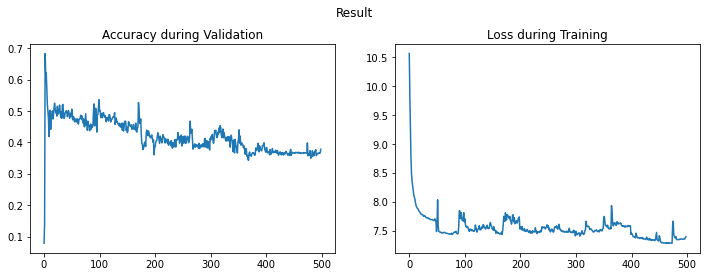

In [15]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

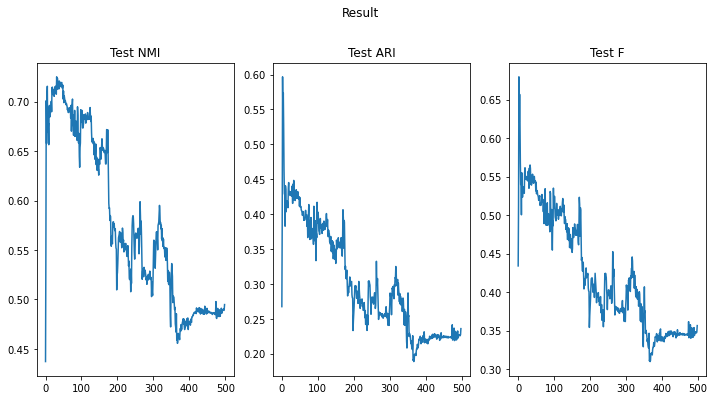

In [16]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()